In [1]:
from os.path import basename

from toolz import merge
%cd /home/sitnarf/projects/cardiovascular-risk-app/backend

from sklearn.calibration import calibration_curve
from functional import pipe, or_fn

from functools import partial
from typing import Callable, Iterable, Mapping
from nested_cv import get_cv_results_from_simple_cv_evaluation

from notebooks.heart_transplant.dependencies.heart_transplant_functions import format_feature
from scripts.feature_importance import plot_feature_importance_formatted


from matplotlib import pyplot
from pandas import Series

from visualisation import plot_roc_from_result, display_html, savefig, display_dict_as_table_horizontal

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import itertools
import os
from pathlib import Path
for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break


from utils import evaluate_and_assign_if_not_present
from notebooks.heart_transplant.heart_transplant_evaluate import HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, \
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER

import shelve
from notebooks.heart_transplant.dependencies.heart_transplant_metadata import heart_transplant_metadata as metadata

from evaluation_functions import compute_classification_metrics_from_results_with_statistics, join_folds_cv_result, \
    ModelResult, get_1_class_y_score
from formatting import compare_metrics_in_table,   b, render_struct_table
from notebooks.heart_transplant.dependencies.heart_transplant_data import get_reduced_binary_dataset_cached

pyplot.style.use('default')

PUBLISH_FOLDER  = './data/heart_transplant/publish'

/home/sitnarf/projects/cardiovascular-risk-app/backend


In [2]:
X_365, y_365, dataset_raw = get_reduced_binary_dataset_cached()

X_90, y_90, _ = get_reduced_binary_dataset_cached(survival_days=90)

In [3]:
def optimized_filter(key: str) -> bool:
    return key.endswith('optimized_roc')

def default_filter(key: str) -> bool:
    return key.endswith('default')

def expert_filter(key: str) -> bool:
    return 'expert' in key

def color_methods(key: str) -> Mapping:
    colors = pyplot.get_cmap('Paired').colors
    if 'xgboost' in key:
        index = 1
    elif 'random_forest' in key:
        index= 3
    elif 'ridge' in key:
        index = 5
    else:
        index = 1

    if 'default' in key:
        index -= 1

    return {'color': colors[index]}

def present_results(file_name: str, y: Series, include_ci=False, filter_callback: Callable[[str], bool] = None) -> None:
    metrics = {}

    results = shelve.open(file_name, flag='r')

    for name, item in results.items():
        if filter_callback is None or filter_callback(name):
            evaluate_and_assign_if_not_present(
                metrics,
                name,
                lambda: compute_classification_metrics_from_results_with_statistics(y, [item['chosen']['result']], ignore_warning=True)
            )

    pipe(
        compare_metrics_in_table(
            metrics,
            include=('roc_auc', 'f1', 'recall', 'fpr'),
            include_ci=include_ci,
        ),
        render_struct_table,
        display_html,
    )

    results.close()


def present_rocs(file_name: str, y: Series, filter_callback: Callable[[str], bool], style_by_callback: Iterable[Callable[[str], Mapping]] = None) -> None:
    style_by_callback = style_by_callback if style_by_callback is not None else {}

    results = shelve.open(file_name, flag='r')

    for method_name, item in results.items():
        if filter_callback is None or filter_callback(method_name):
            style = merge(*[callback(method_name) for callback in style_by_callback], {})
            plot_roc_from_result(y,item['chosen']['result'], label=method_name, plot_kwargs=style)

    savefig(PUBLISH_FOLDER+f'/rocs_{basename(file_name)}')

    pyplot.show()

    results.close()

## Shuffled CV

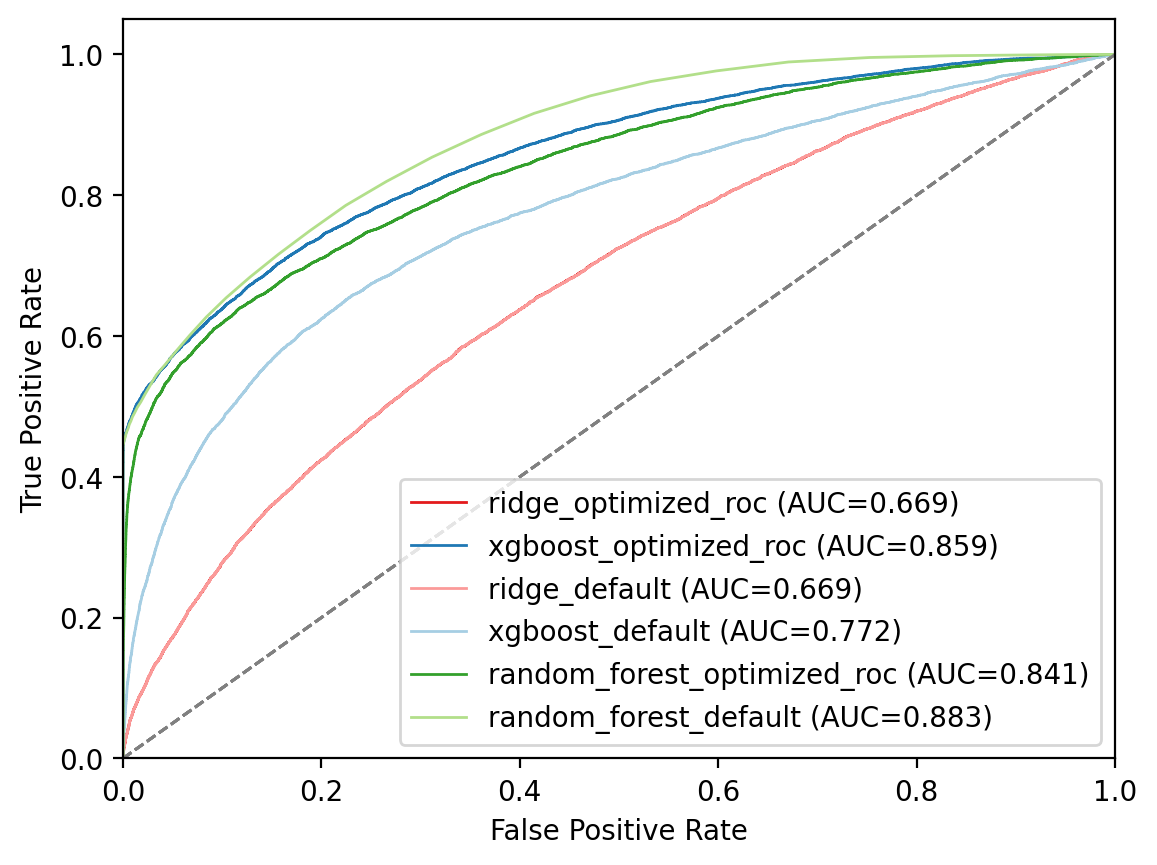

In [4]:
present_results(HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, y_365)
print()
present_rocs(
    HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER,
    y_365,
    filter_callback=or_fn(optimized_filter, default_filter),
    style_by_callback=[color_methods]
)

## Expanding window

### 365 days

#### All age groups

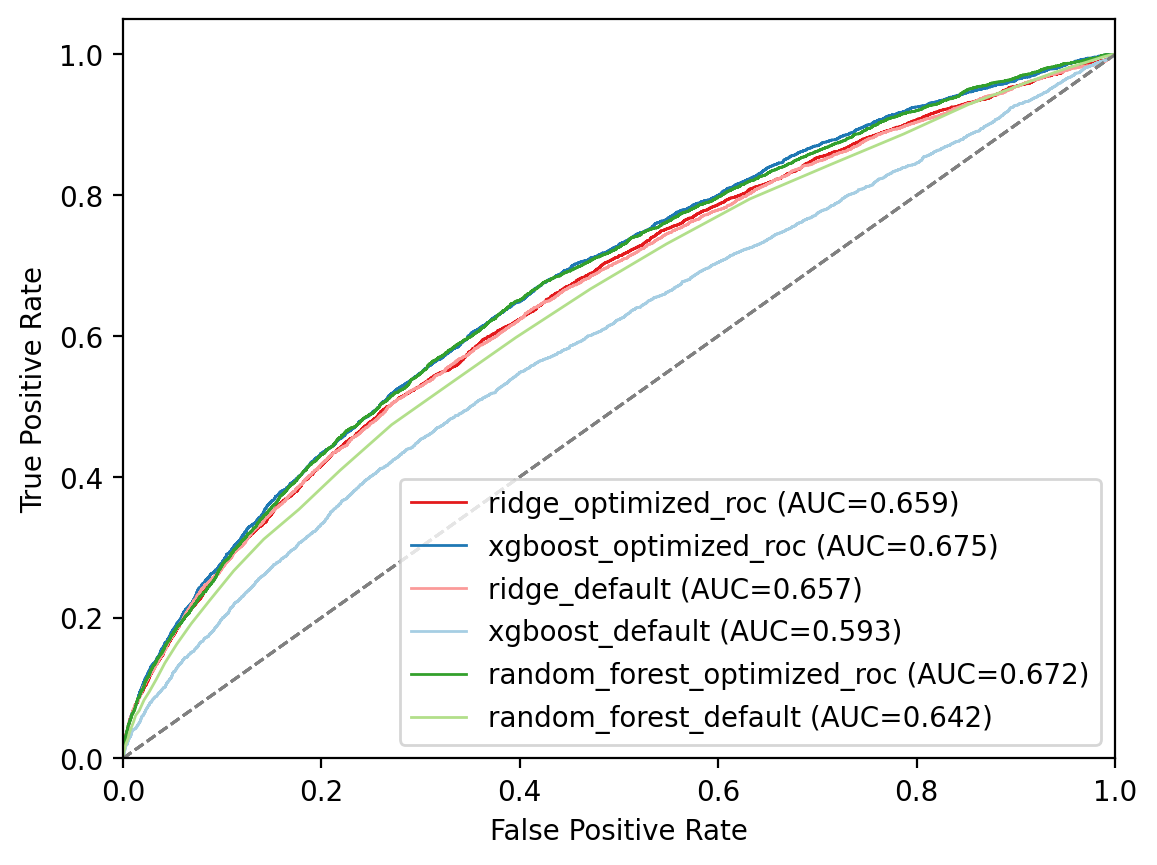

In [5]:
present_results(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_all', y_365, filter_callback=or_fn(optimized_filter, default_filter, expert_filter))
print()
present_rocs(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_all',
    y_365,
    filter_callback=or_fn(optimized_filter, default_filter),
    style_by_callback=[color_methods]
)


#### < 18 years old

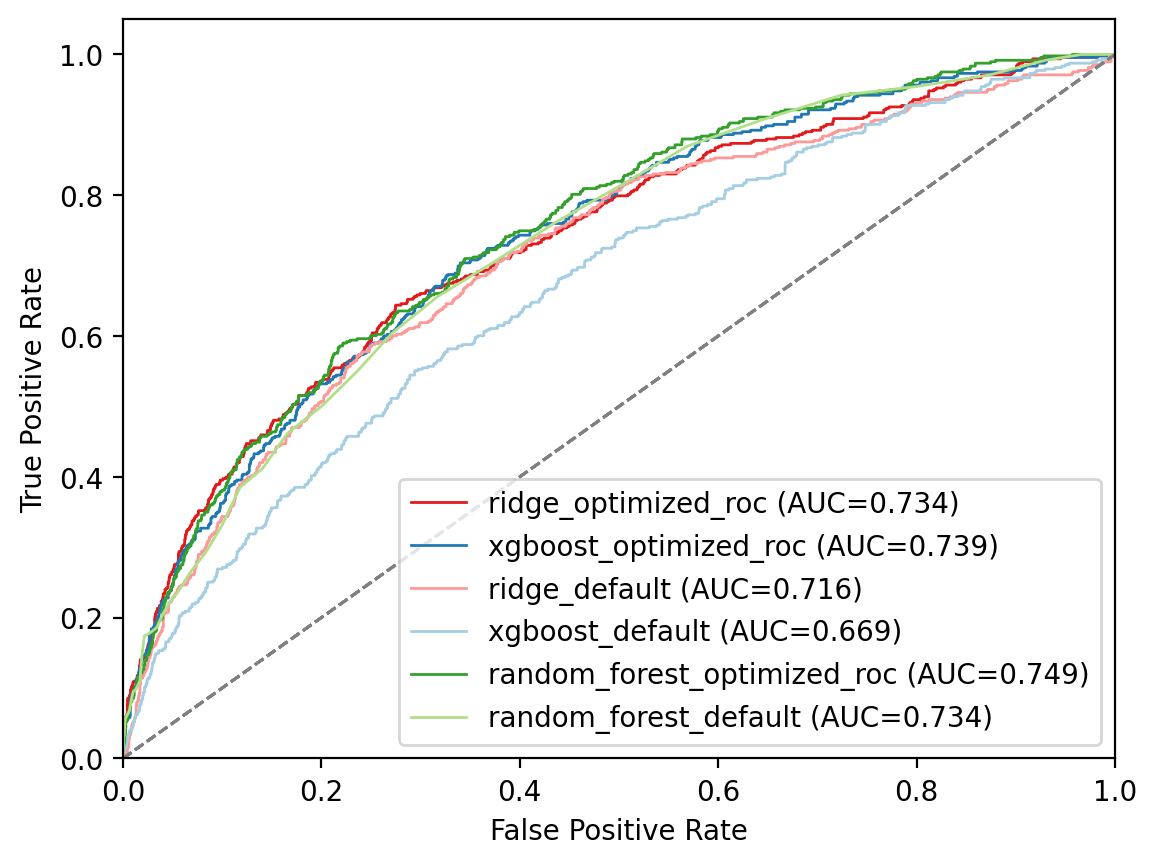

In [6]:
present_results(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_l_18', y_365, filter_callback=or_fn(optimized_filter, default_filter))
print()
present_rocs(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_l_18',
    y_365,
    filter_callback=or_fn(optimized_filter, default_filter),
    style_by_callback=[color_methods]
)


#### >= 18 years old

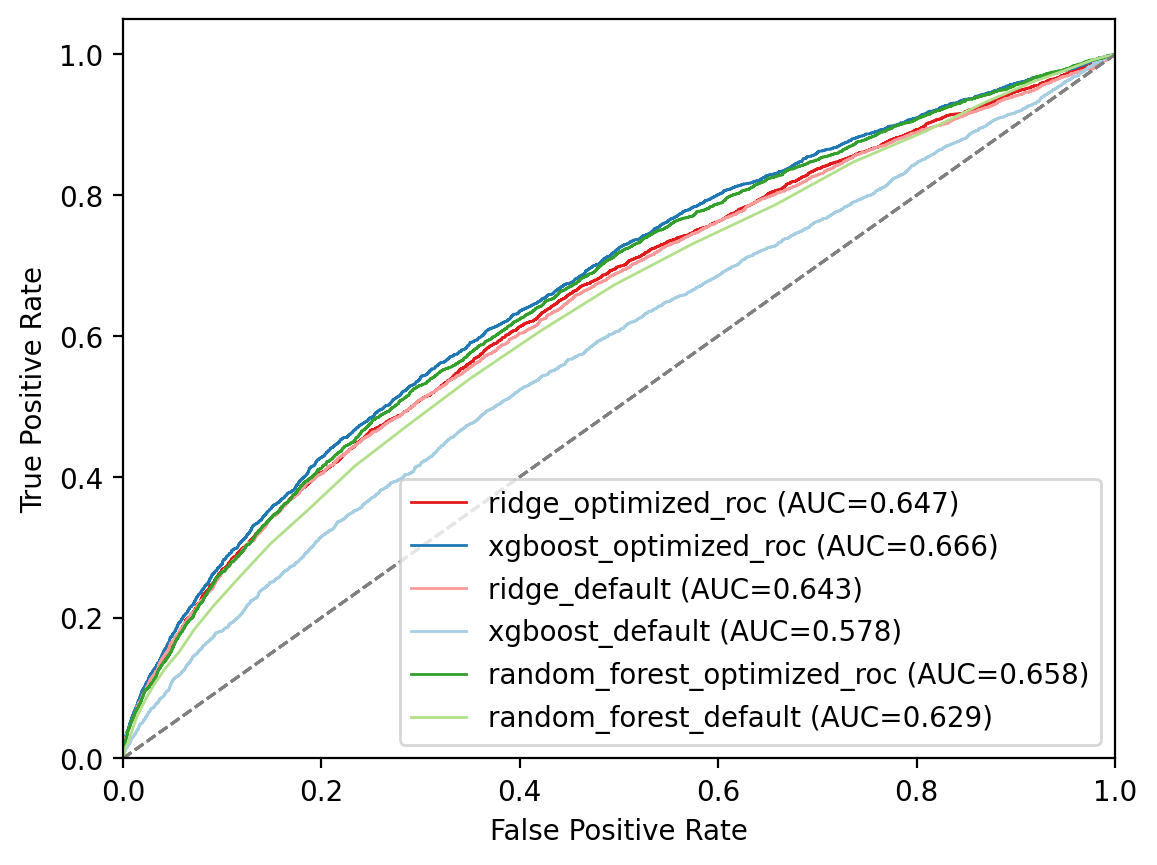

In [7]:
present_results(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_me_18', y_365, filter_callback=or_fn(optimized_filter, default_filter))

present_rocs(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_me_18',
    y_365,
    filter_callback=or_fn(optimized_filter, default_filter),
    style_by_callback=[color_methods]
)

### 90 days

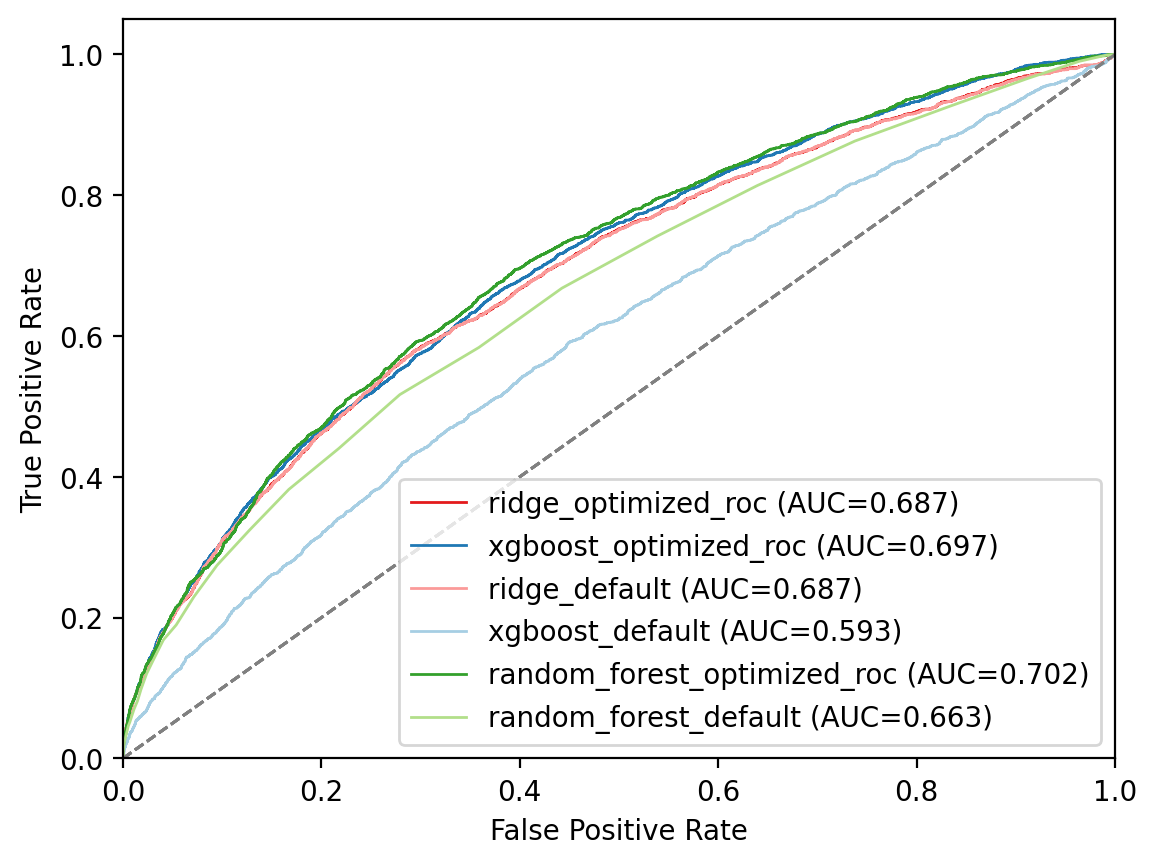

In [8]:
present_results(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+"_90_all", y_90, filter_callback=or_fn(optimized_filter, default_filter))
print()
present_rocs(
    HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_90_all',
    y_90,
    filter_callback=or_fn(optimized_filter, default_filter),
    style_by_callback=[color_methods]
)

# Calibration plots

## Shuffled CV

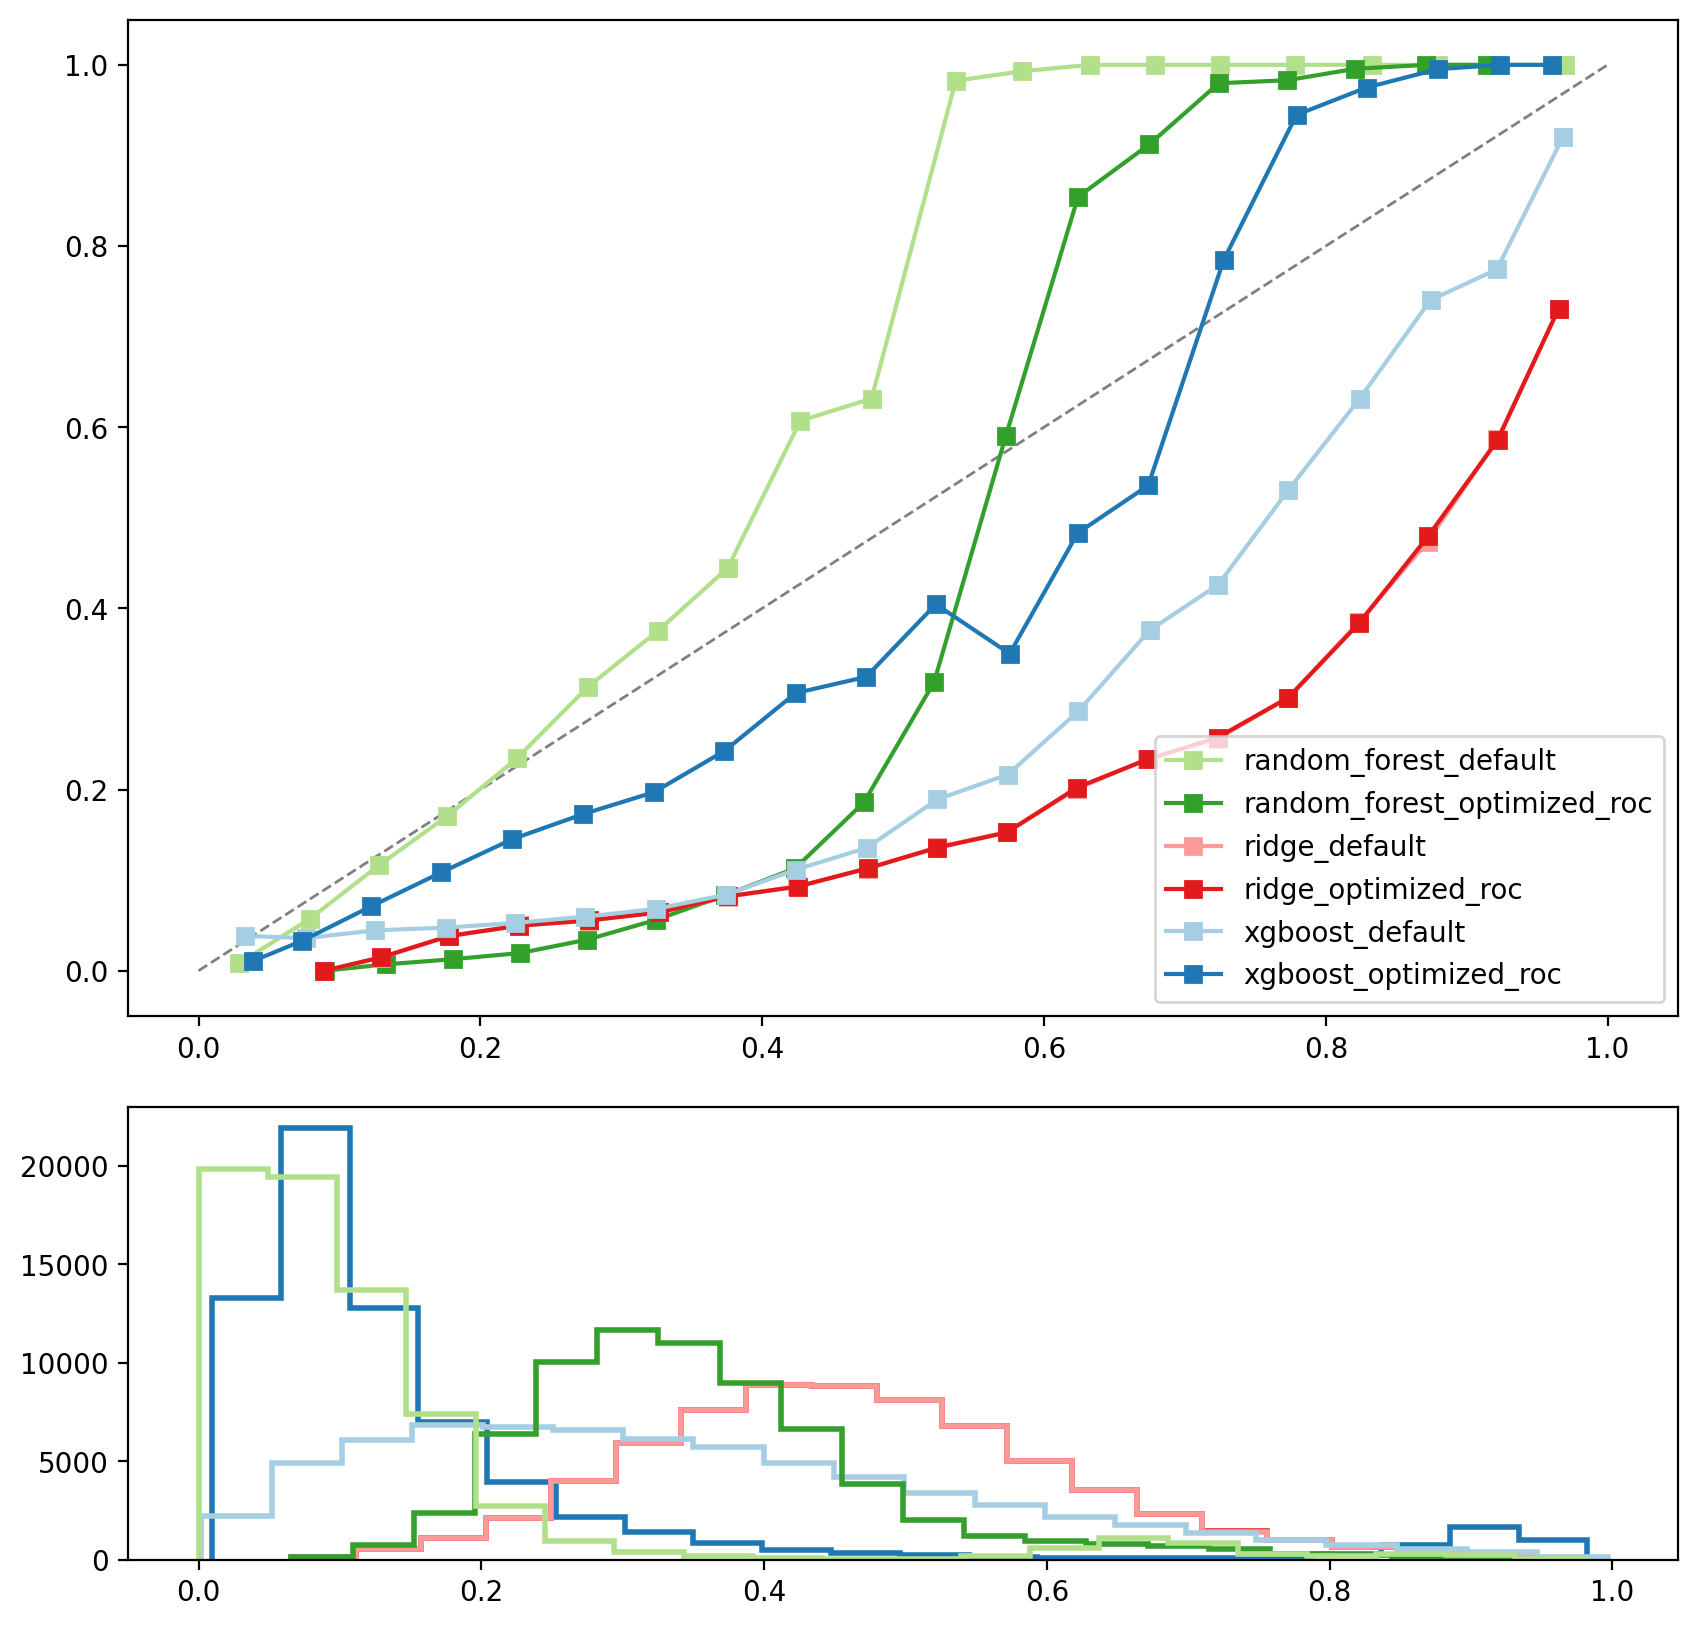

In [9]:
def present_calibration_plots(
        file_name: str,
        y: Series,
        filter_callback: Callable[[str], bool] = None,
        style_by_callback: Iterable[Callable[[str], Mapping]] = None
) -> None:
    results = shelve.open(file_name, flag='r')
    fig = pyplot.figure(1, figsize=(10, 10))
    ax1 = pyplot.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = pyplot.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

    for method, item in sorted(results.items(), key=lambda i: i[0]):
        if filter_callback is None or filter_callback(method):
            style = merge(*[callback(method) for callback in style_by_callback], {})
            result_joined: ModelResult = join_folds_cv_result(item['chosen']['result'])
            fraction_of_positives, mean_predicted_value  = calibration_curve(
                y.loc[result_joined['y_test_score'].index], get_1_class_y_score(result_joined['y_test_score']),
                n_bins=20
            )
            ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label=method, **style)

    ax1.legend(loc="lower right")

    for method, item in results.items():
        if filter_callback is None or filter_callback(method):
            result_joined: ModelResult = join_folds_cv_result(item['chosen']['result'])
            style = merge(*[callback(method) for callback in style_by_callback], {})
            ax2.hist(
                get_1_class_y_score(result_joined['y_test_score']),
                bins=20,
                label=method,
                histtype="step",
                lw=2,
                **style
            )
    savefig(PUBLISH_FOLDER+f'/calibration/{basename(file_name)}')
    fig.show()

    results.close()

present_calibration_plots(HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, y_365, filter_callback=or_fn(optimized_filter, default_filter), style_by_callback=[color_methods])

## Expanding window

### 365 days

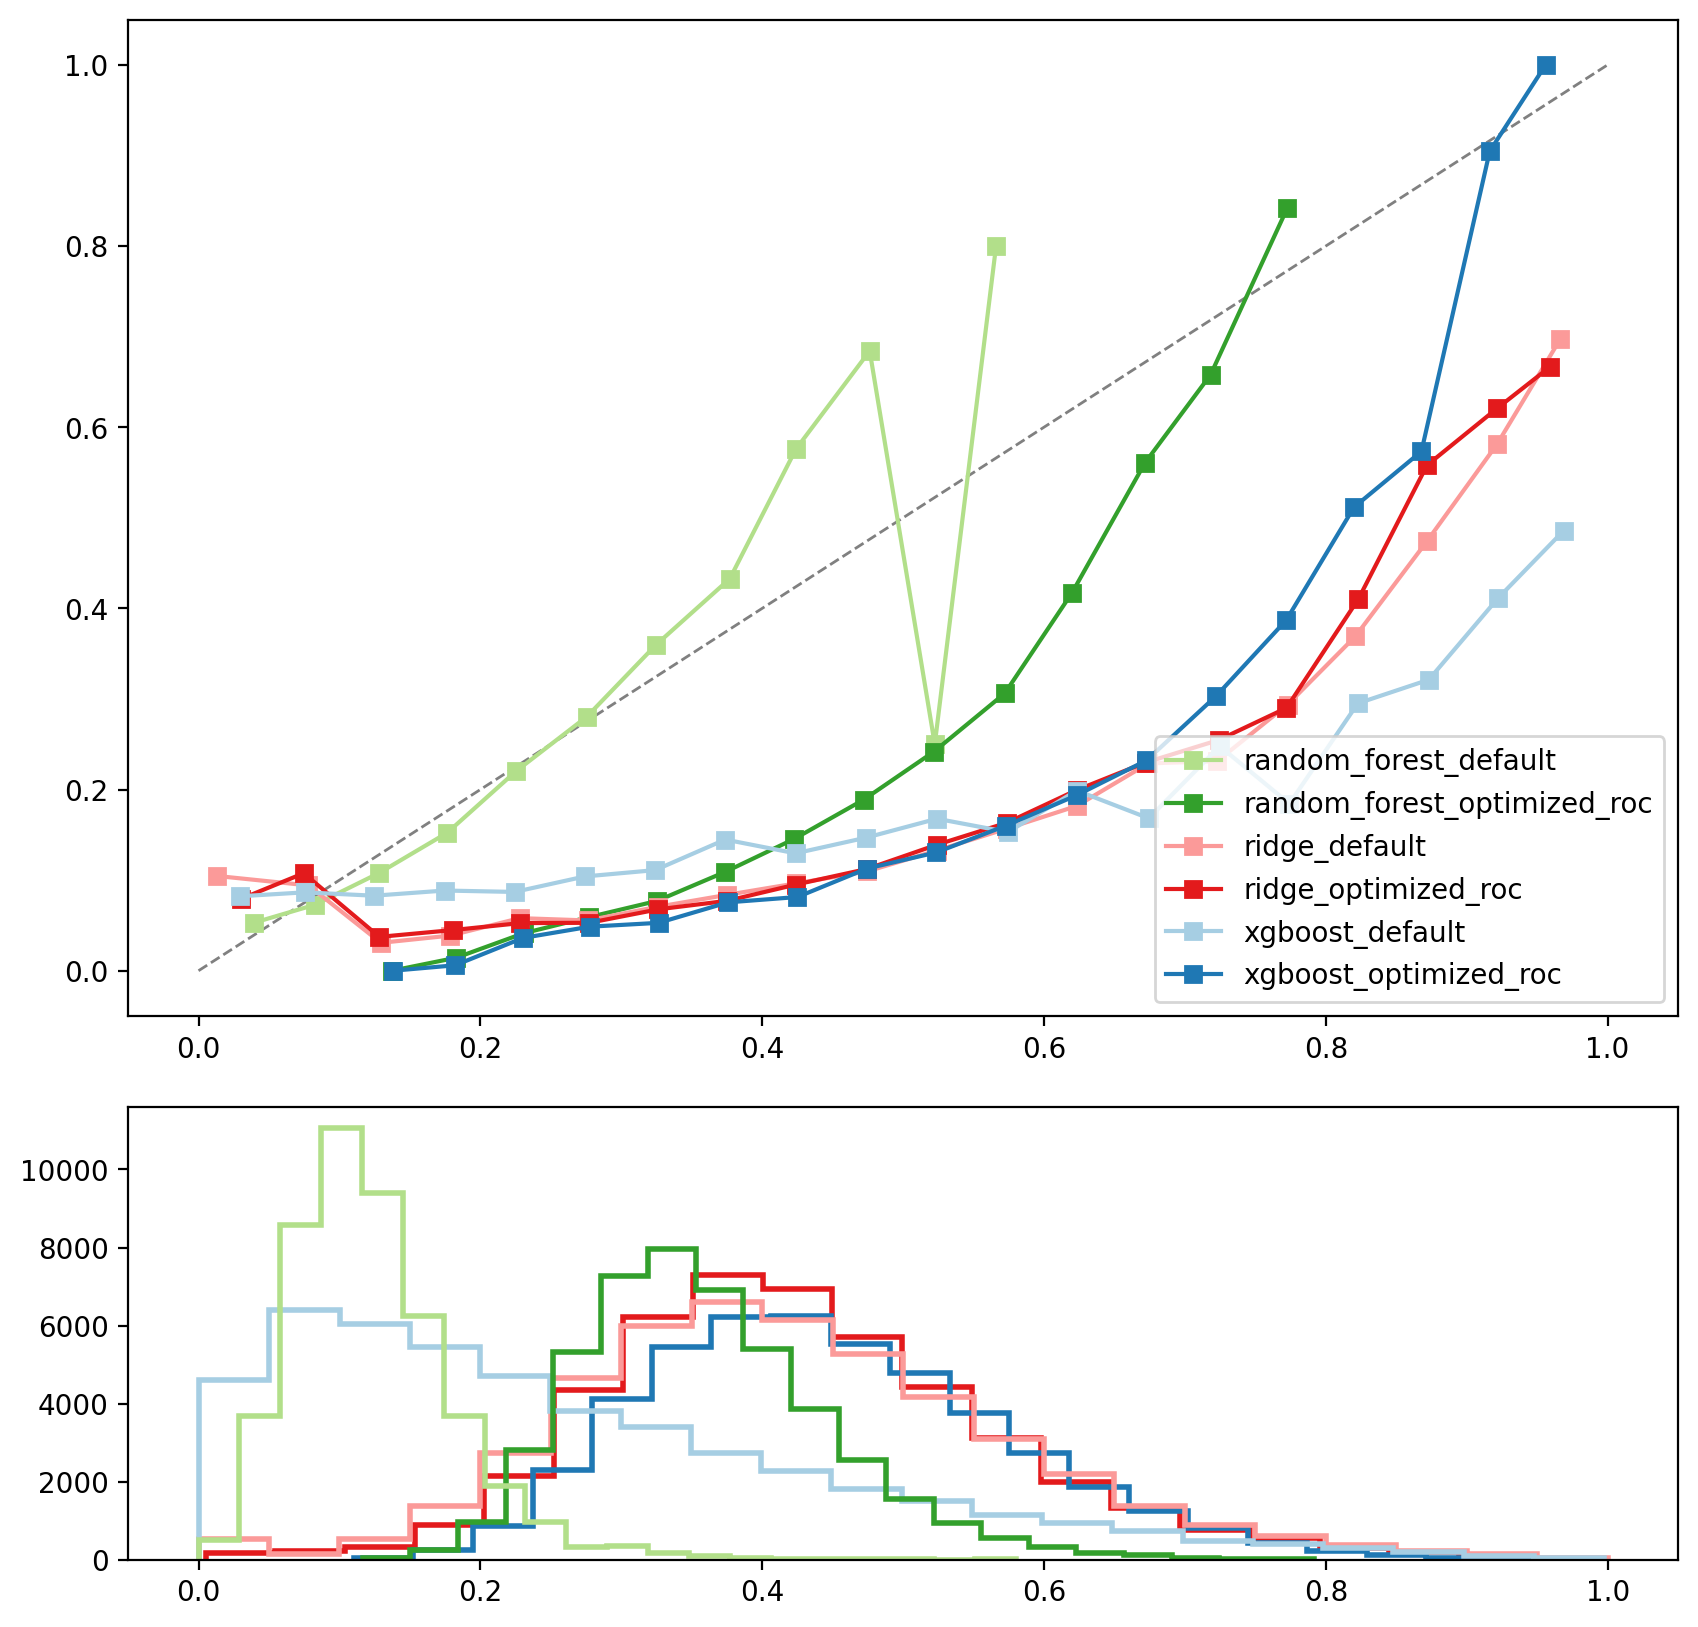

In [10]:
present_calibration_plots(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_all', y_365, filter_callback=or_fn(optimized_filter, default_filter), style_by_callback=[color_methods])


#### All age groups

#### < 18 years old

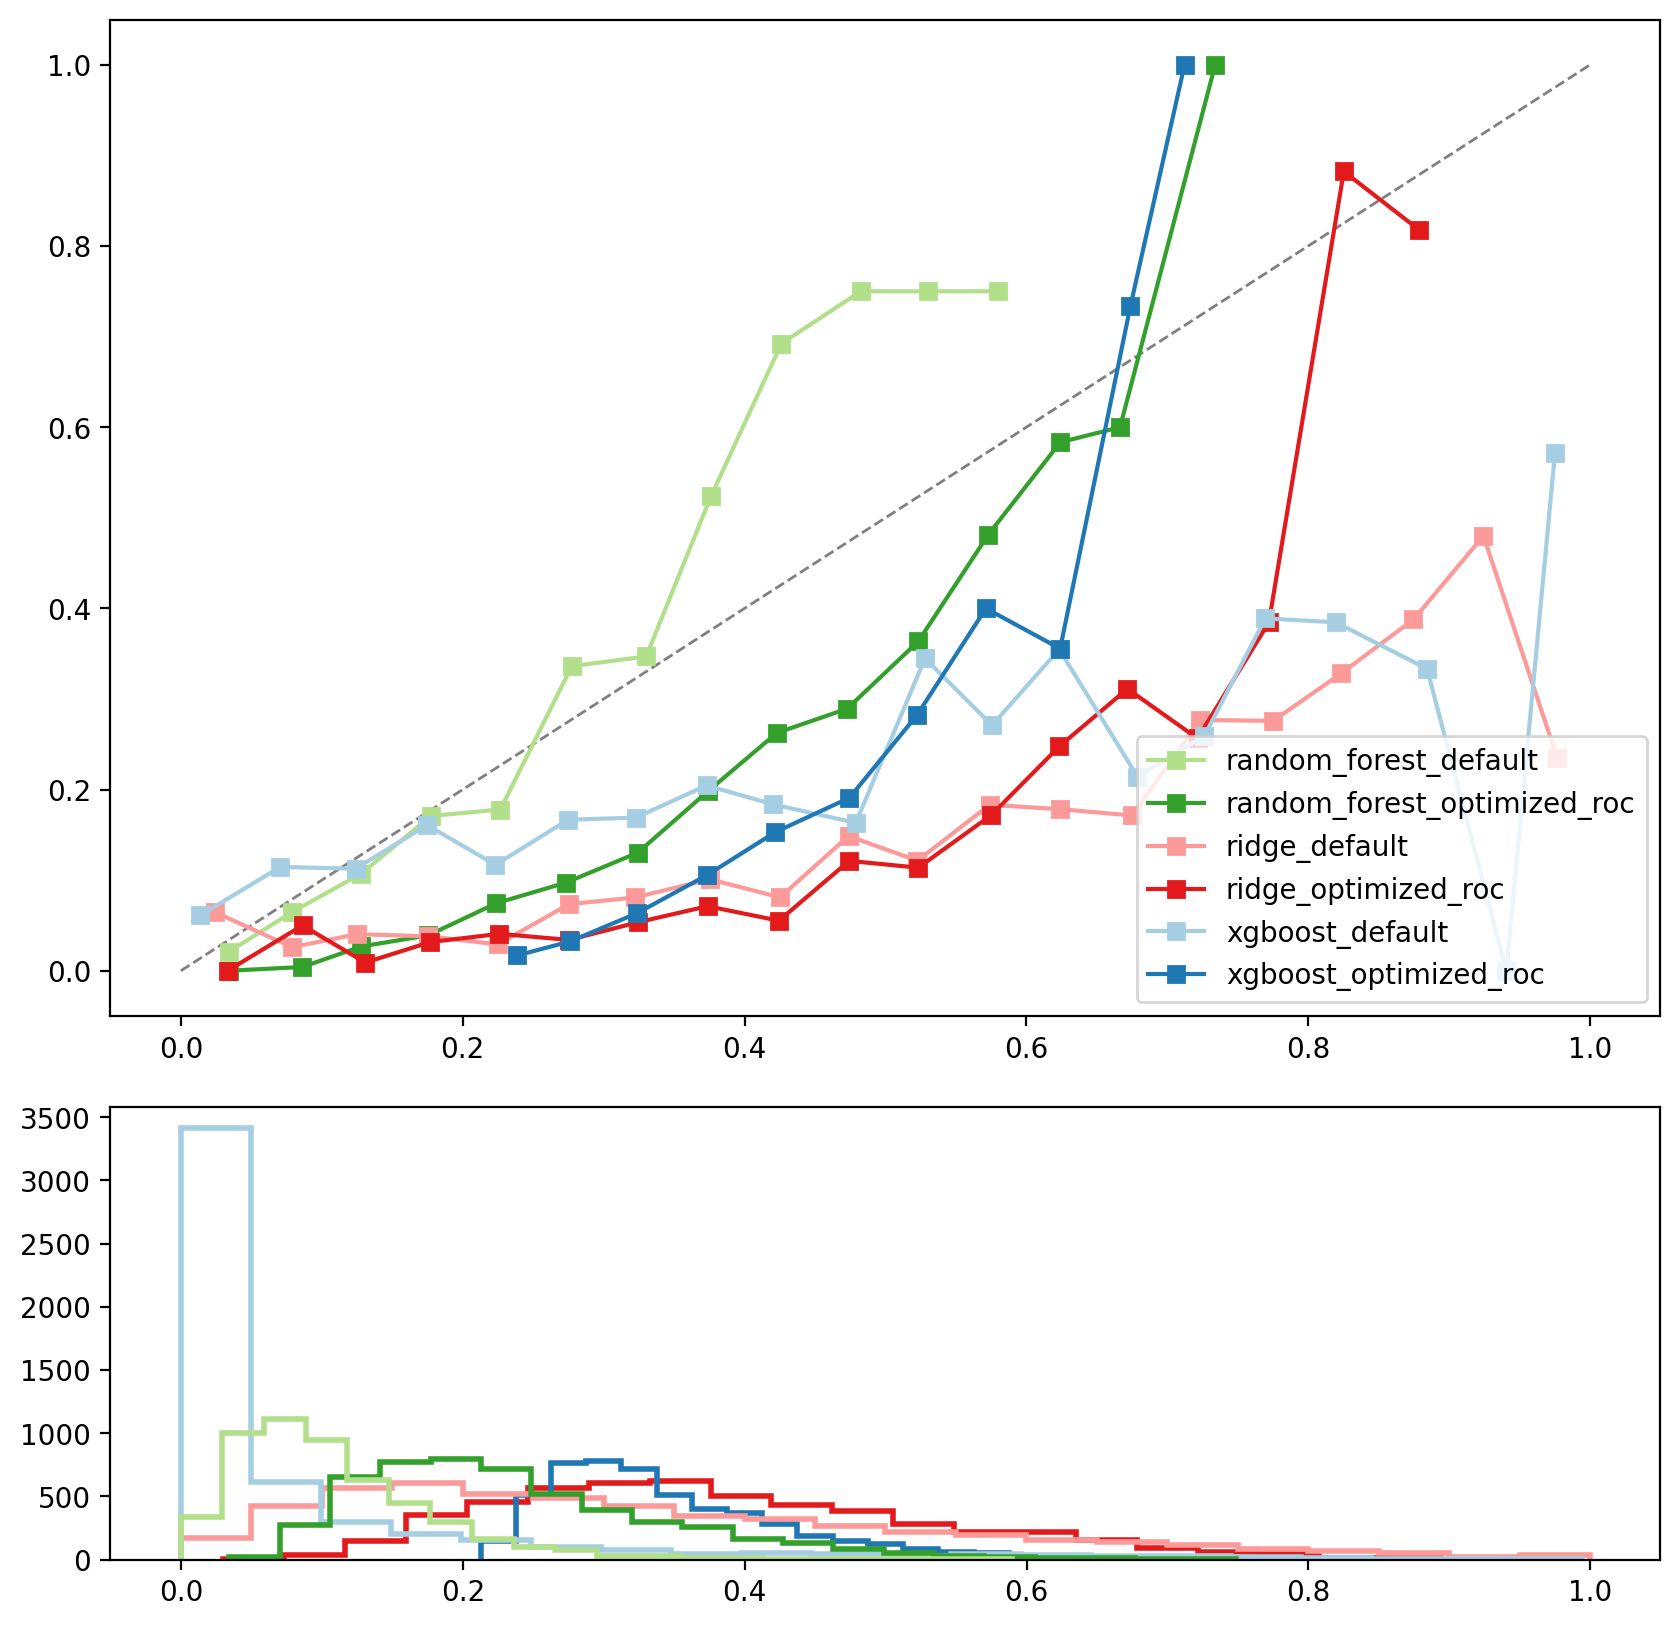

In [11]:
present_calibration_plots(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_l_18', y_365, filter_callback=or_fn(optimized_filter, default_filter), style_by_callback=[color_methods])

#### >= 18 years old

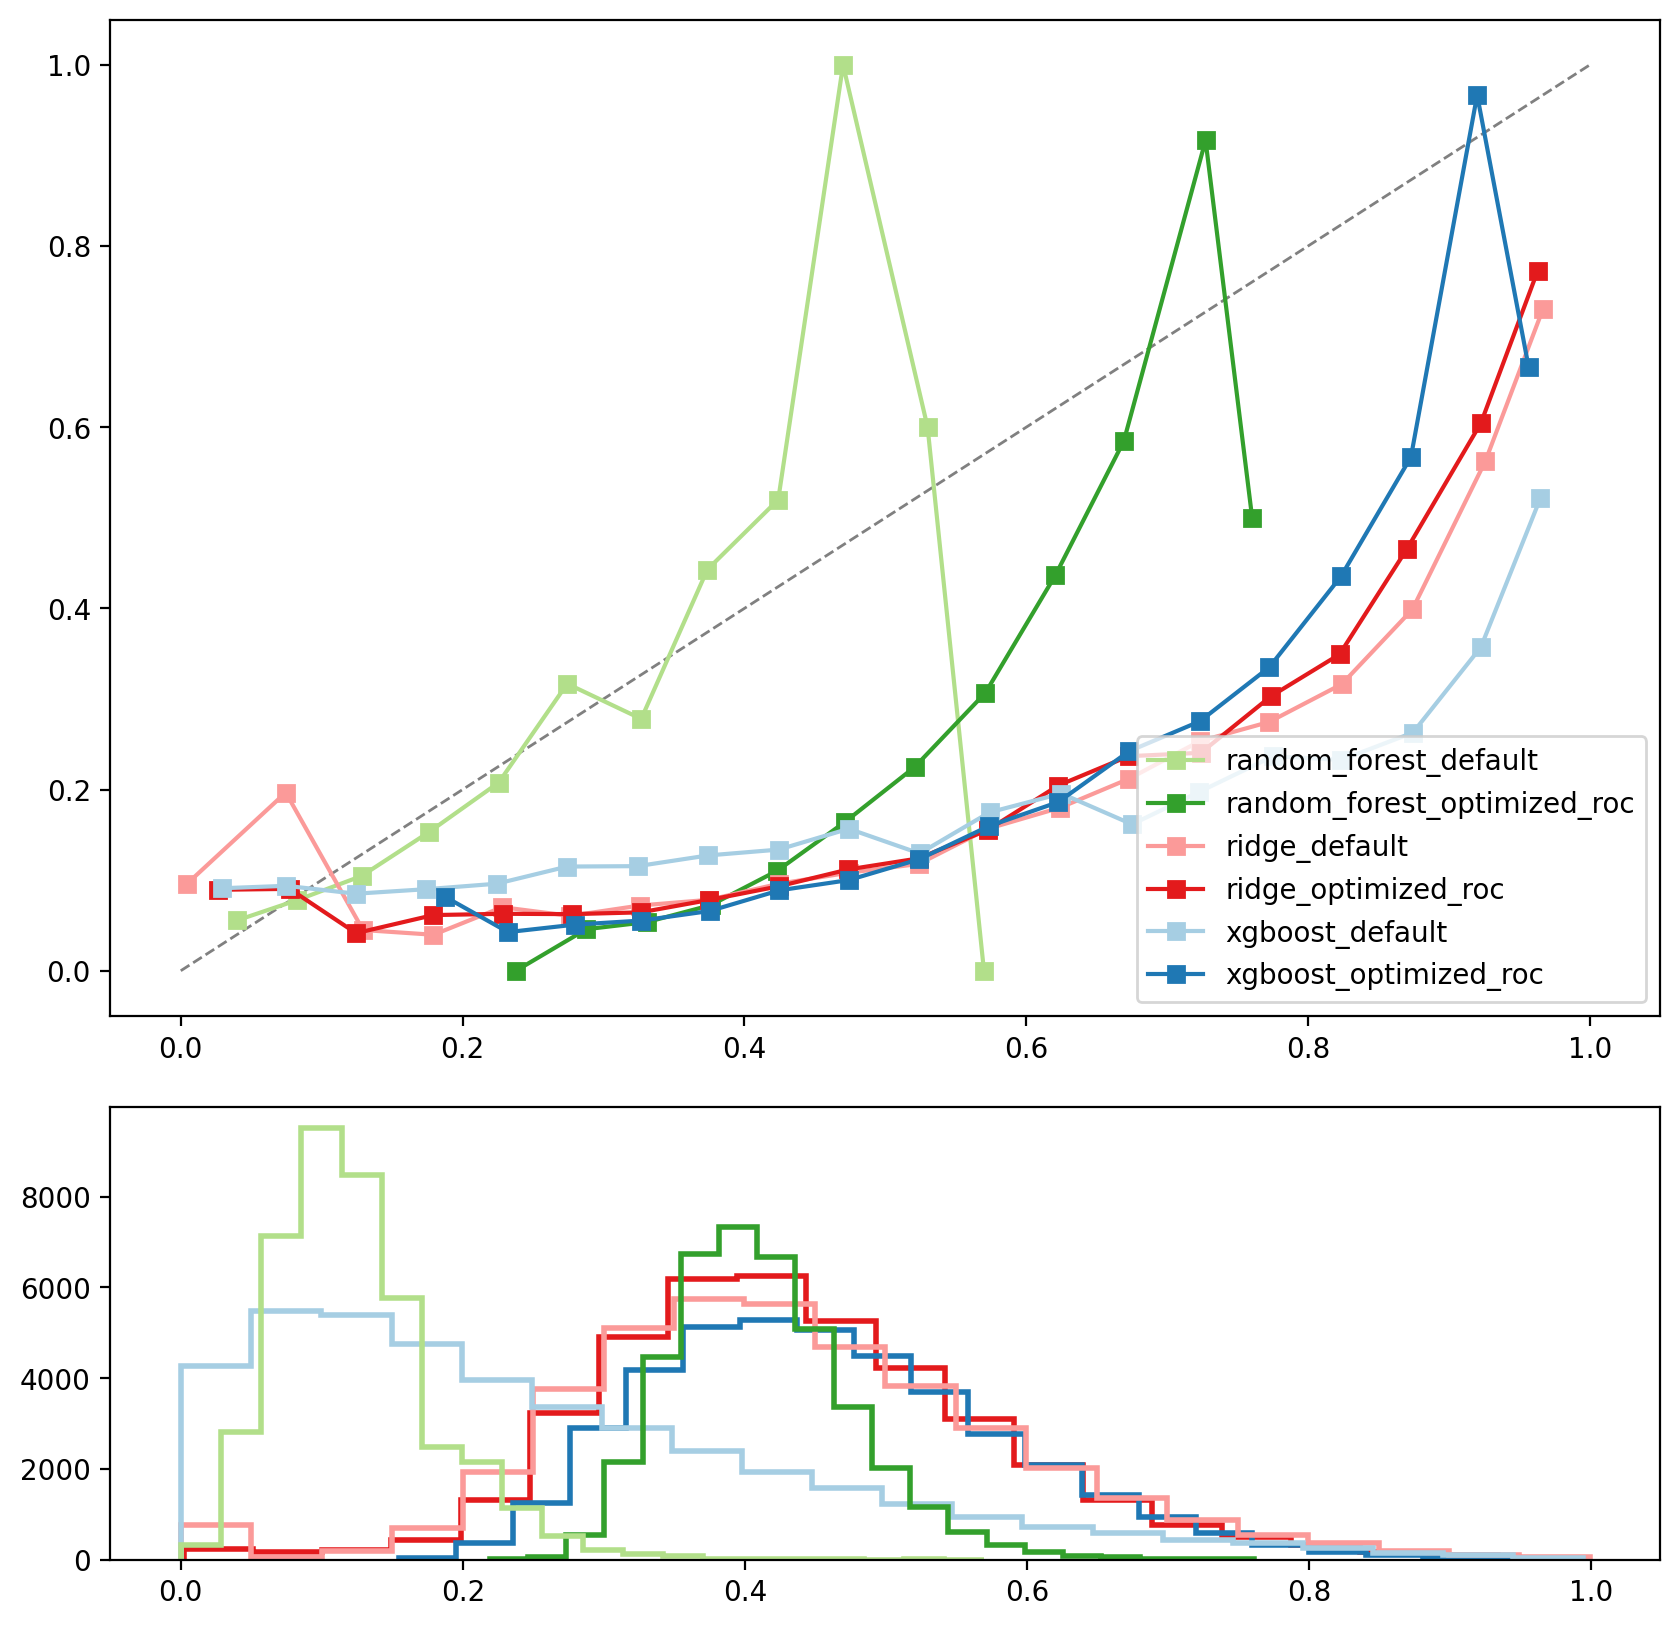

In [12]:
present_calibration_plots(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_me_18', y_365, filter_callback=or_fn(optimized_filter, default_filter), style_by_callback=[color_methods])

### 90 days

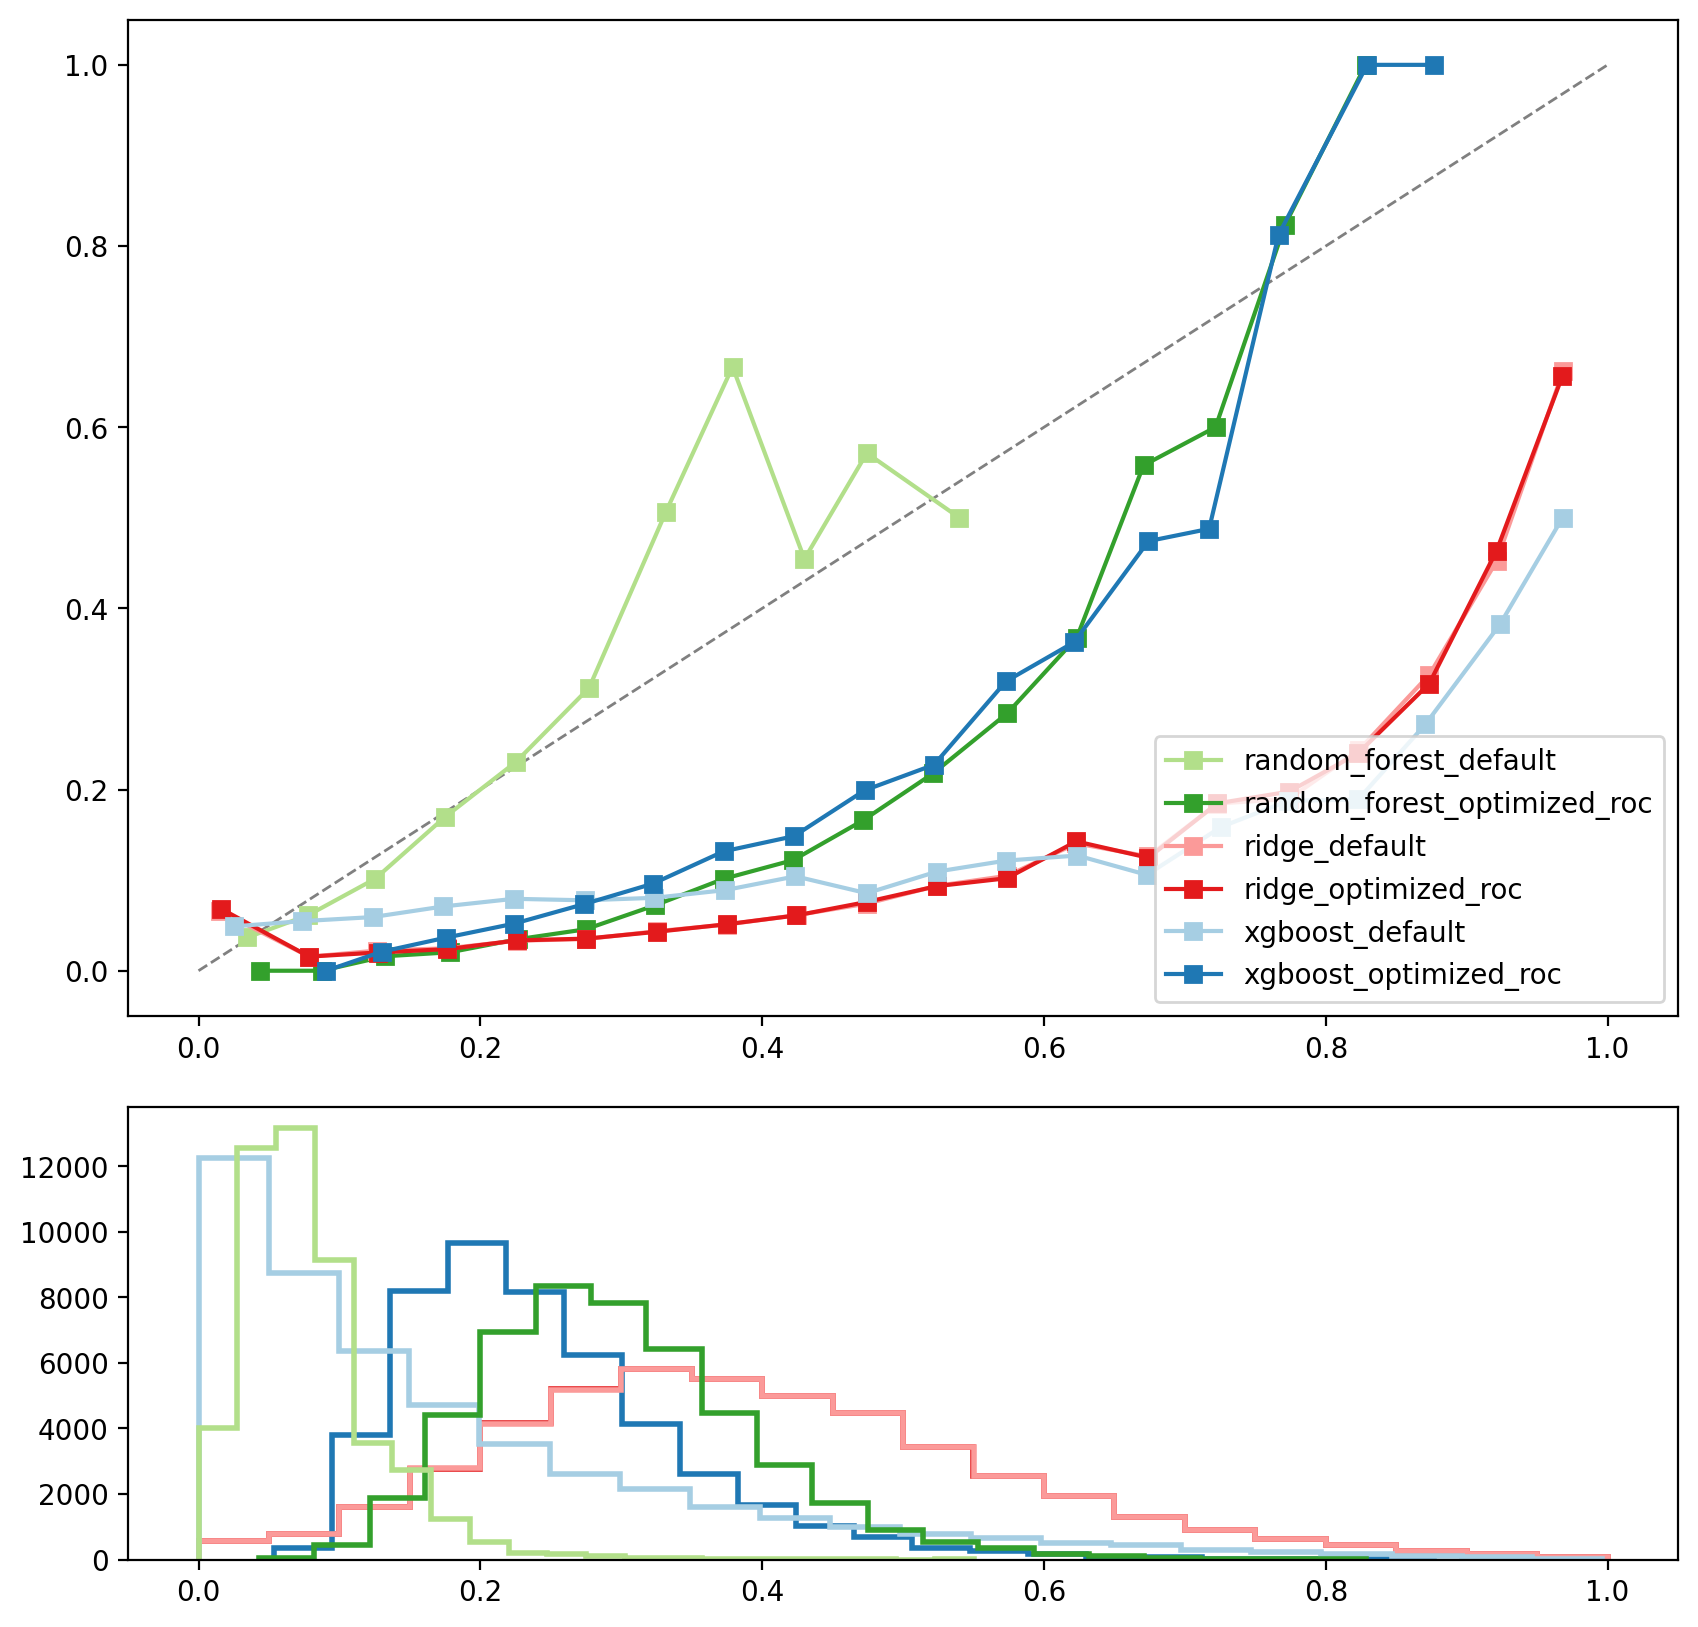

In [13]:
present_calibration_plots(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_90_all', y_90, filter_callback=or_fn(optimized_filter, default_filter), style_by_callback=[color_methods])

# Feature importance

In [14]:
def present_feature_importance(file_name: str, filter_callback: Callable[[str], bool] = None) -> None:

    results = shelve.open(file_name, flag='r')
    for name, item in results.items():

        if filter_callback is None or filter_callback(name):
            pyplot.figure(figsize=(10, 10))
            pyplot.title(name)
            plot_feature_importance_formatted(get_cv_results_from_simple_cv_evaluation([item]),format_feature=partial(format_feature, metadata), n_features=20)
            pyplot.tight_layout()
            savefig(PUBLISH_FOLDER+f'/feature_importance/{name}')
            pyplot.show()

## Shuffled CV

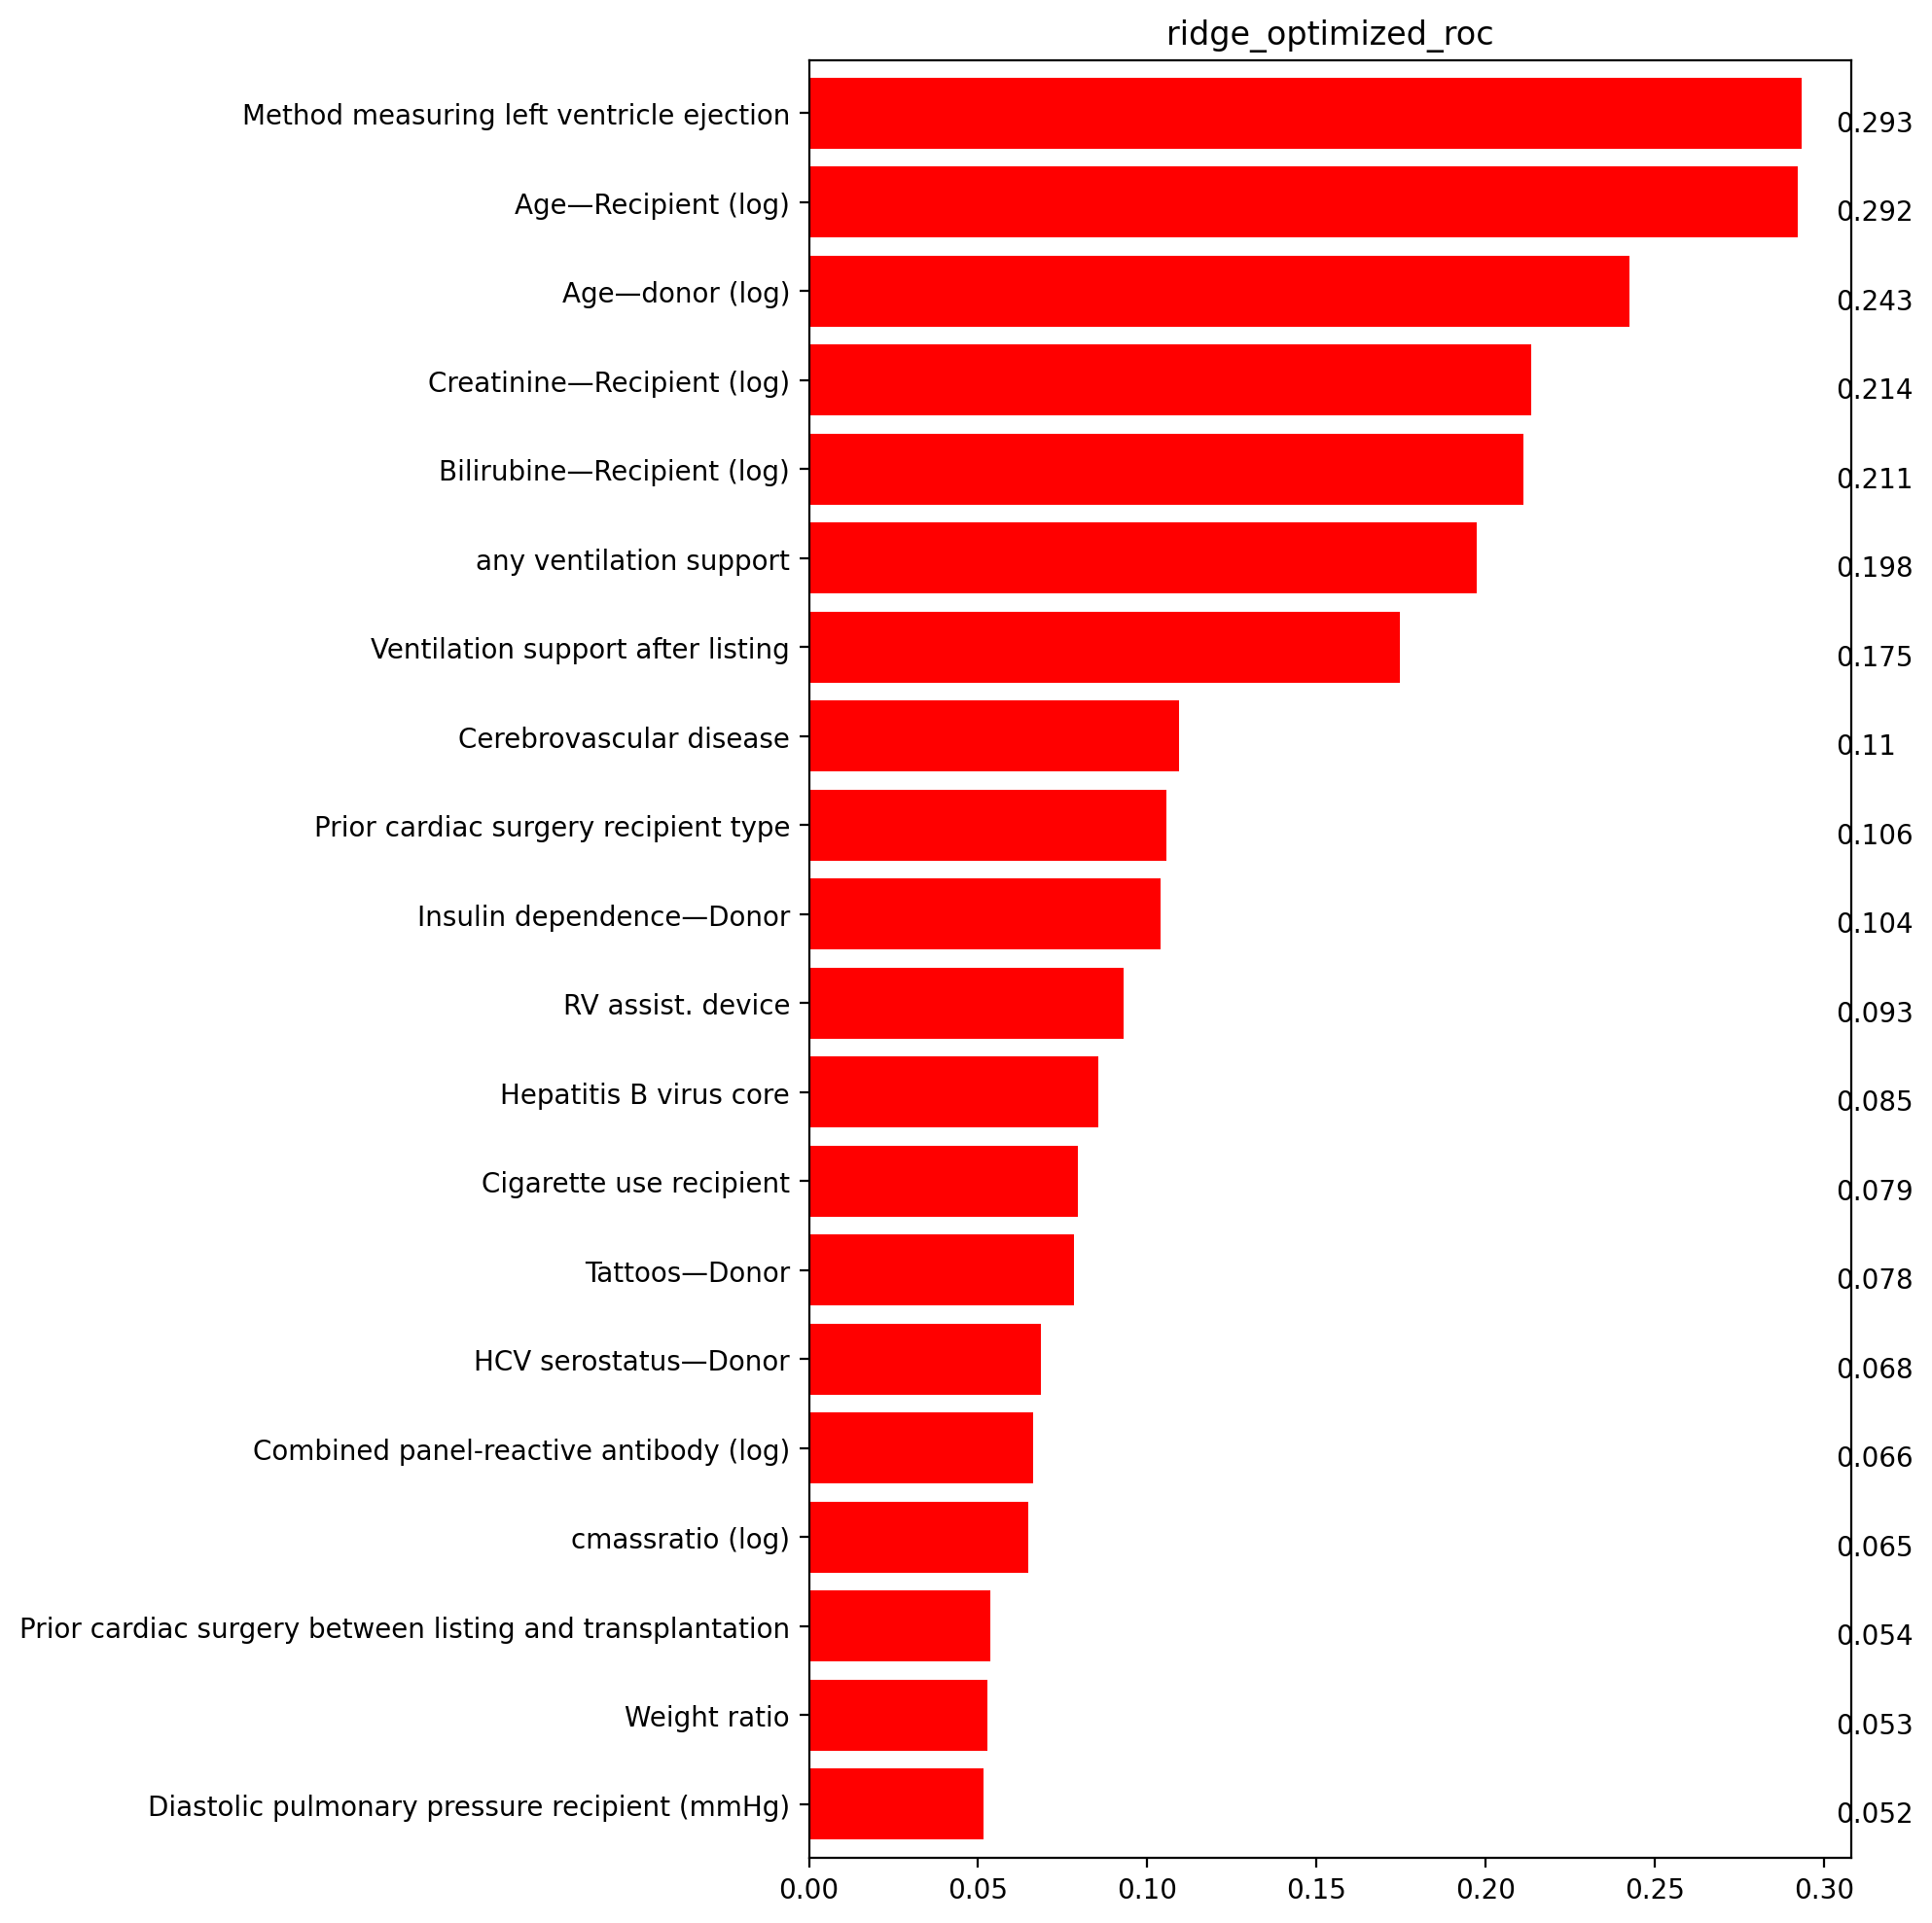

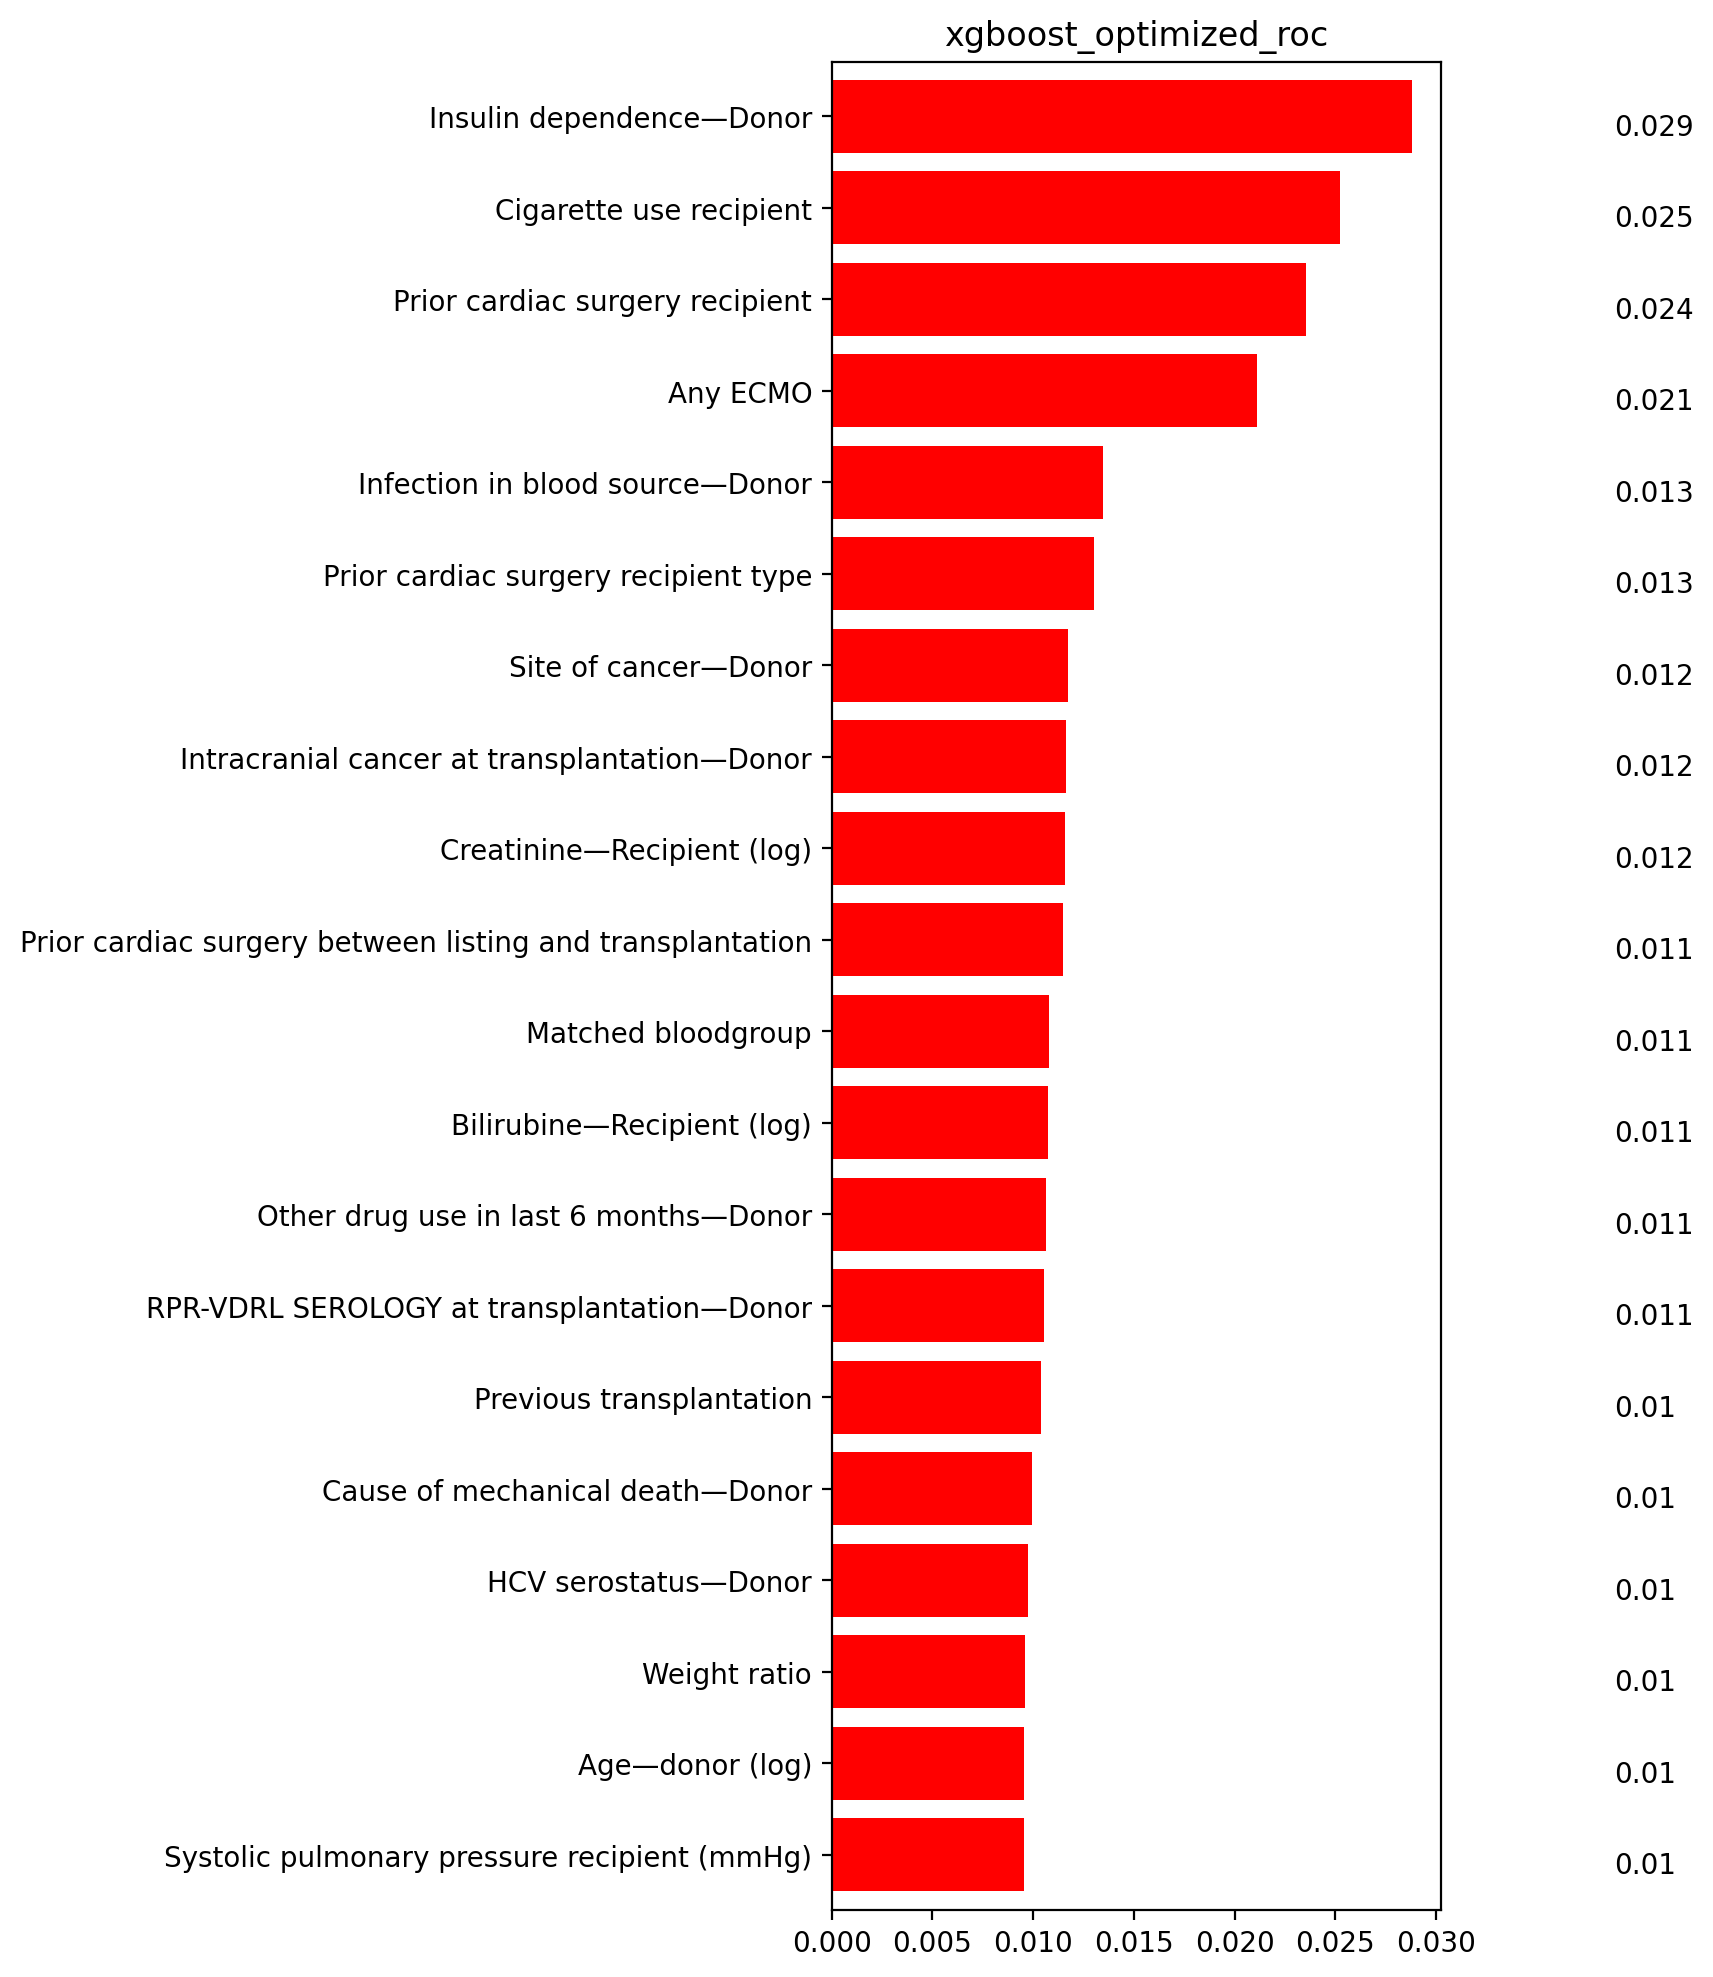

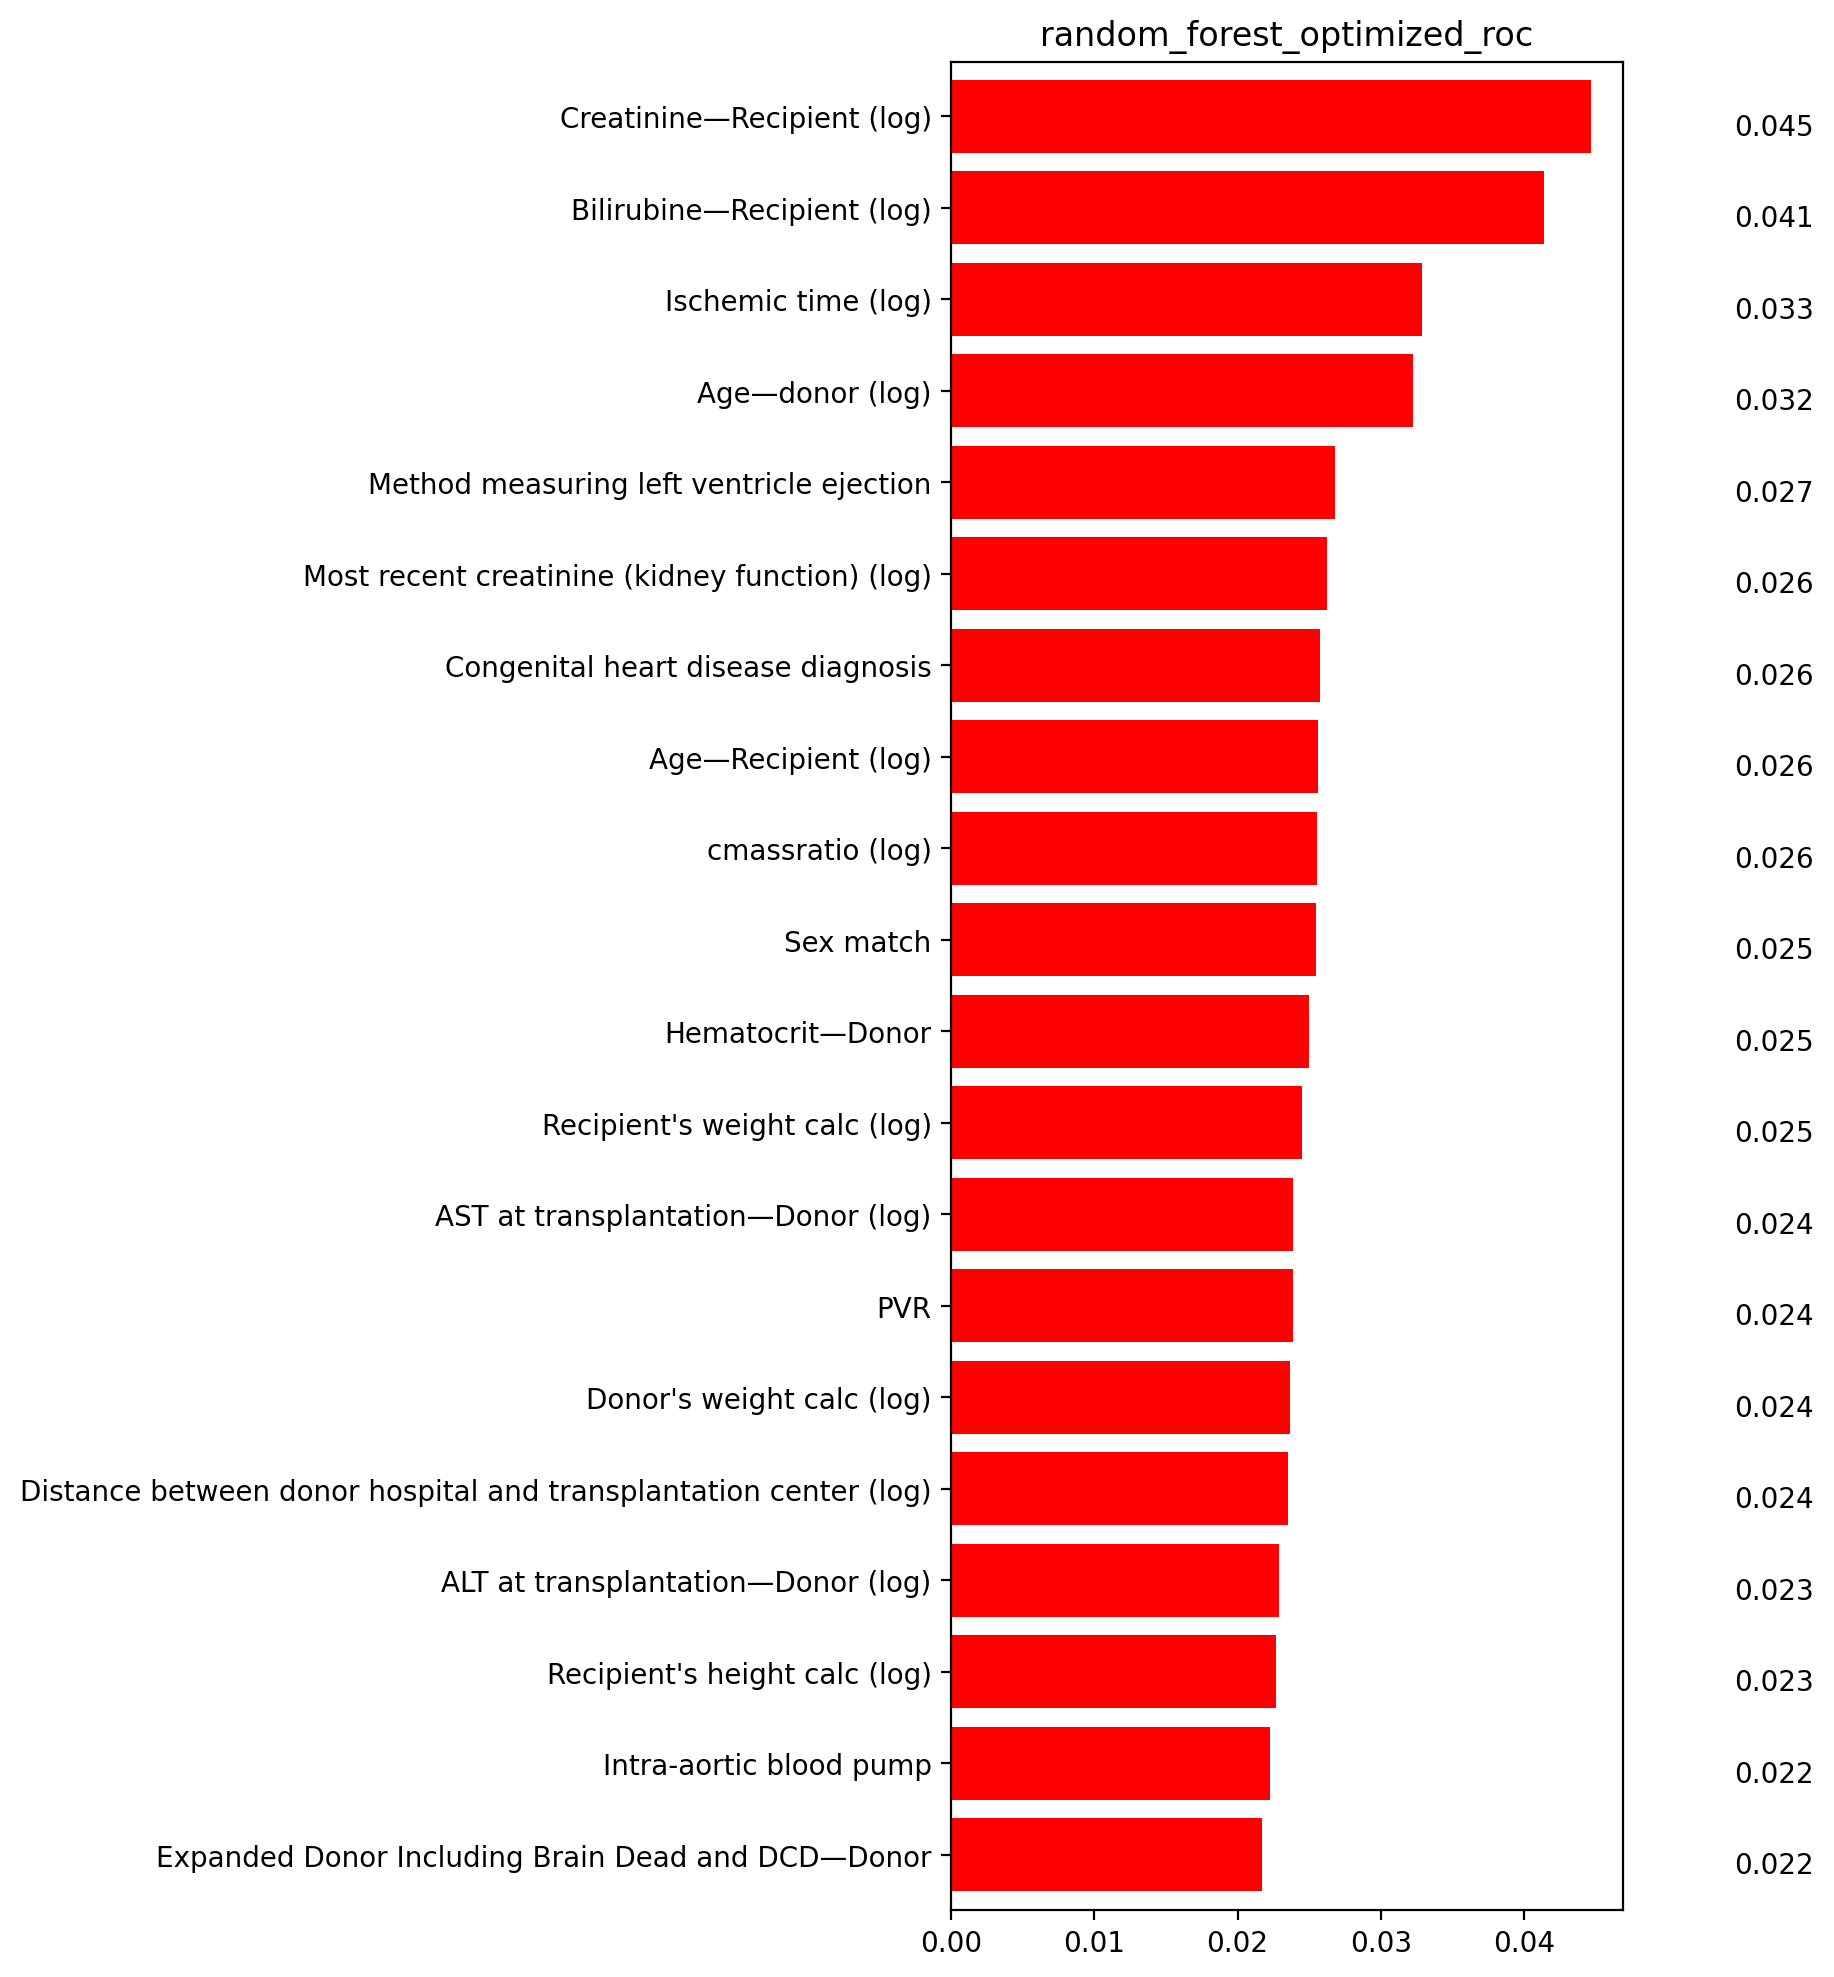

In [15]:
present_feature_importance(HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, filter_callback=optimized_filter)


## Expanding window

### 365 days

#### All age groups

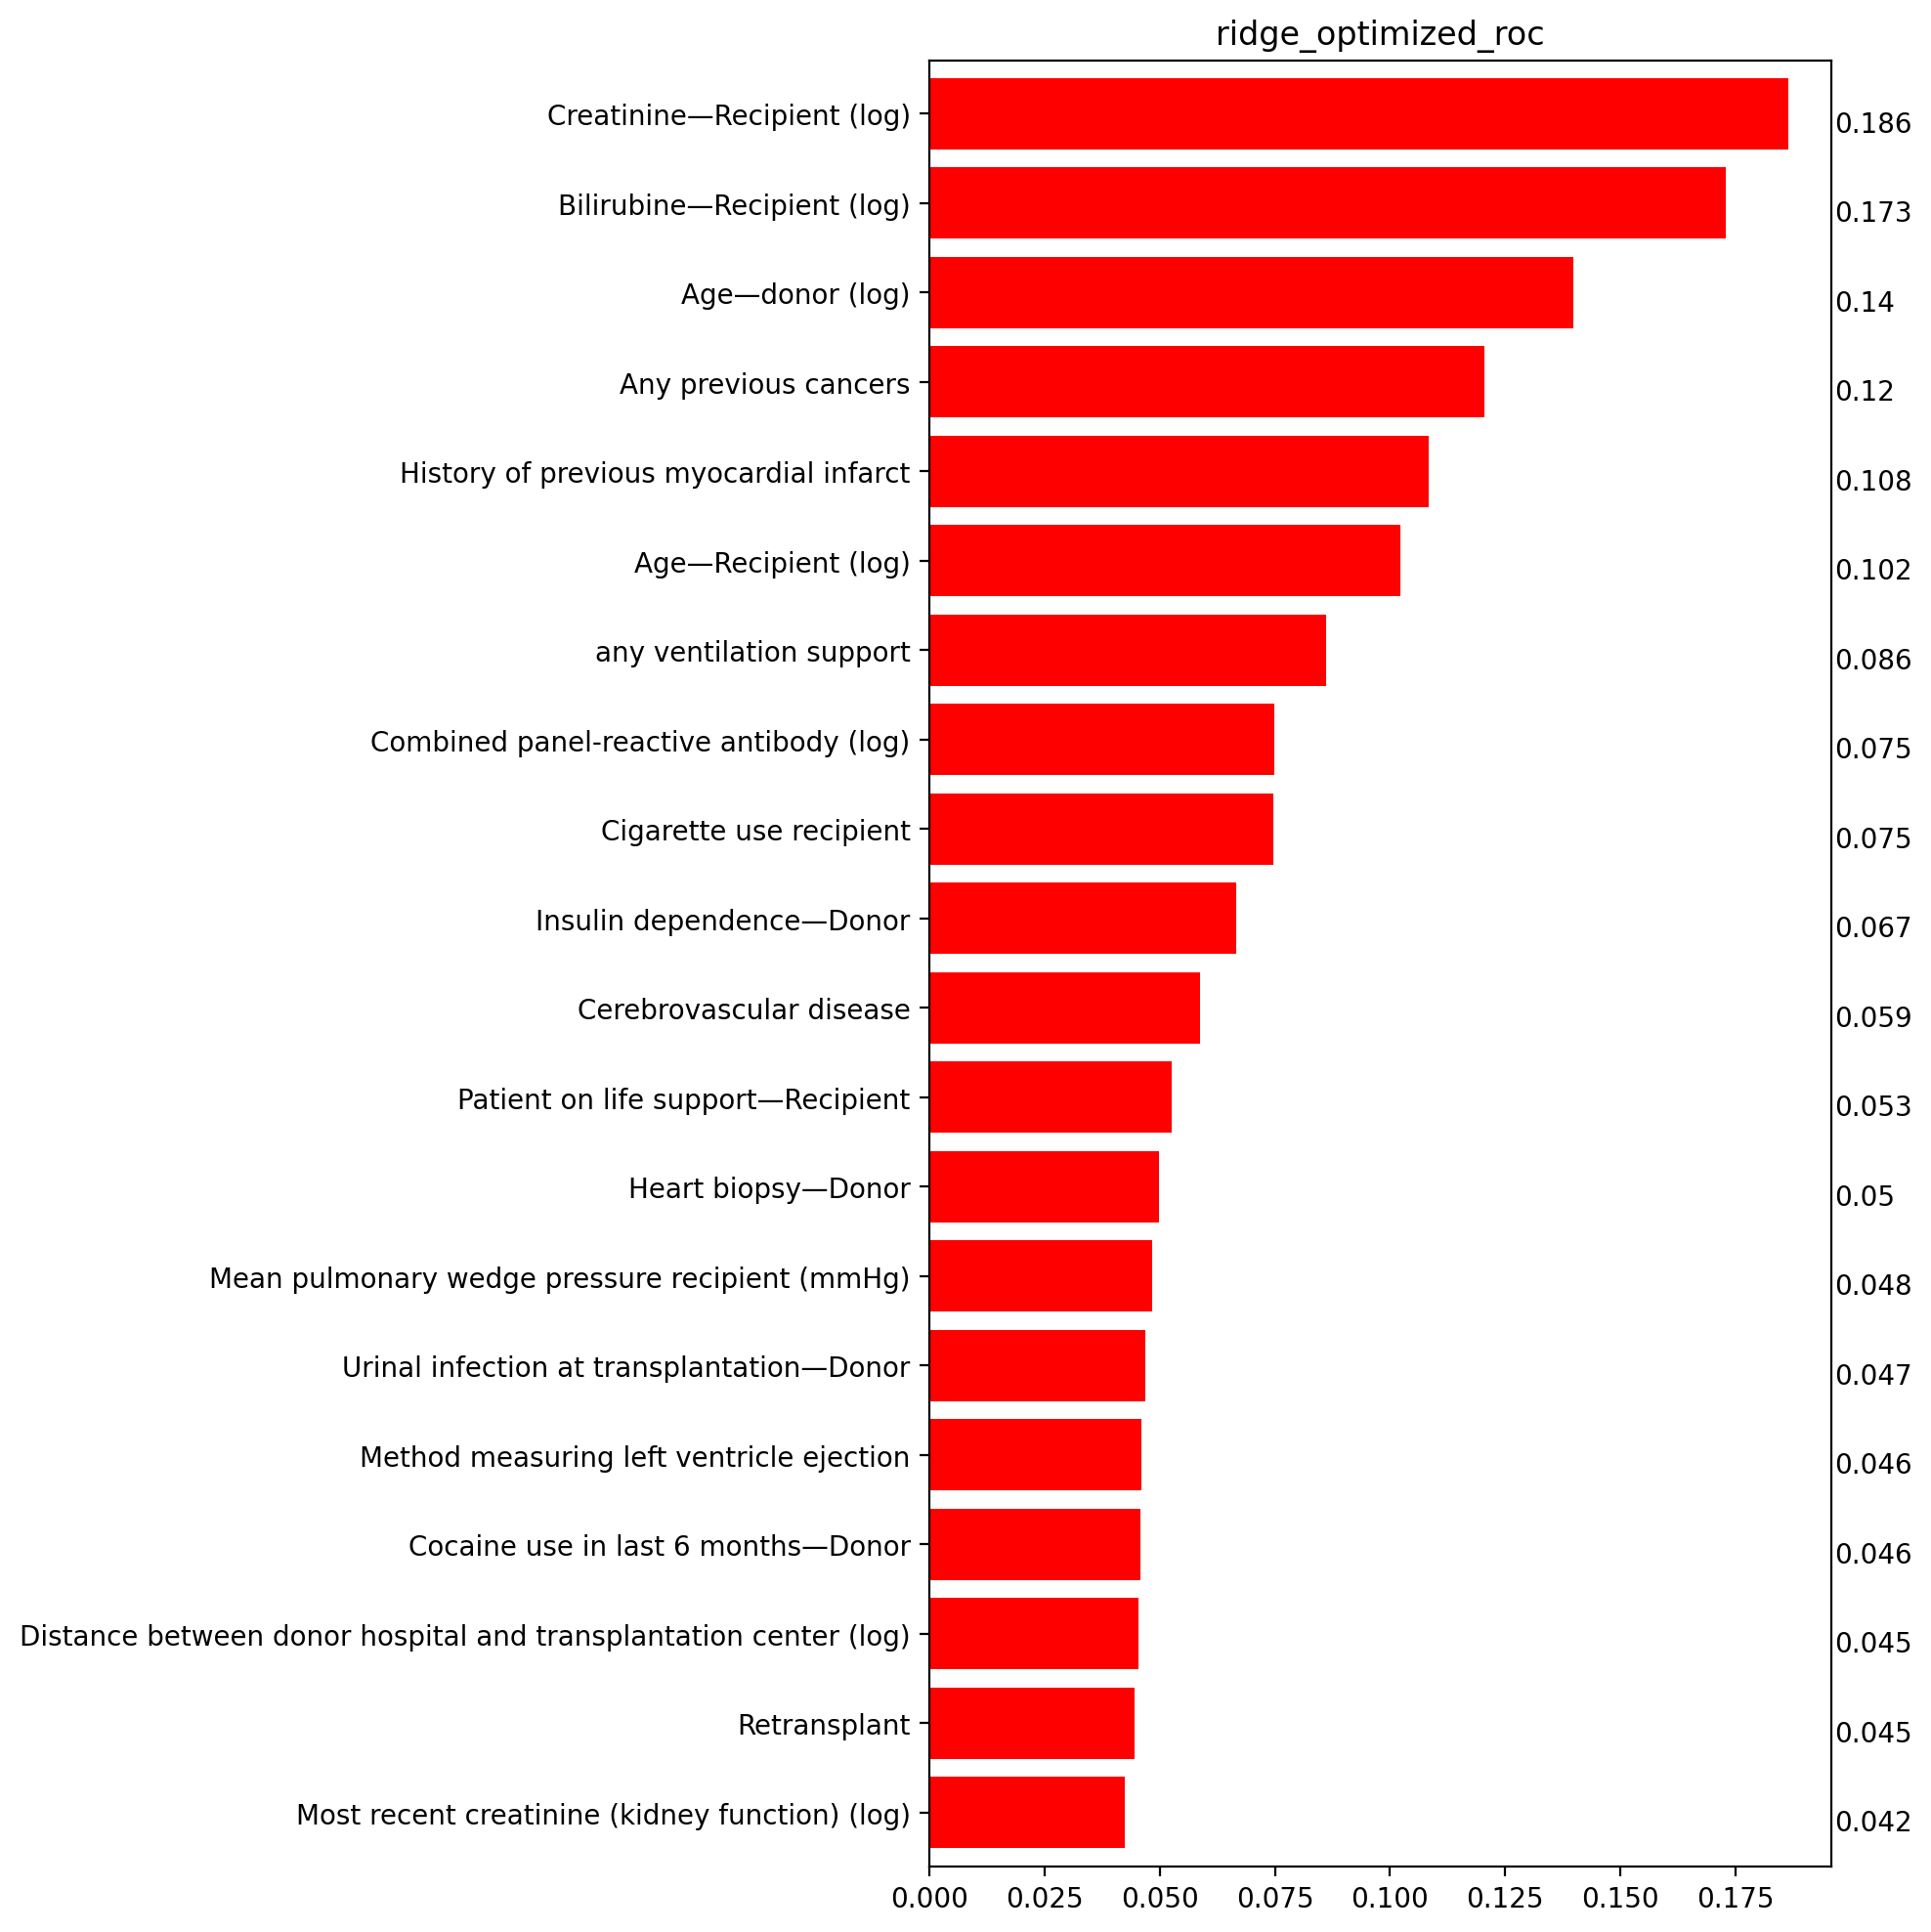

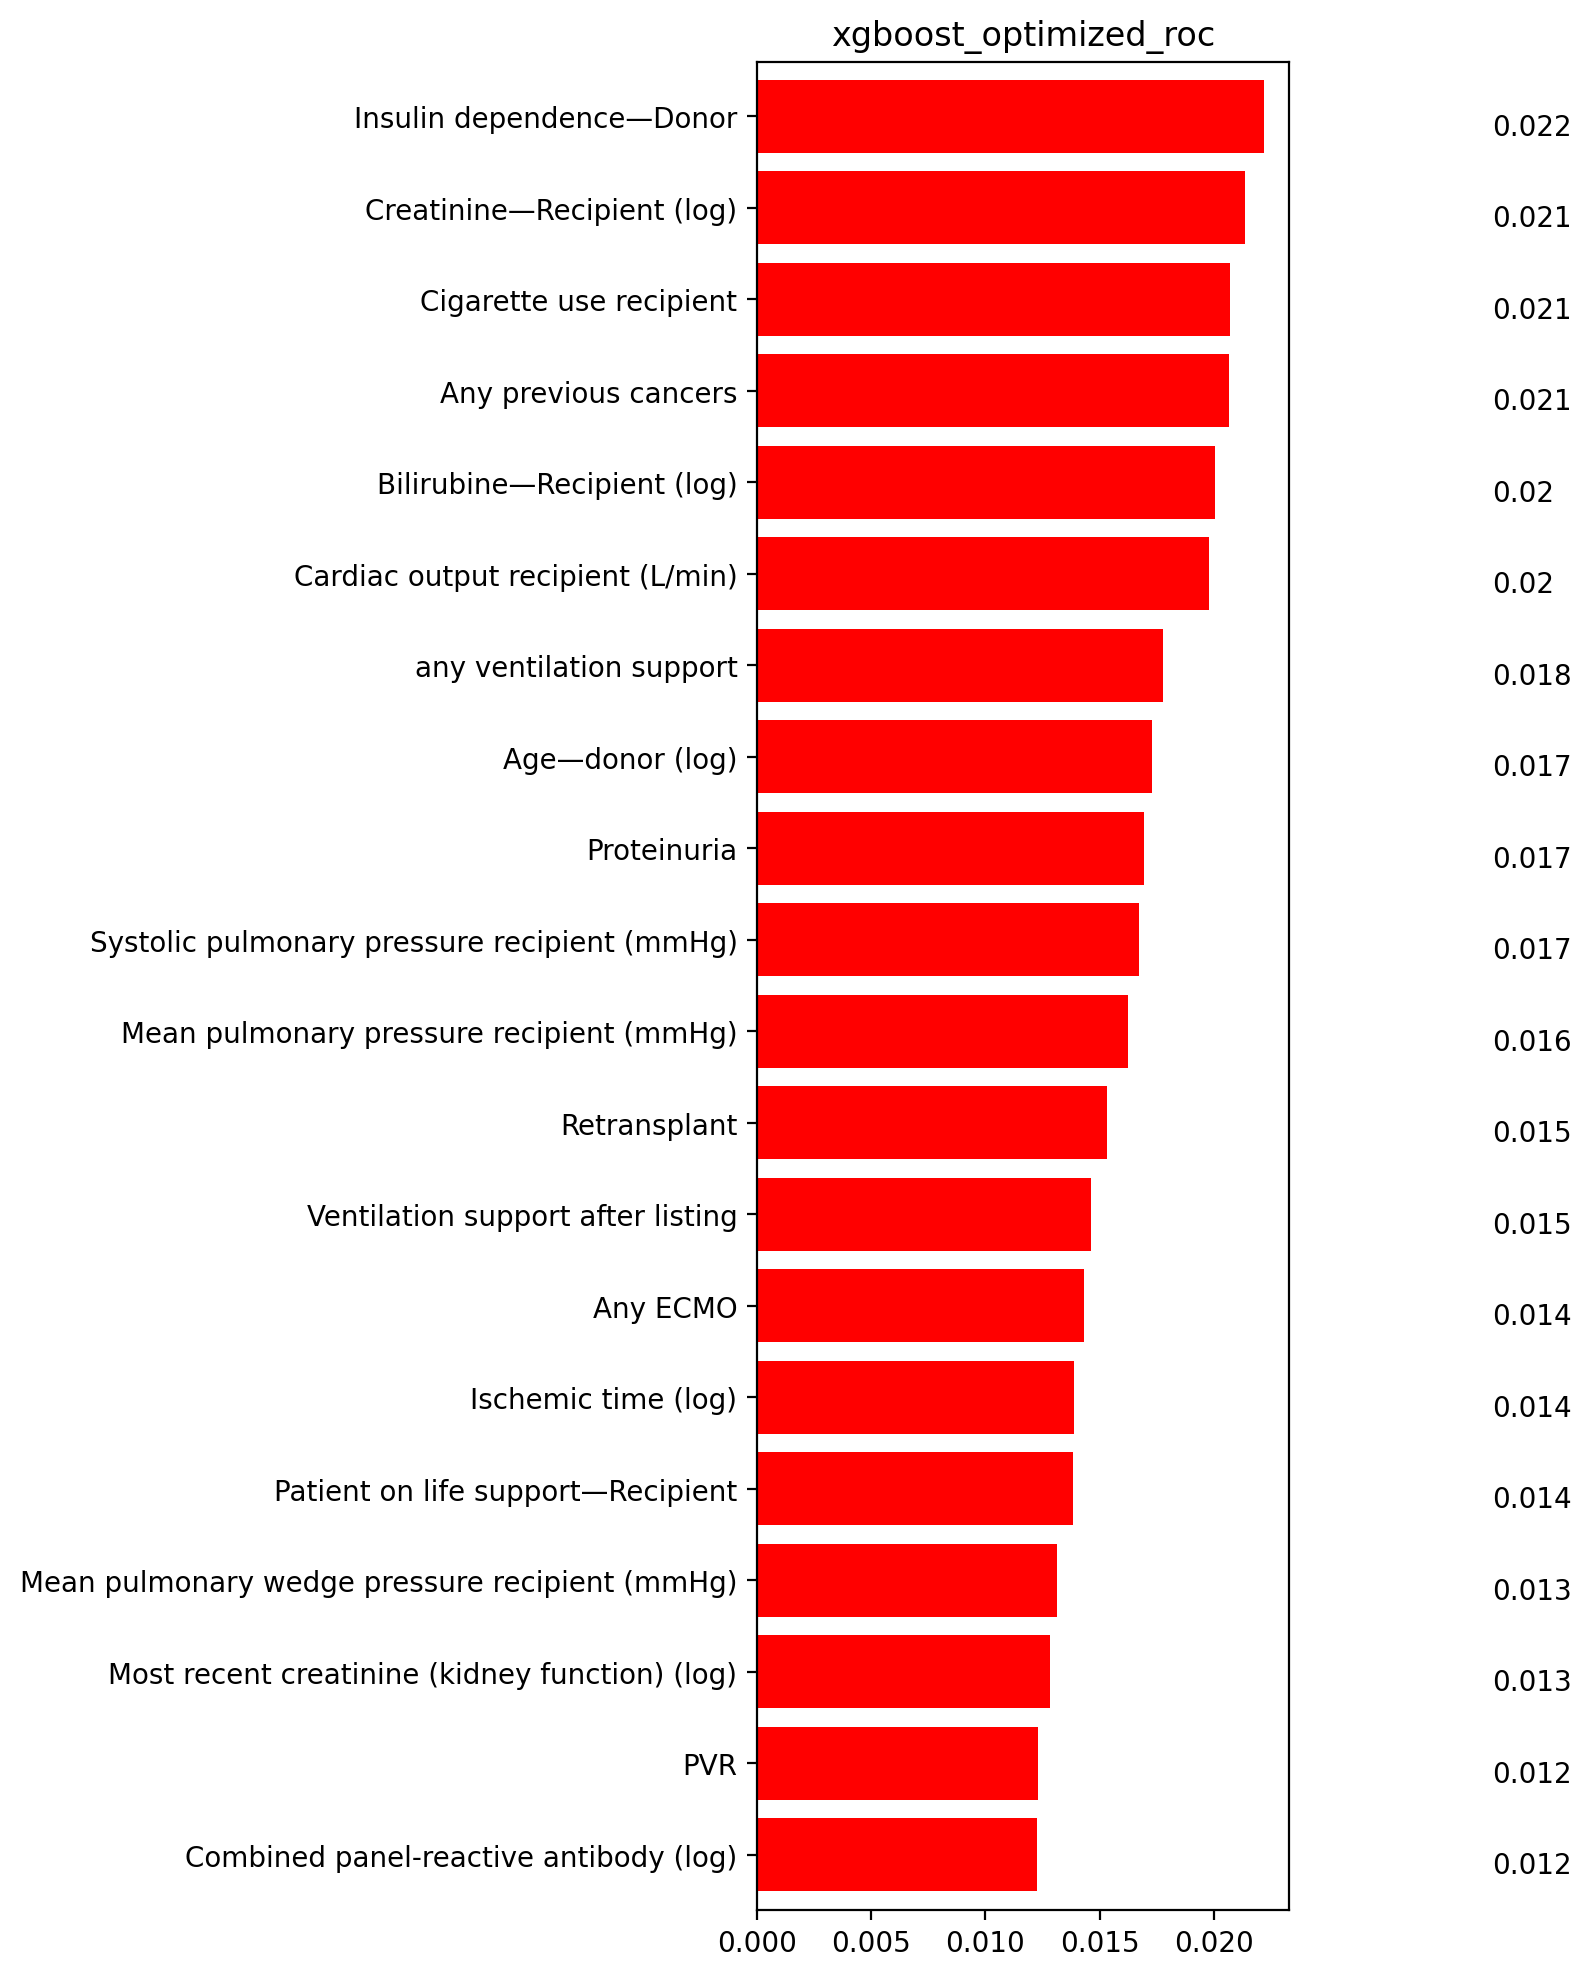

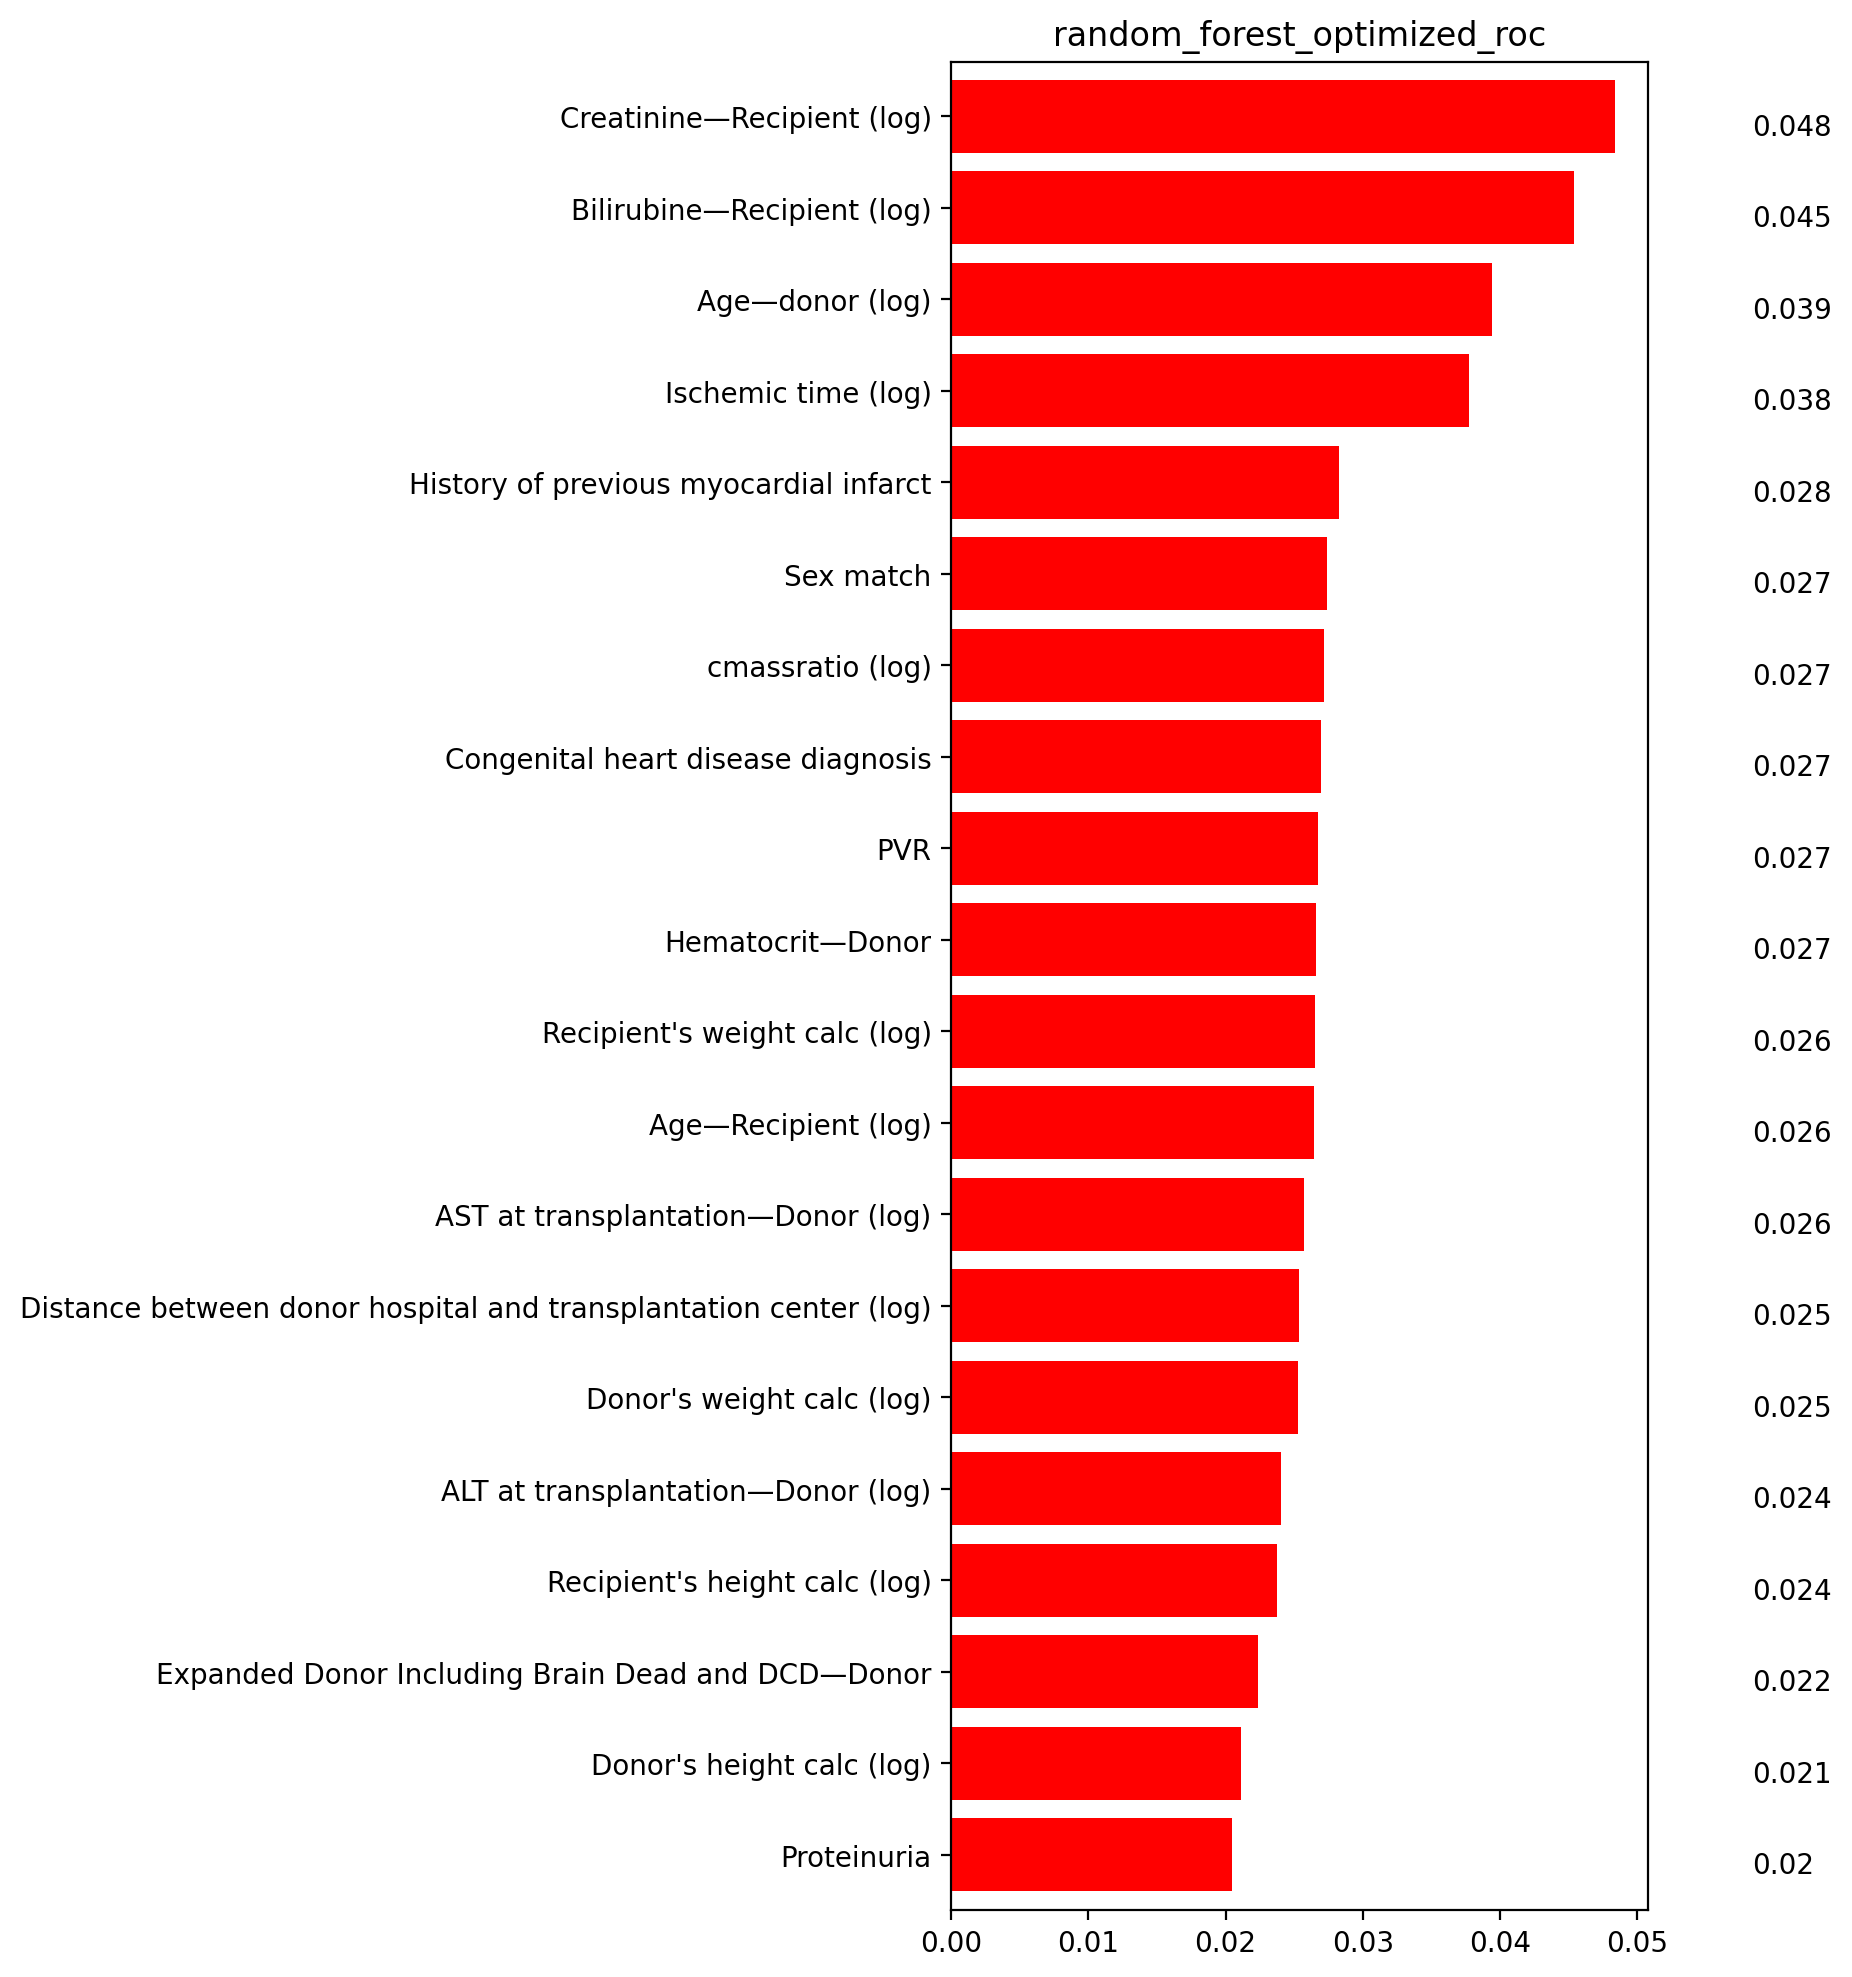

In [16]:
present_feature_importance(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_all', filter_callback=optimized_filter)

#### < 18 years old

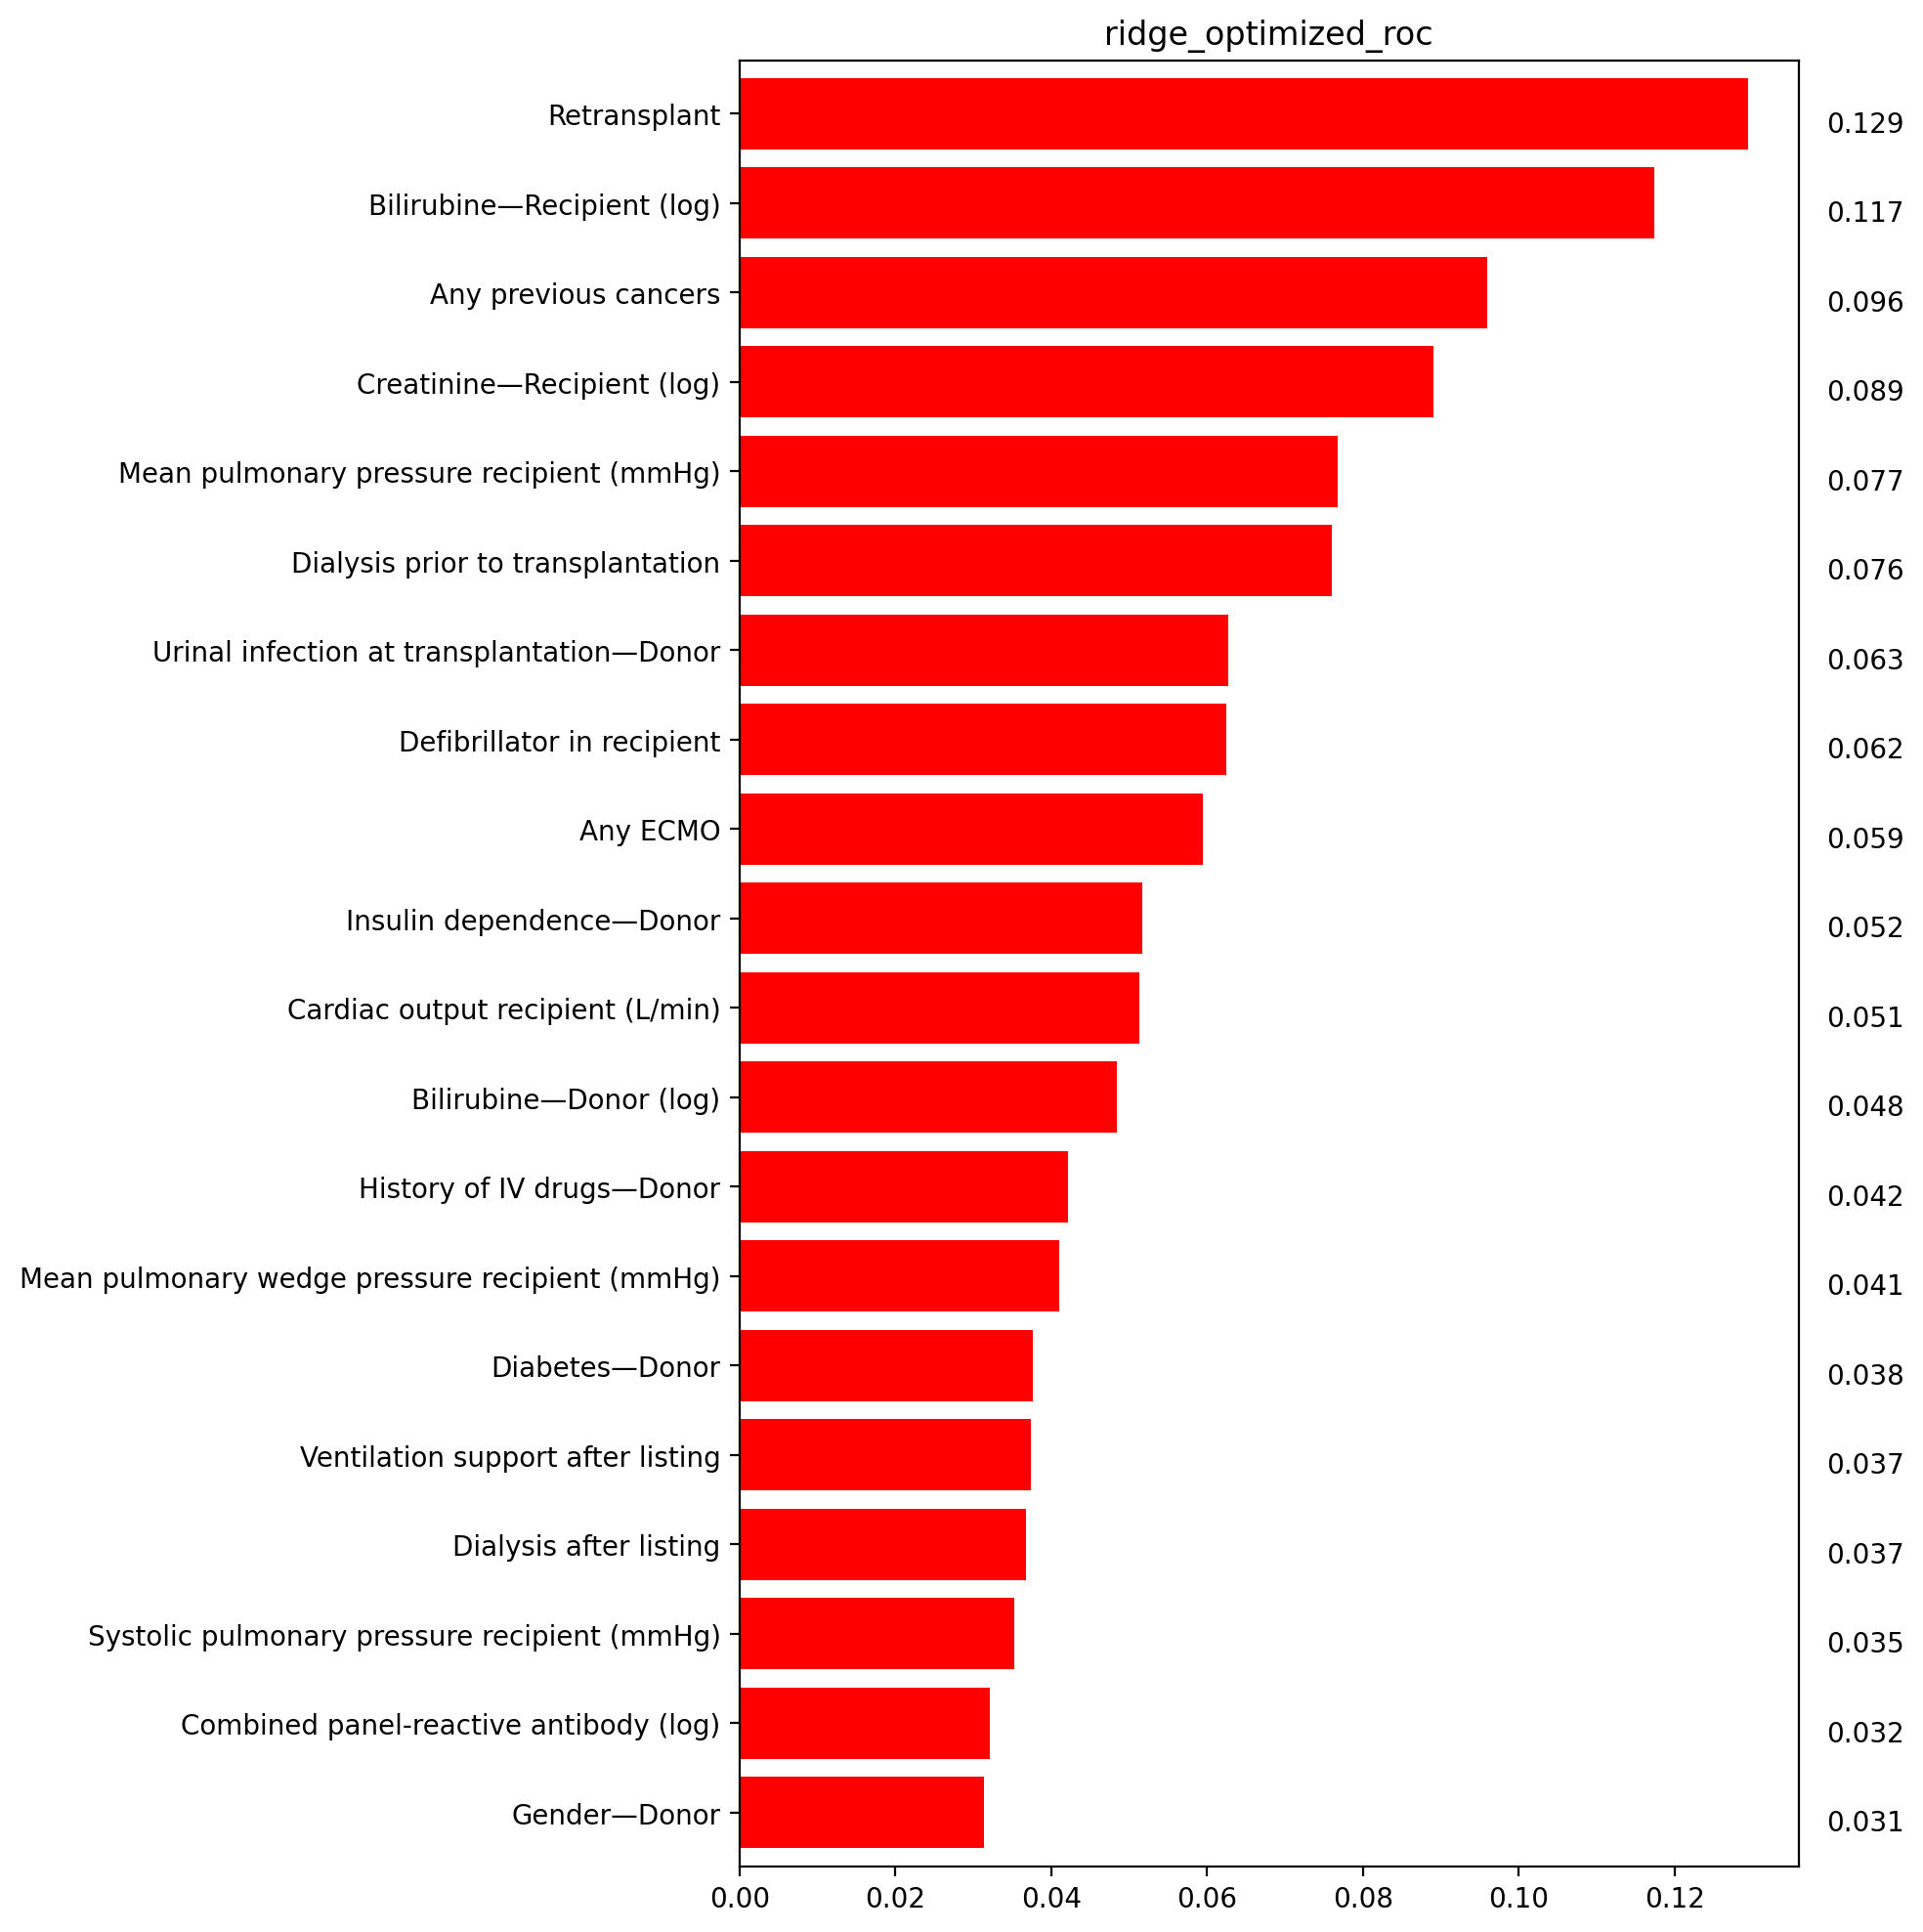

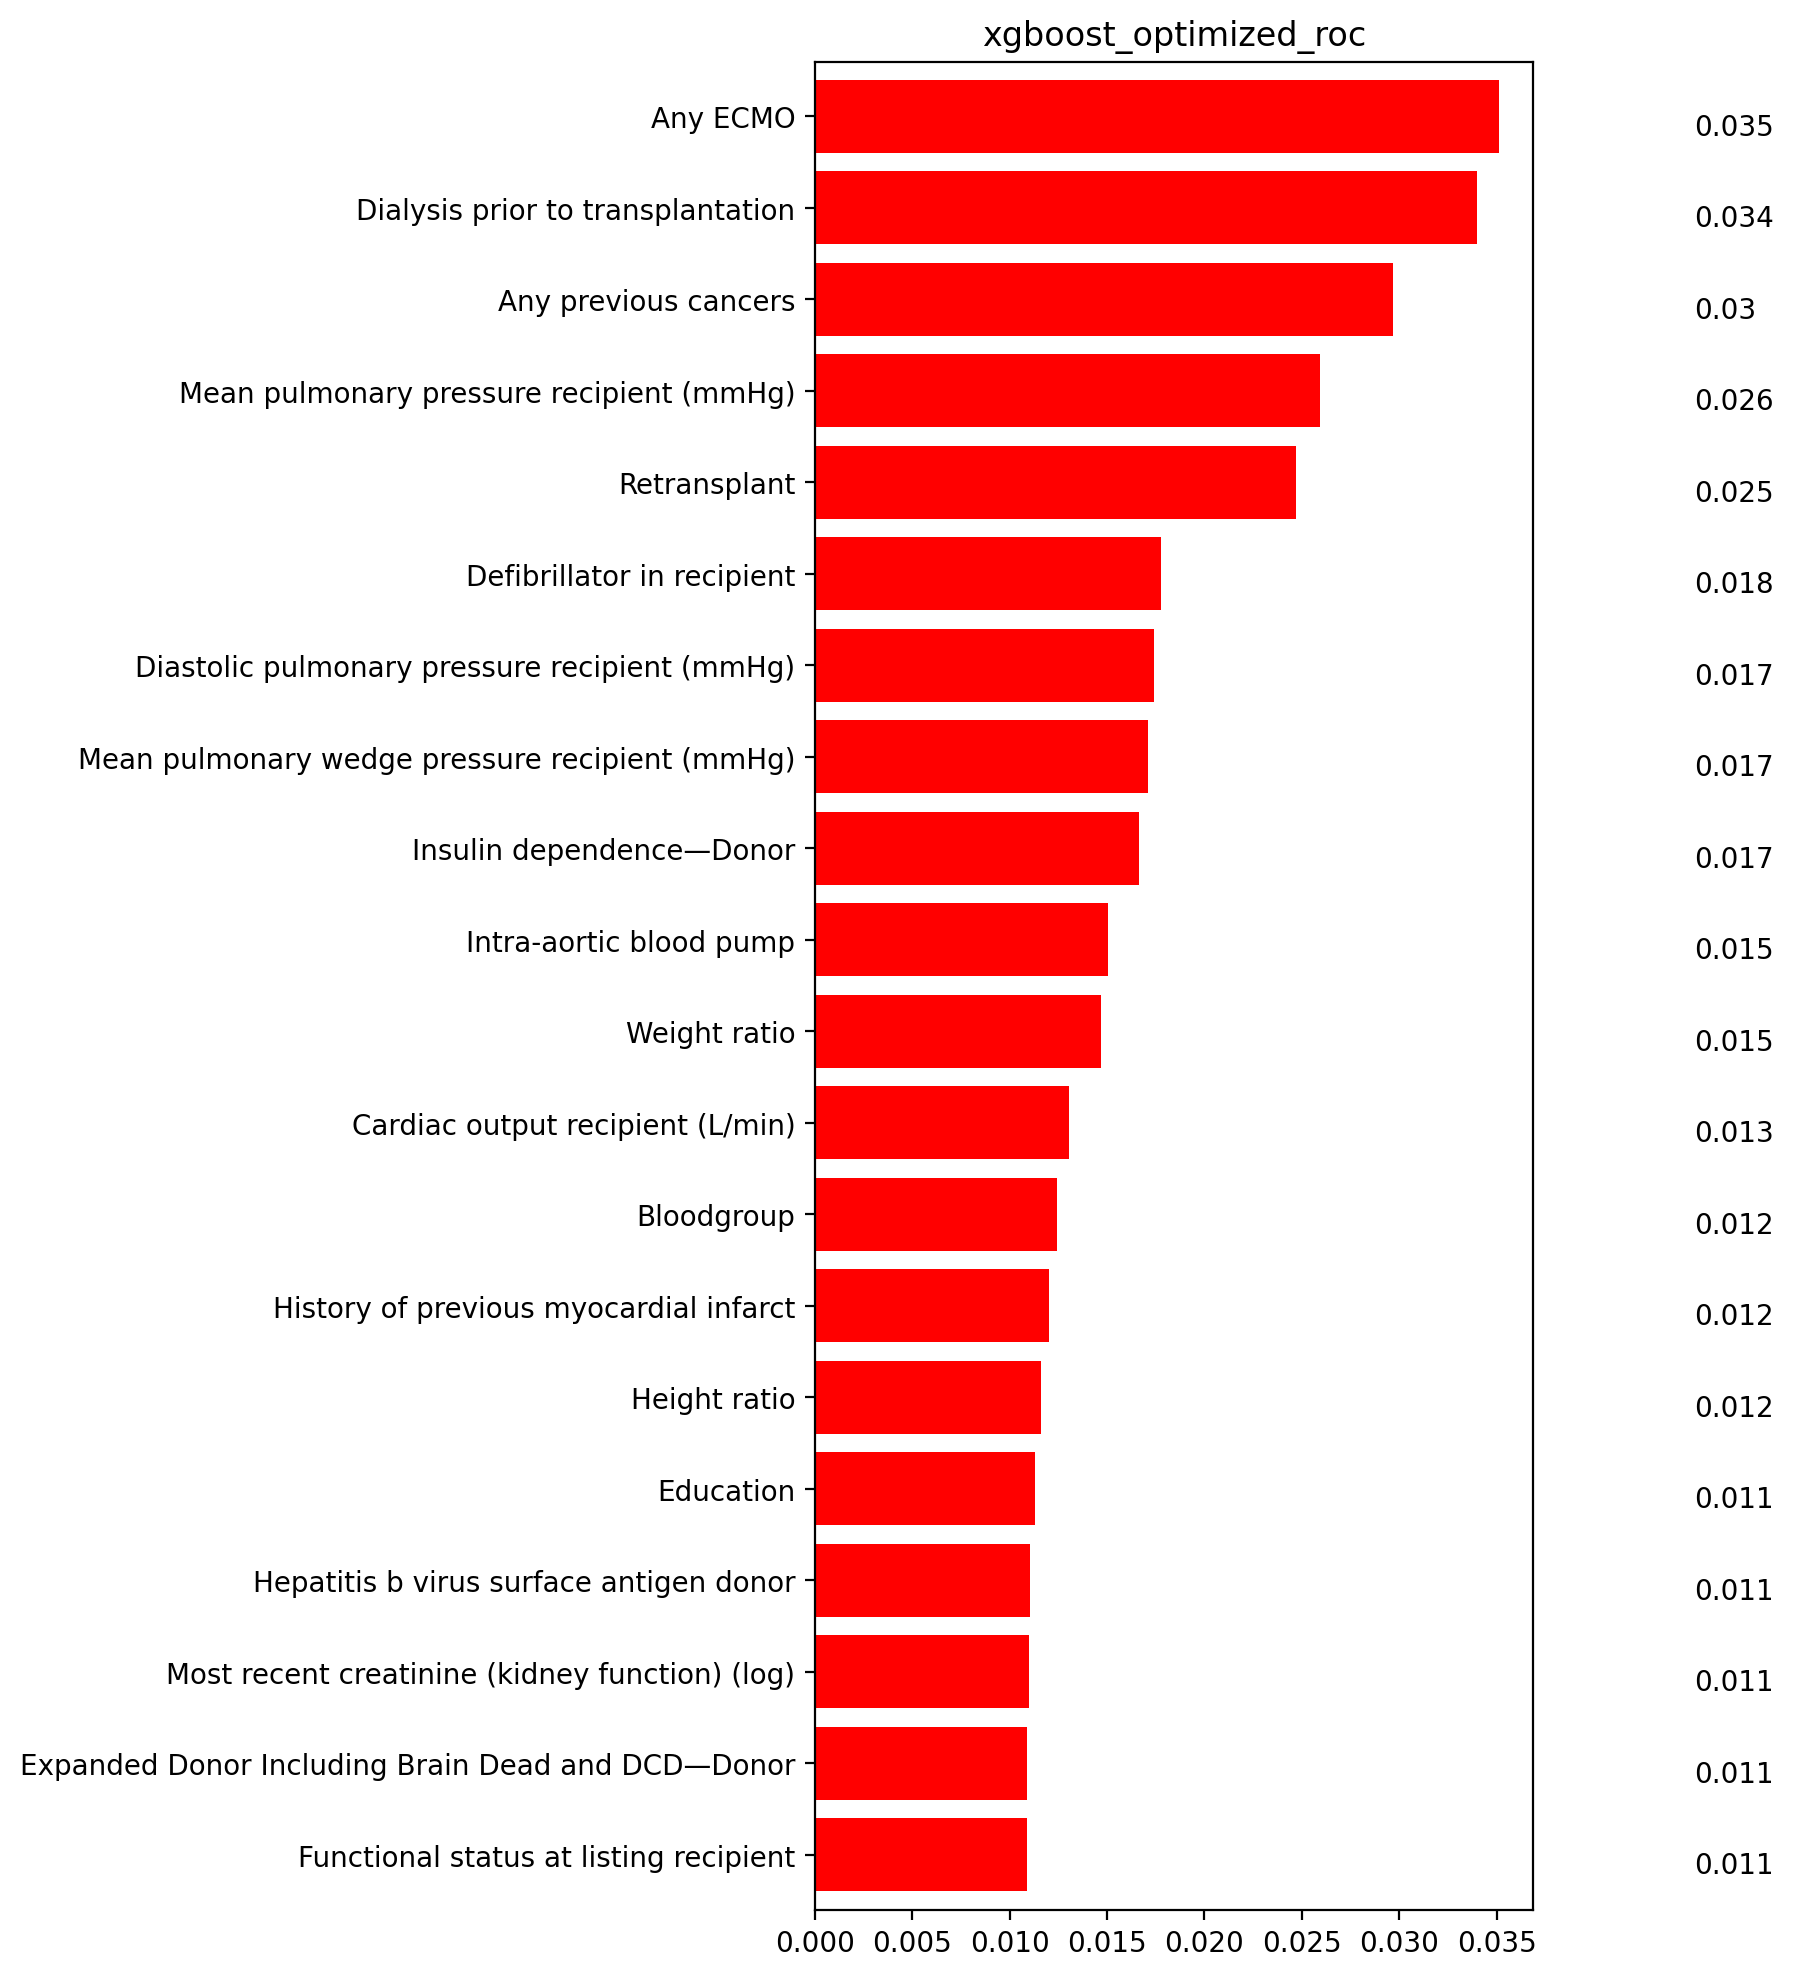

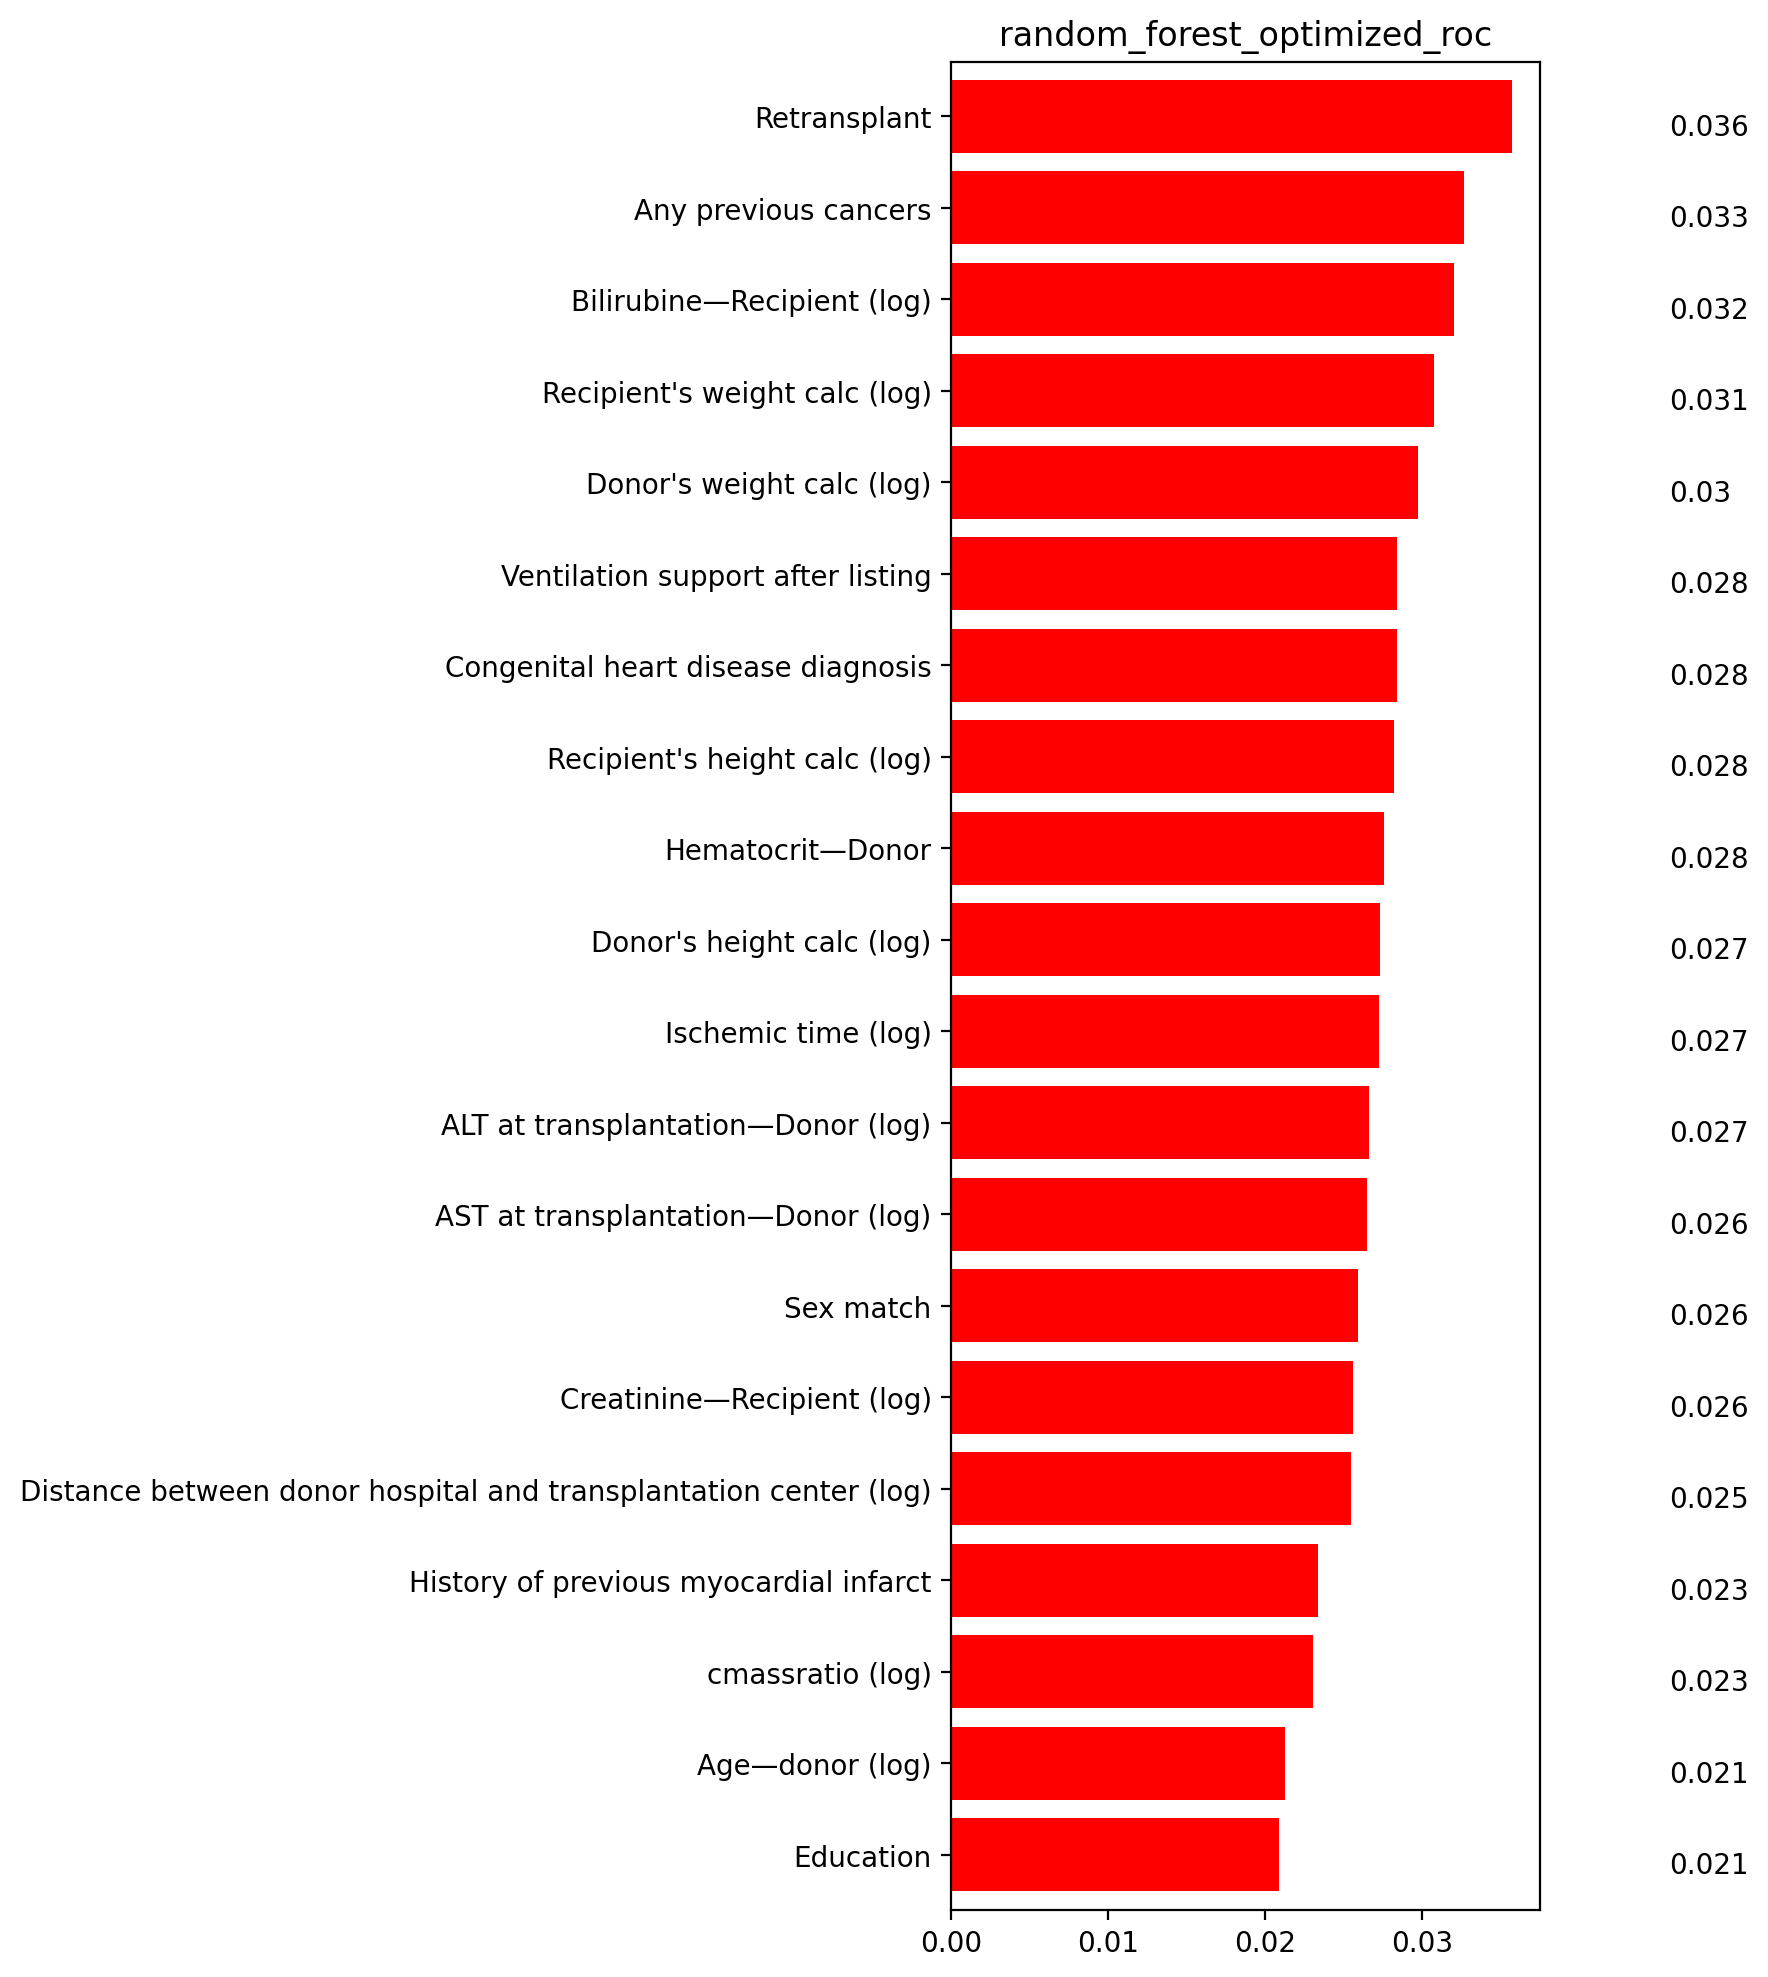

In [17]:
present_feature_importance(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_l_18', filter_callback=optimized_filter)


#### >= 18 years old

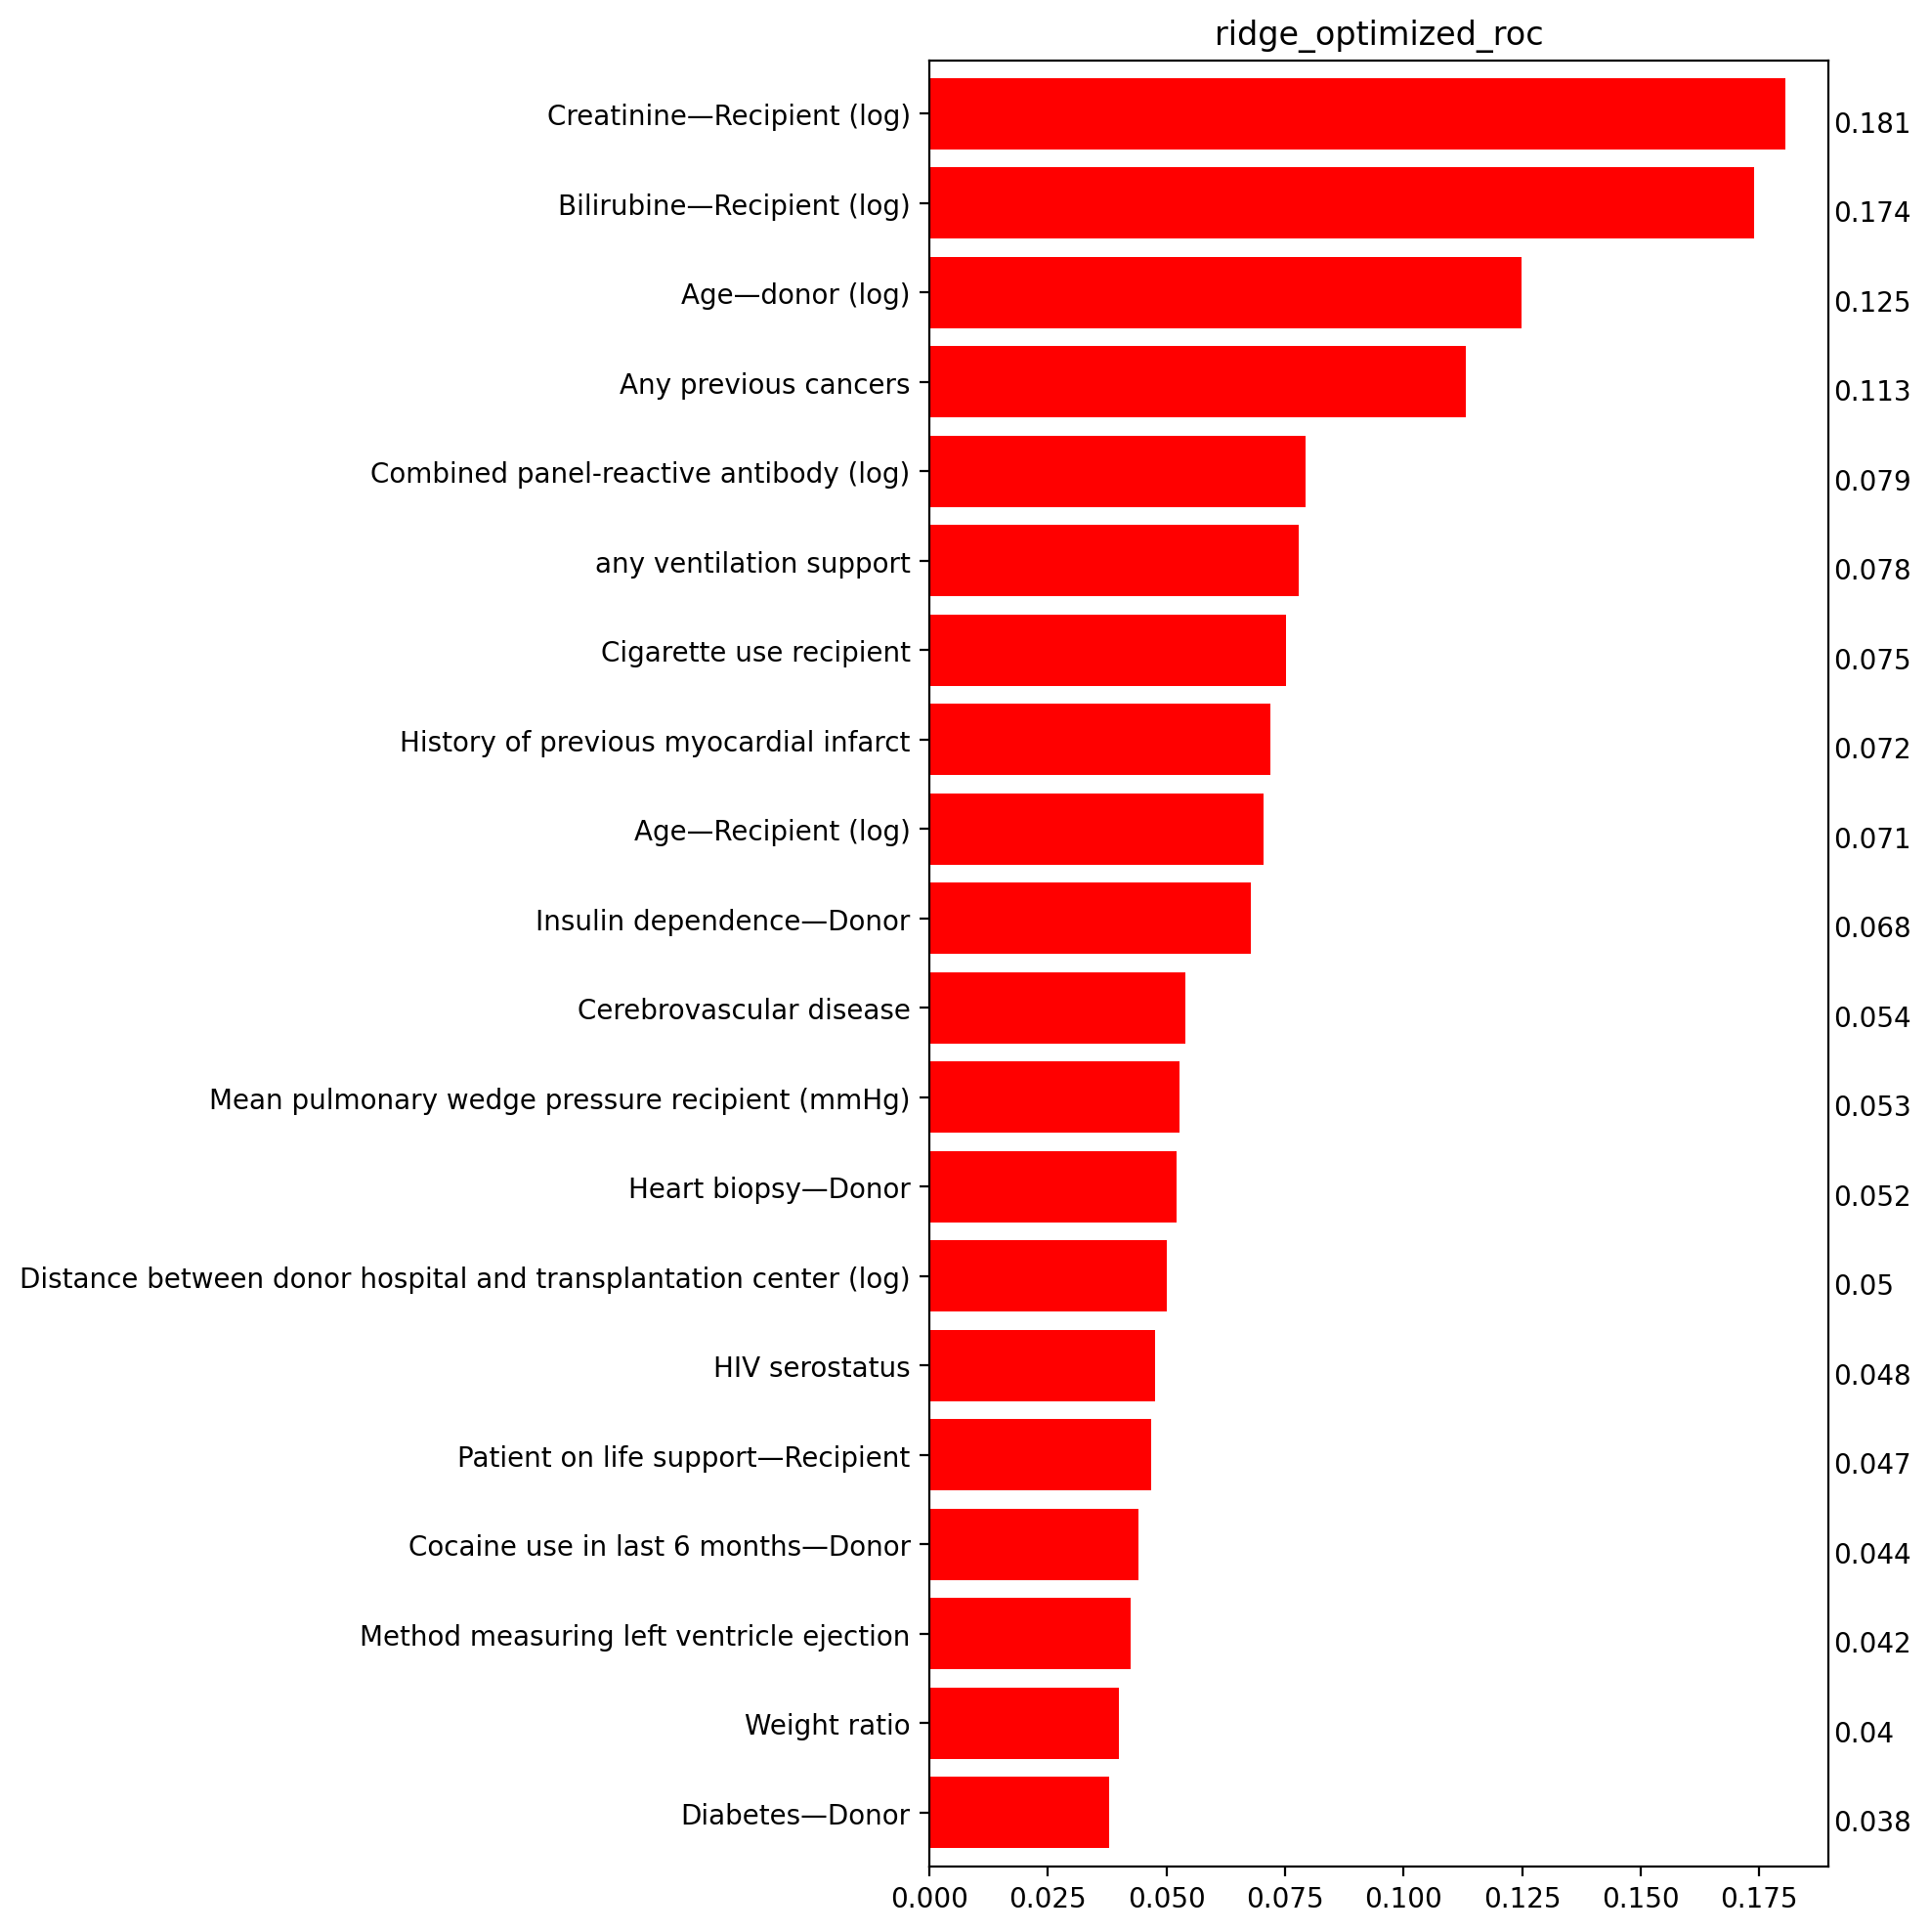

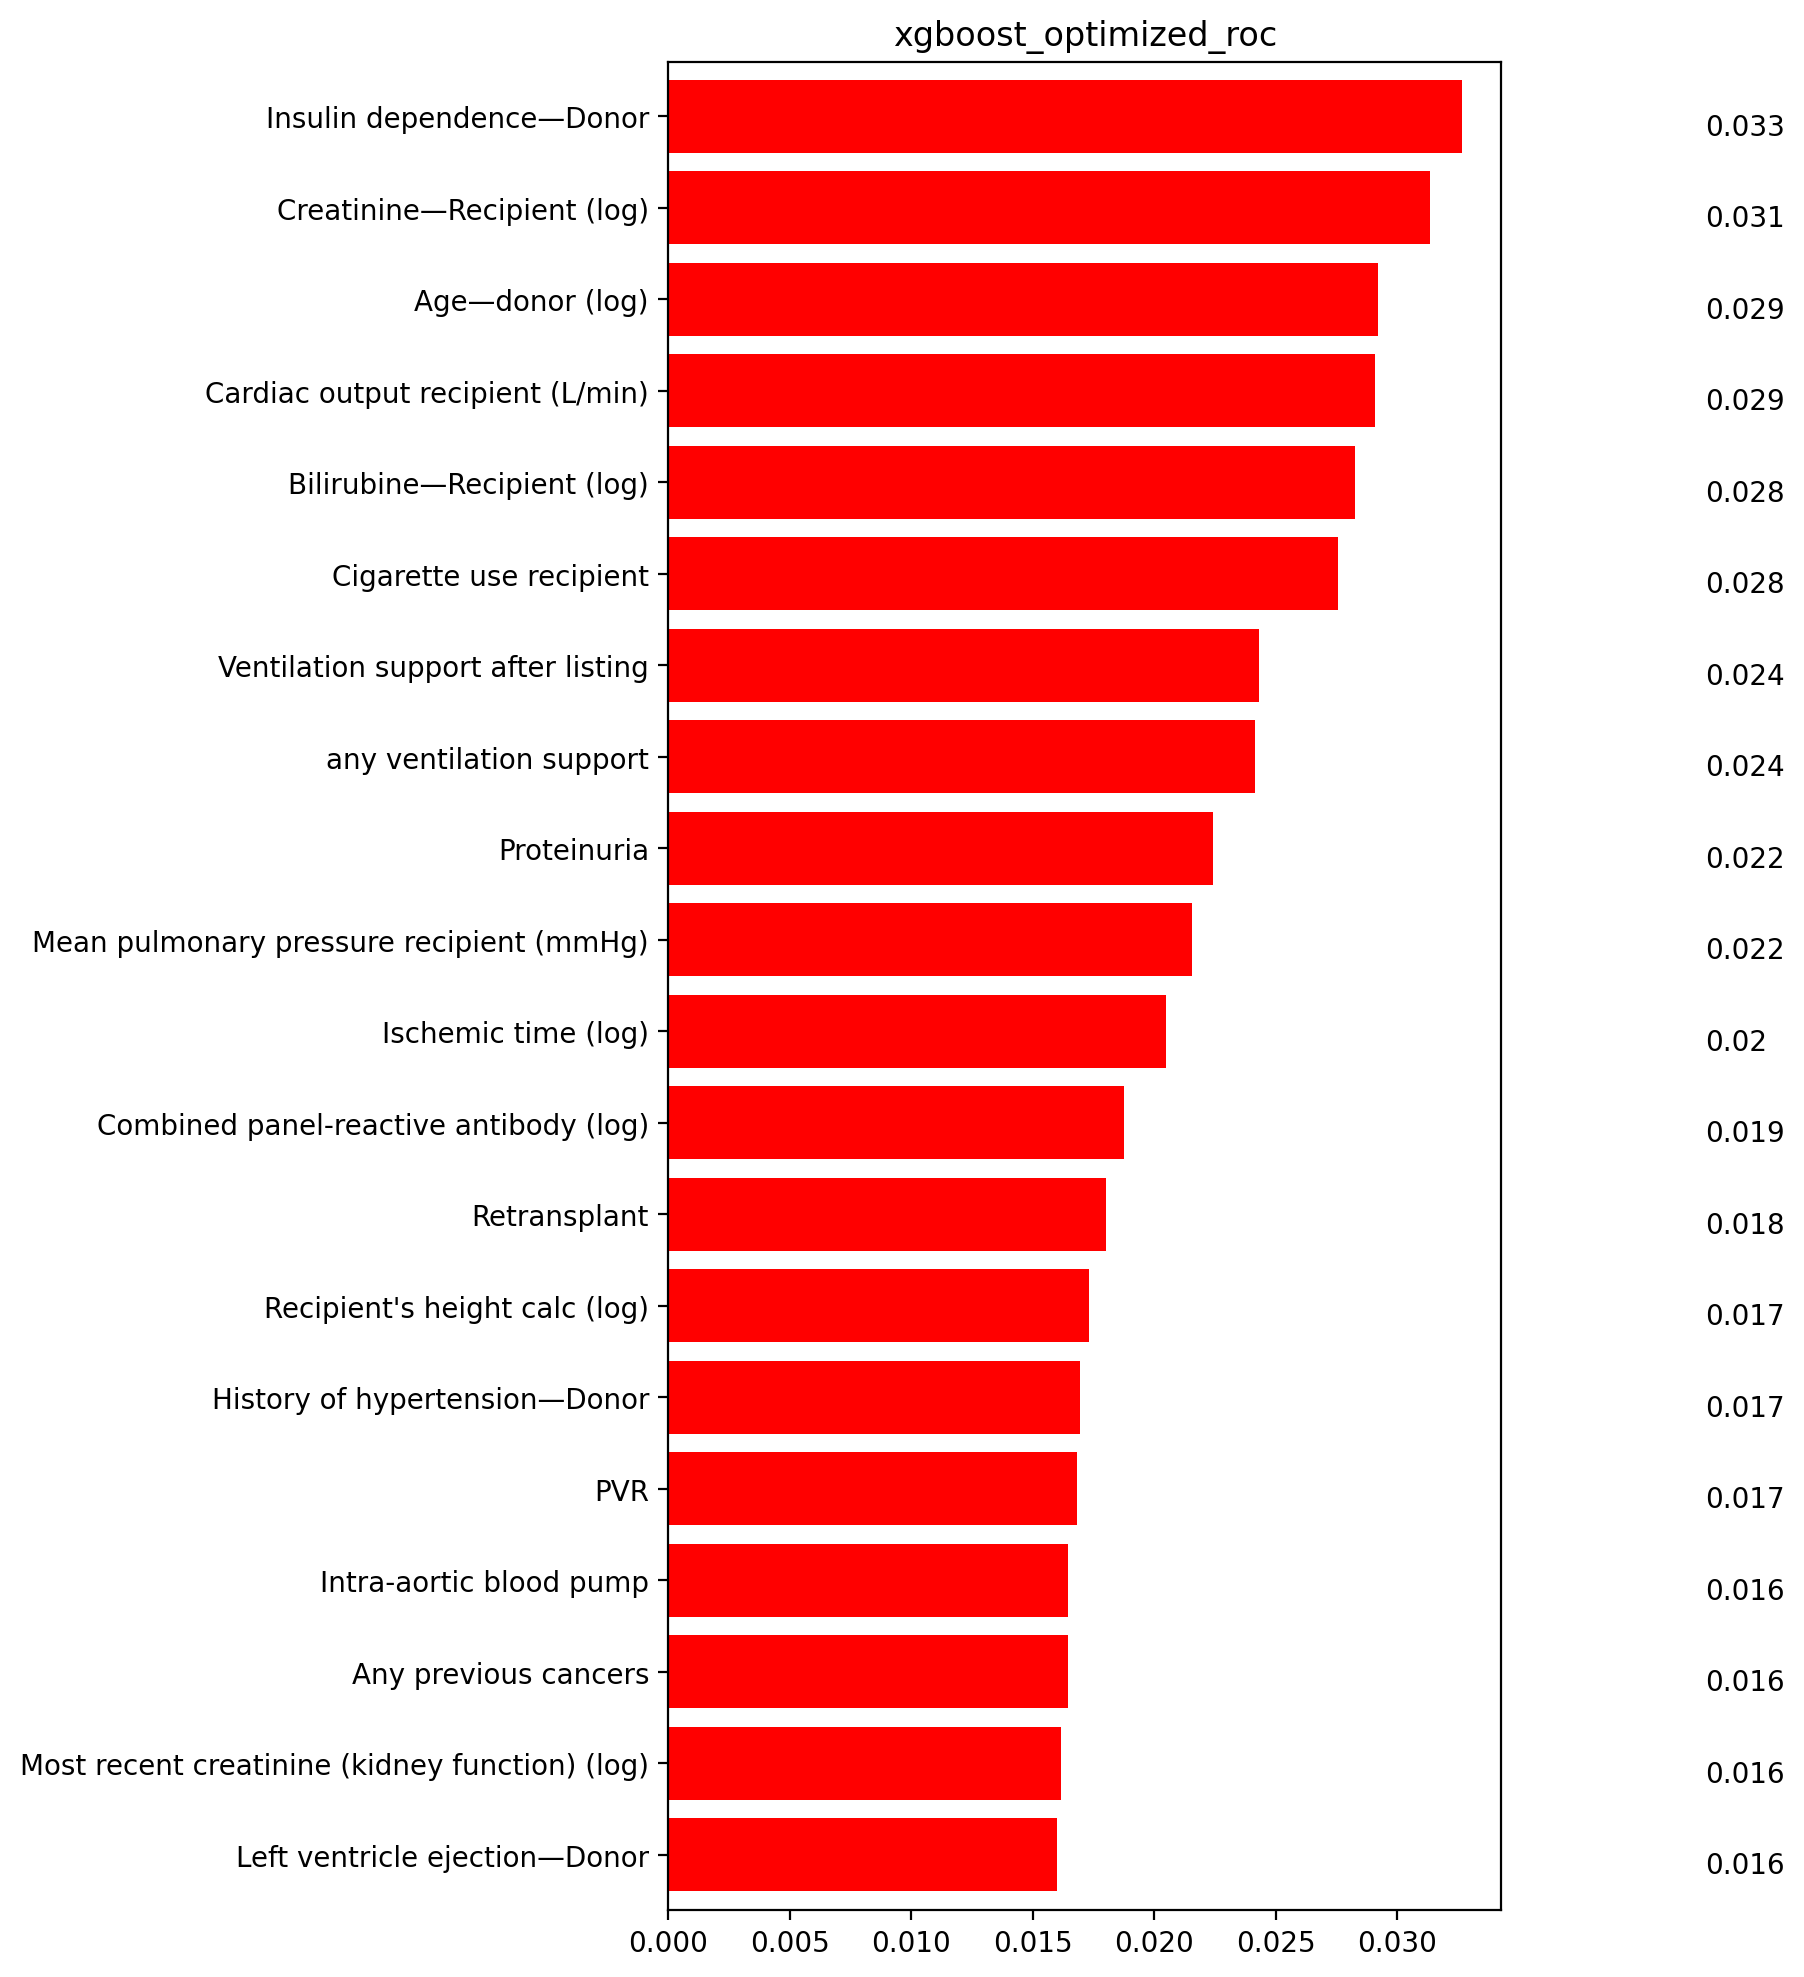

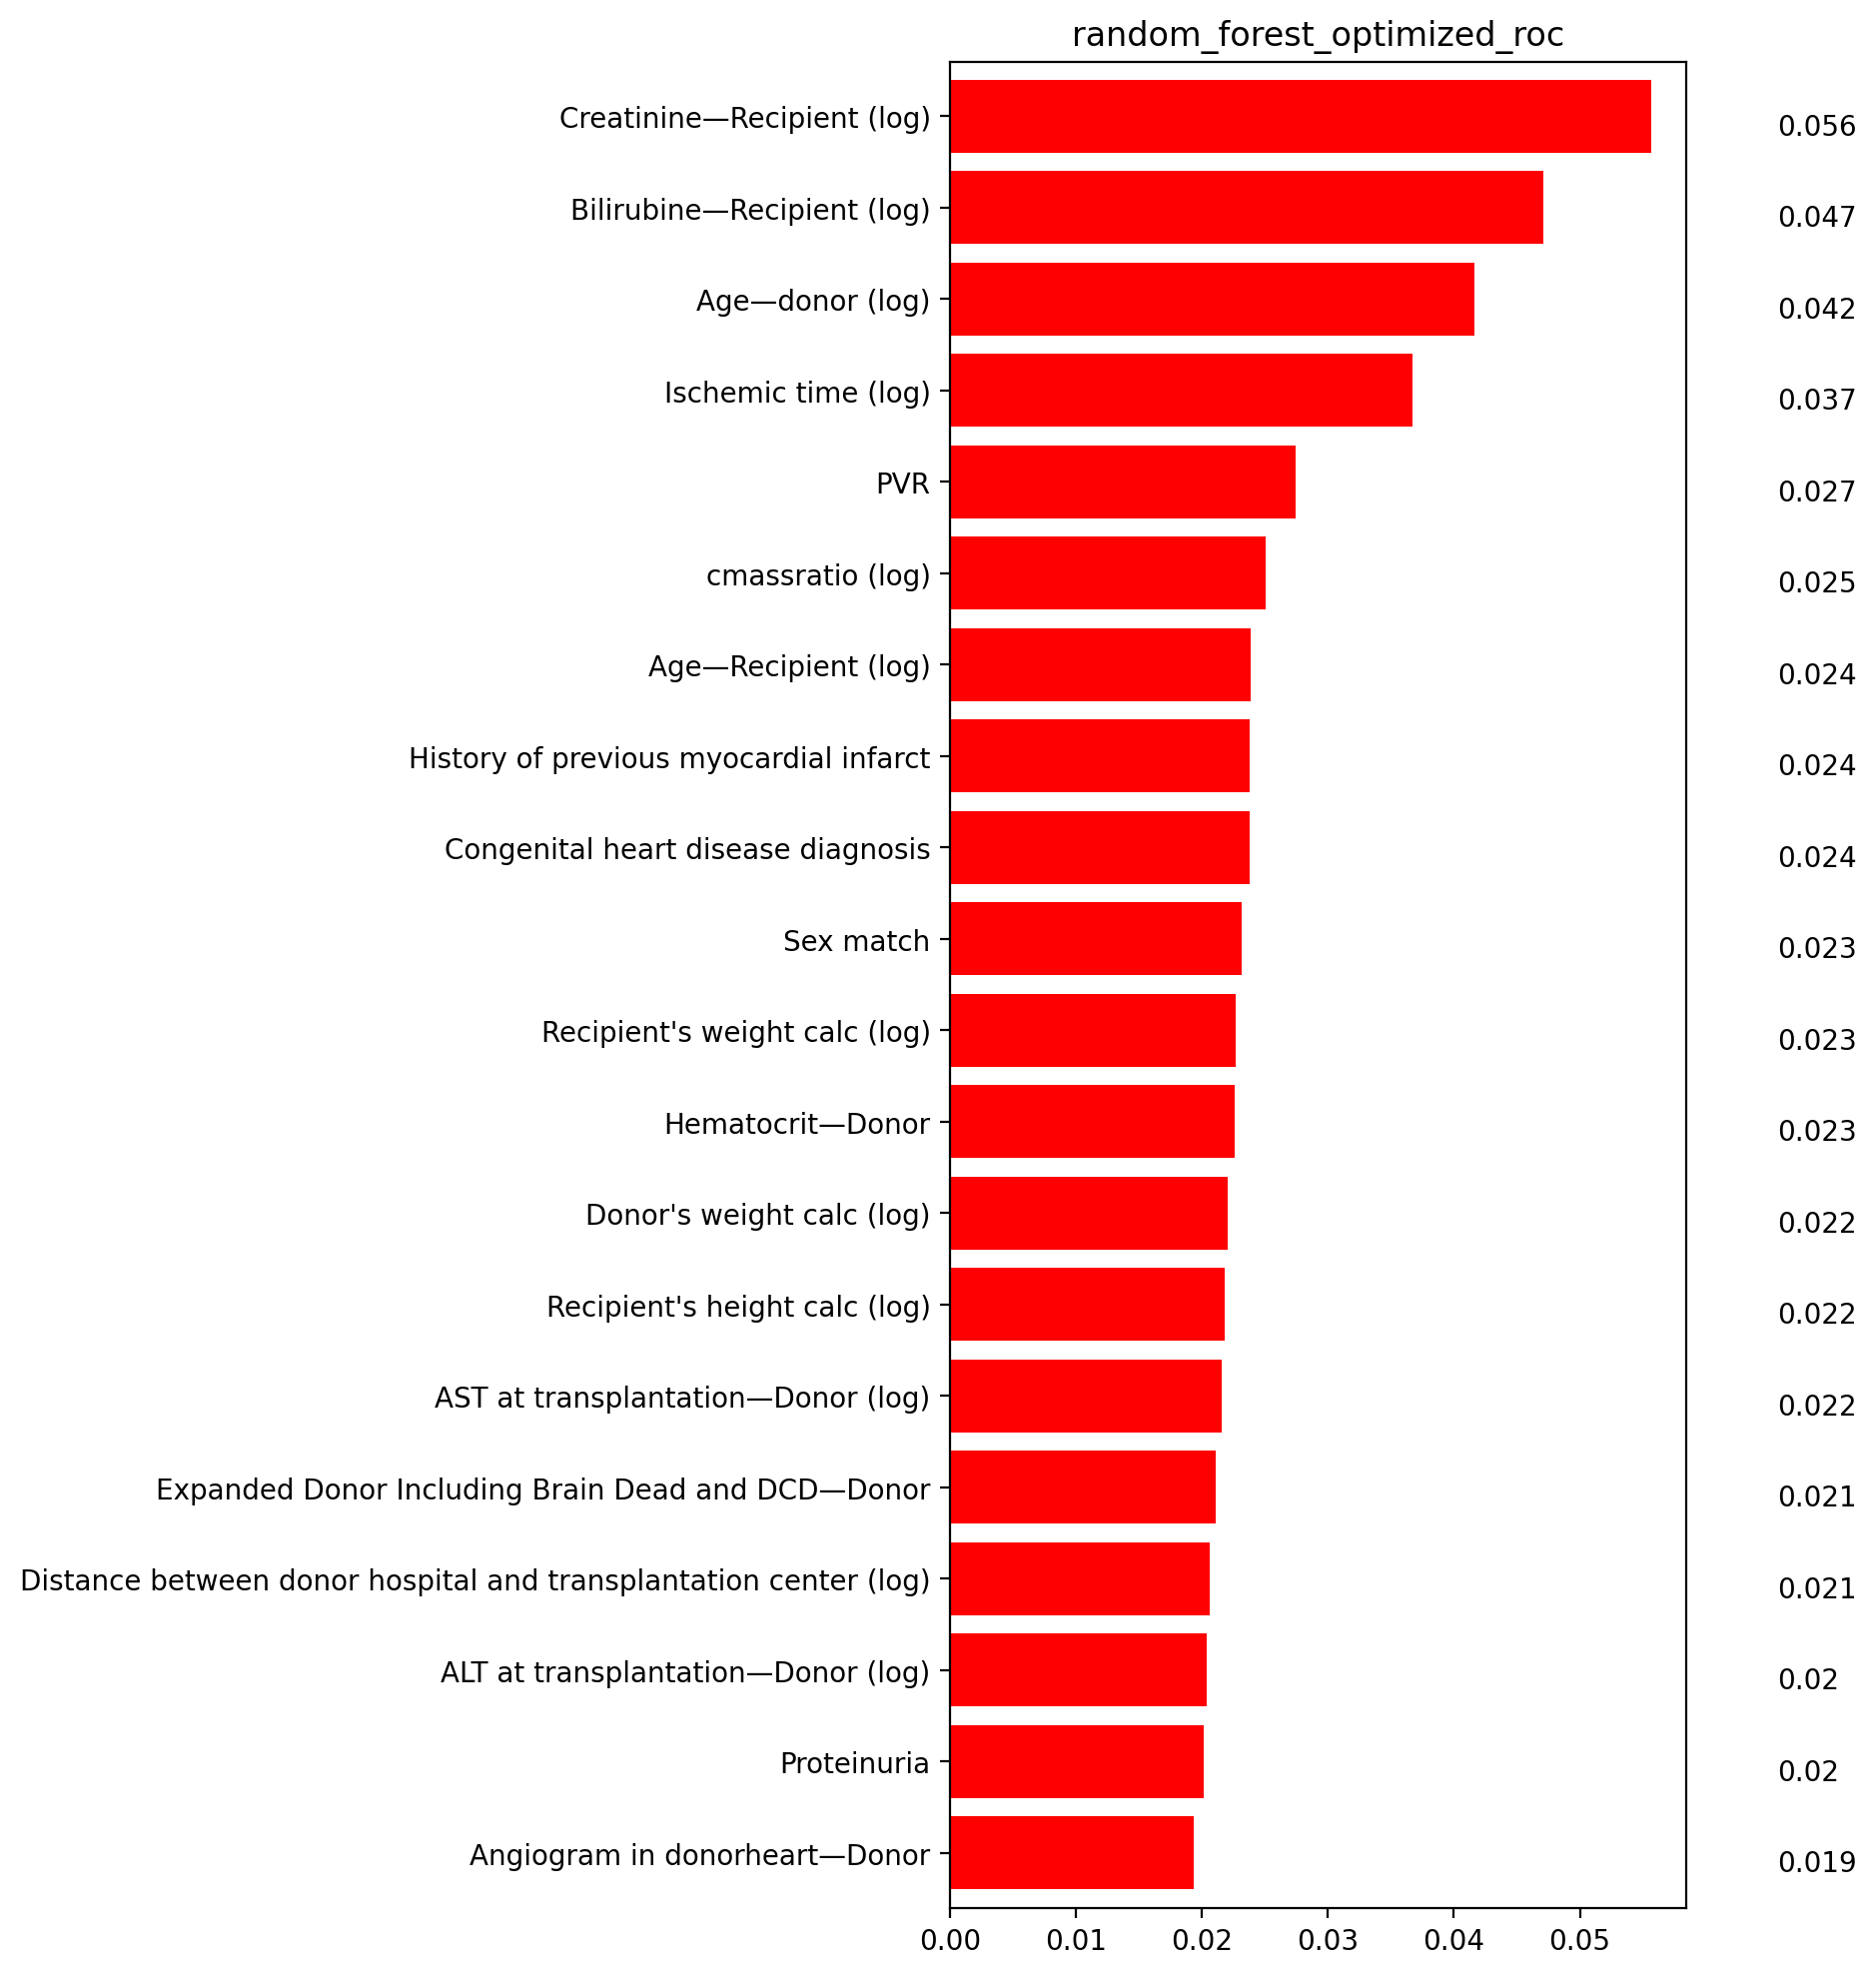

In [18]:
present_feature_importance(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_me_18', filter_callback=optimized_filter)


### 90 days

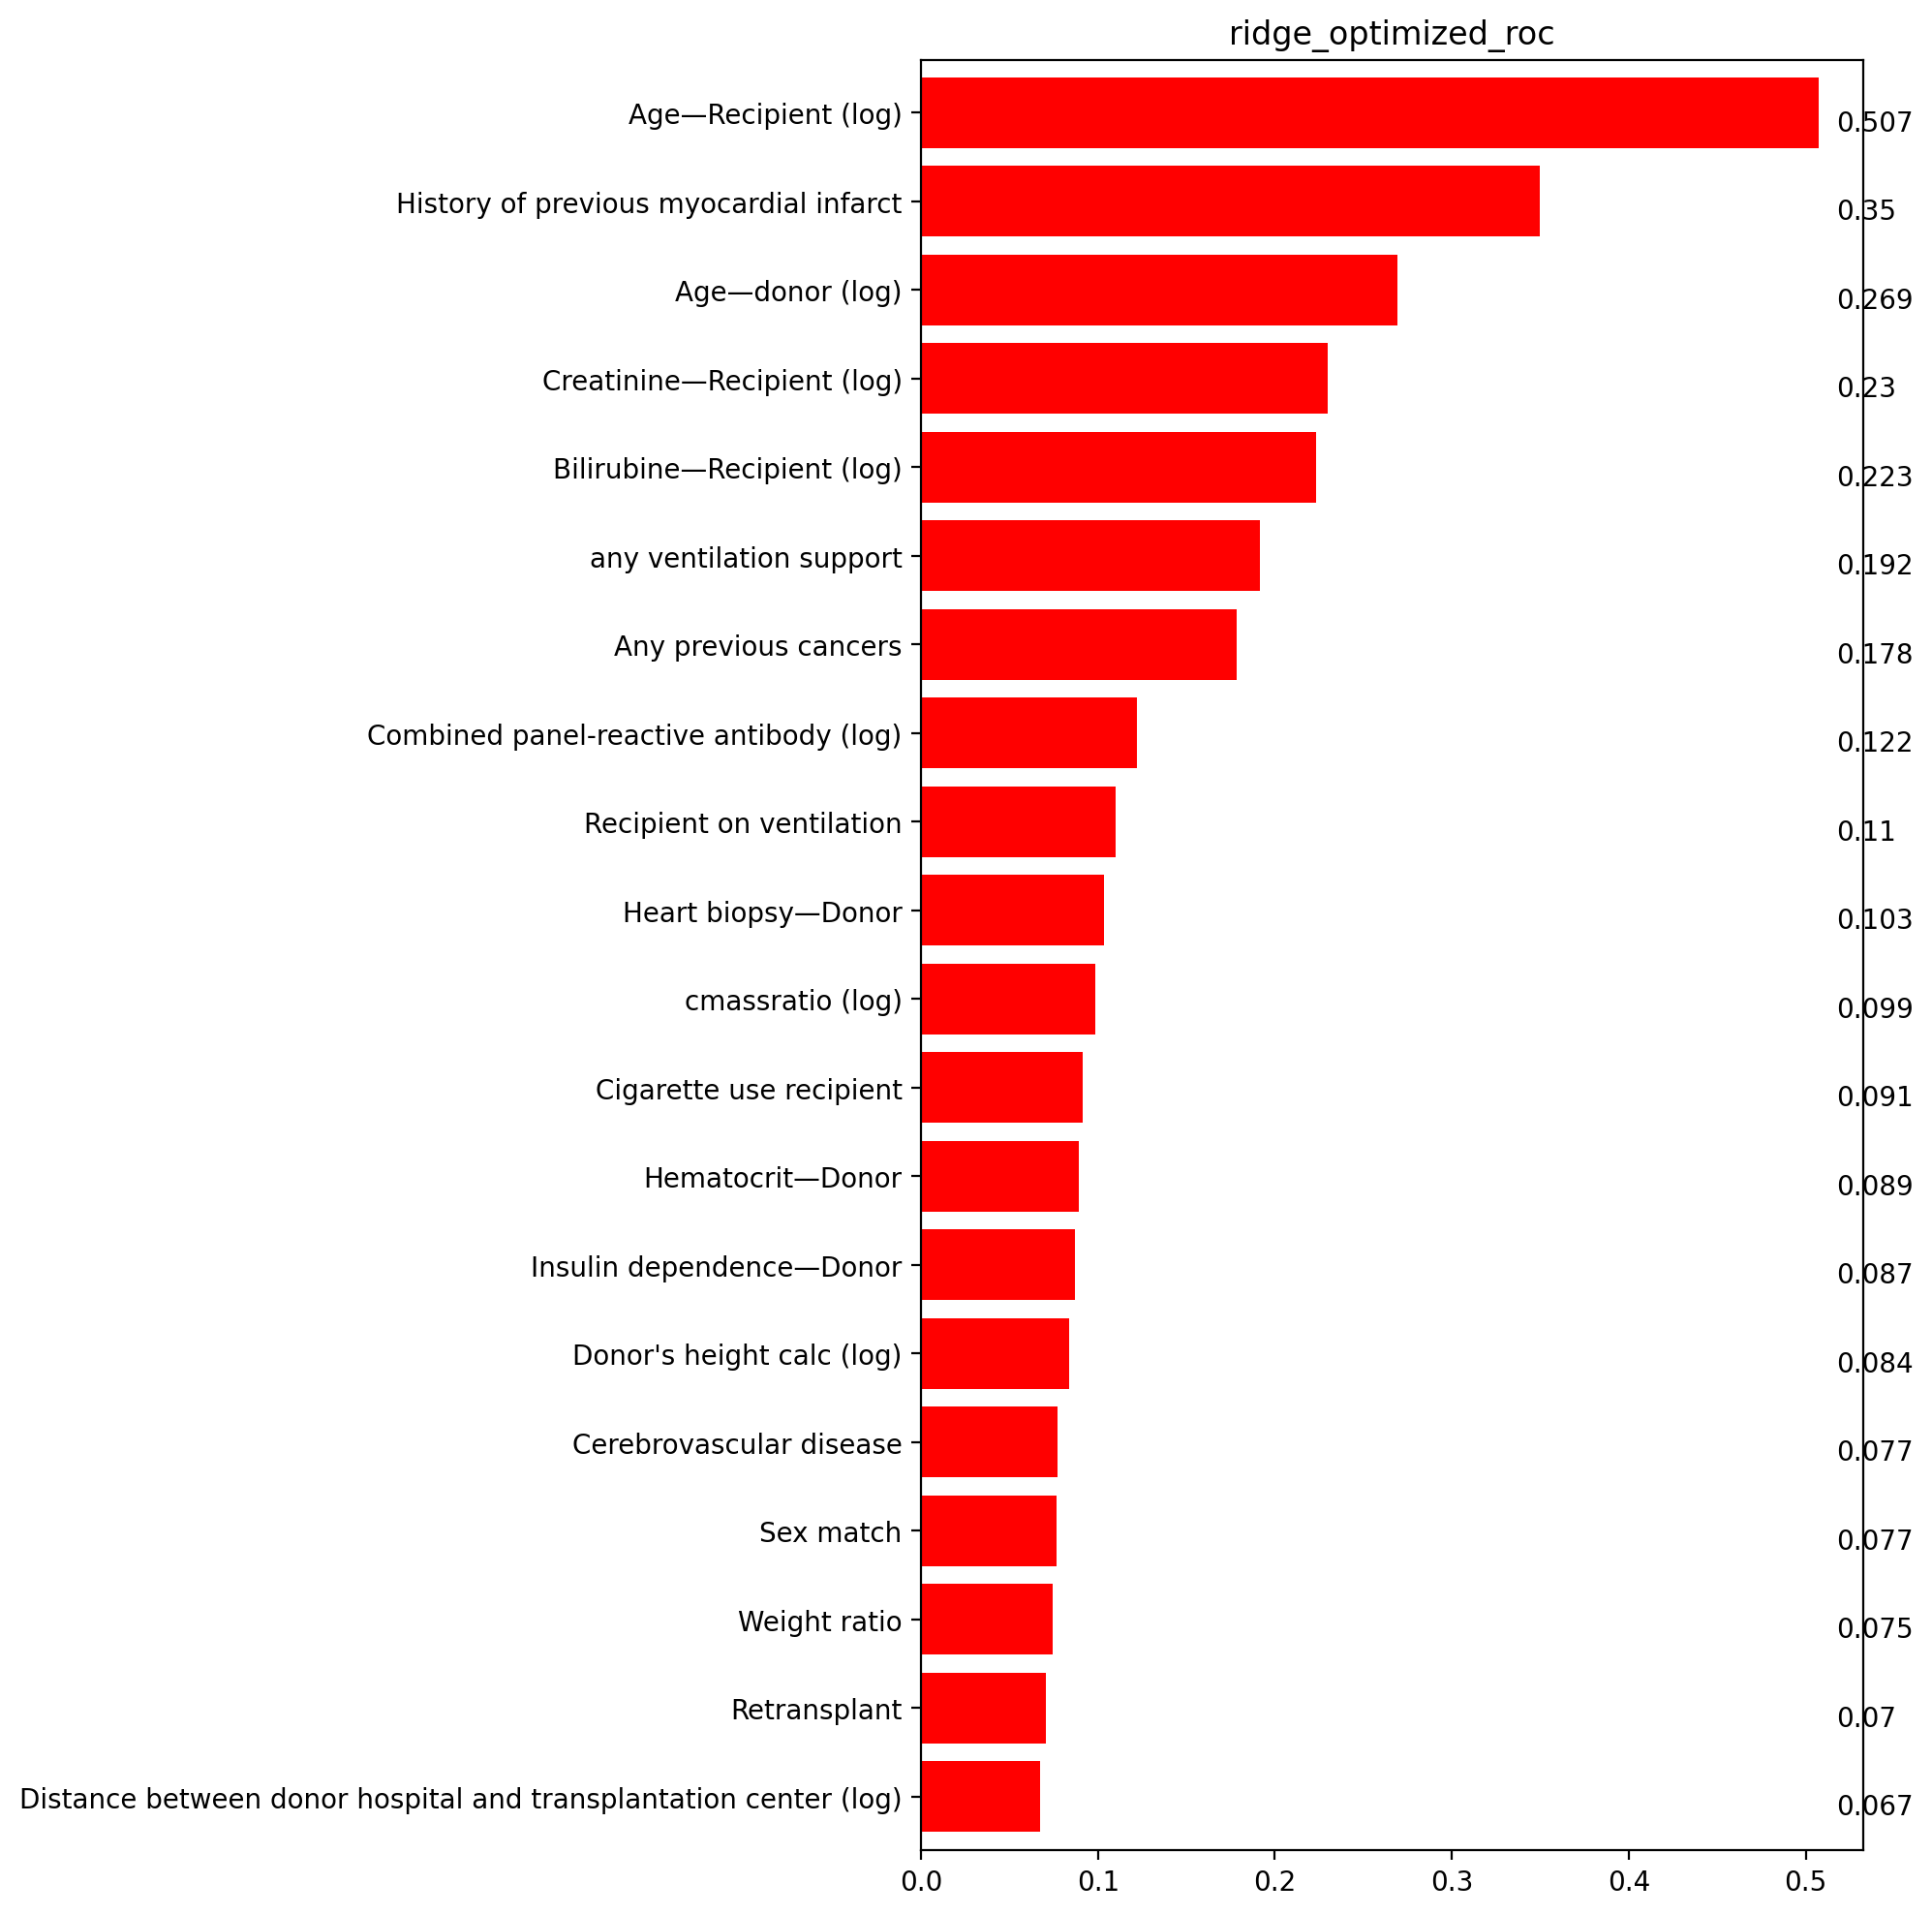

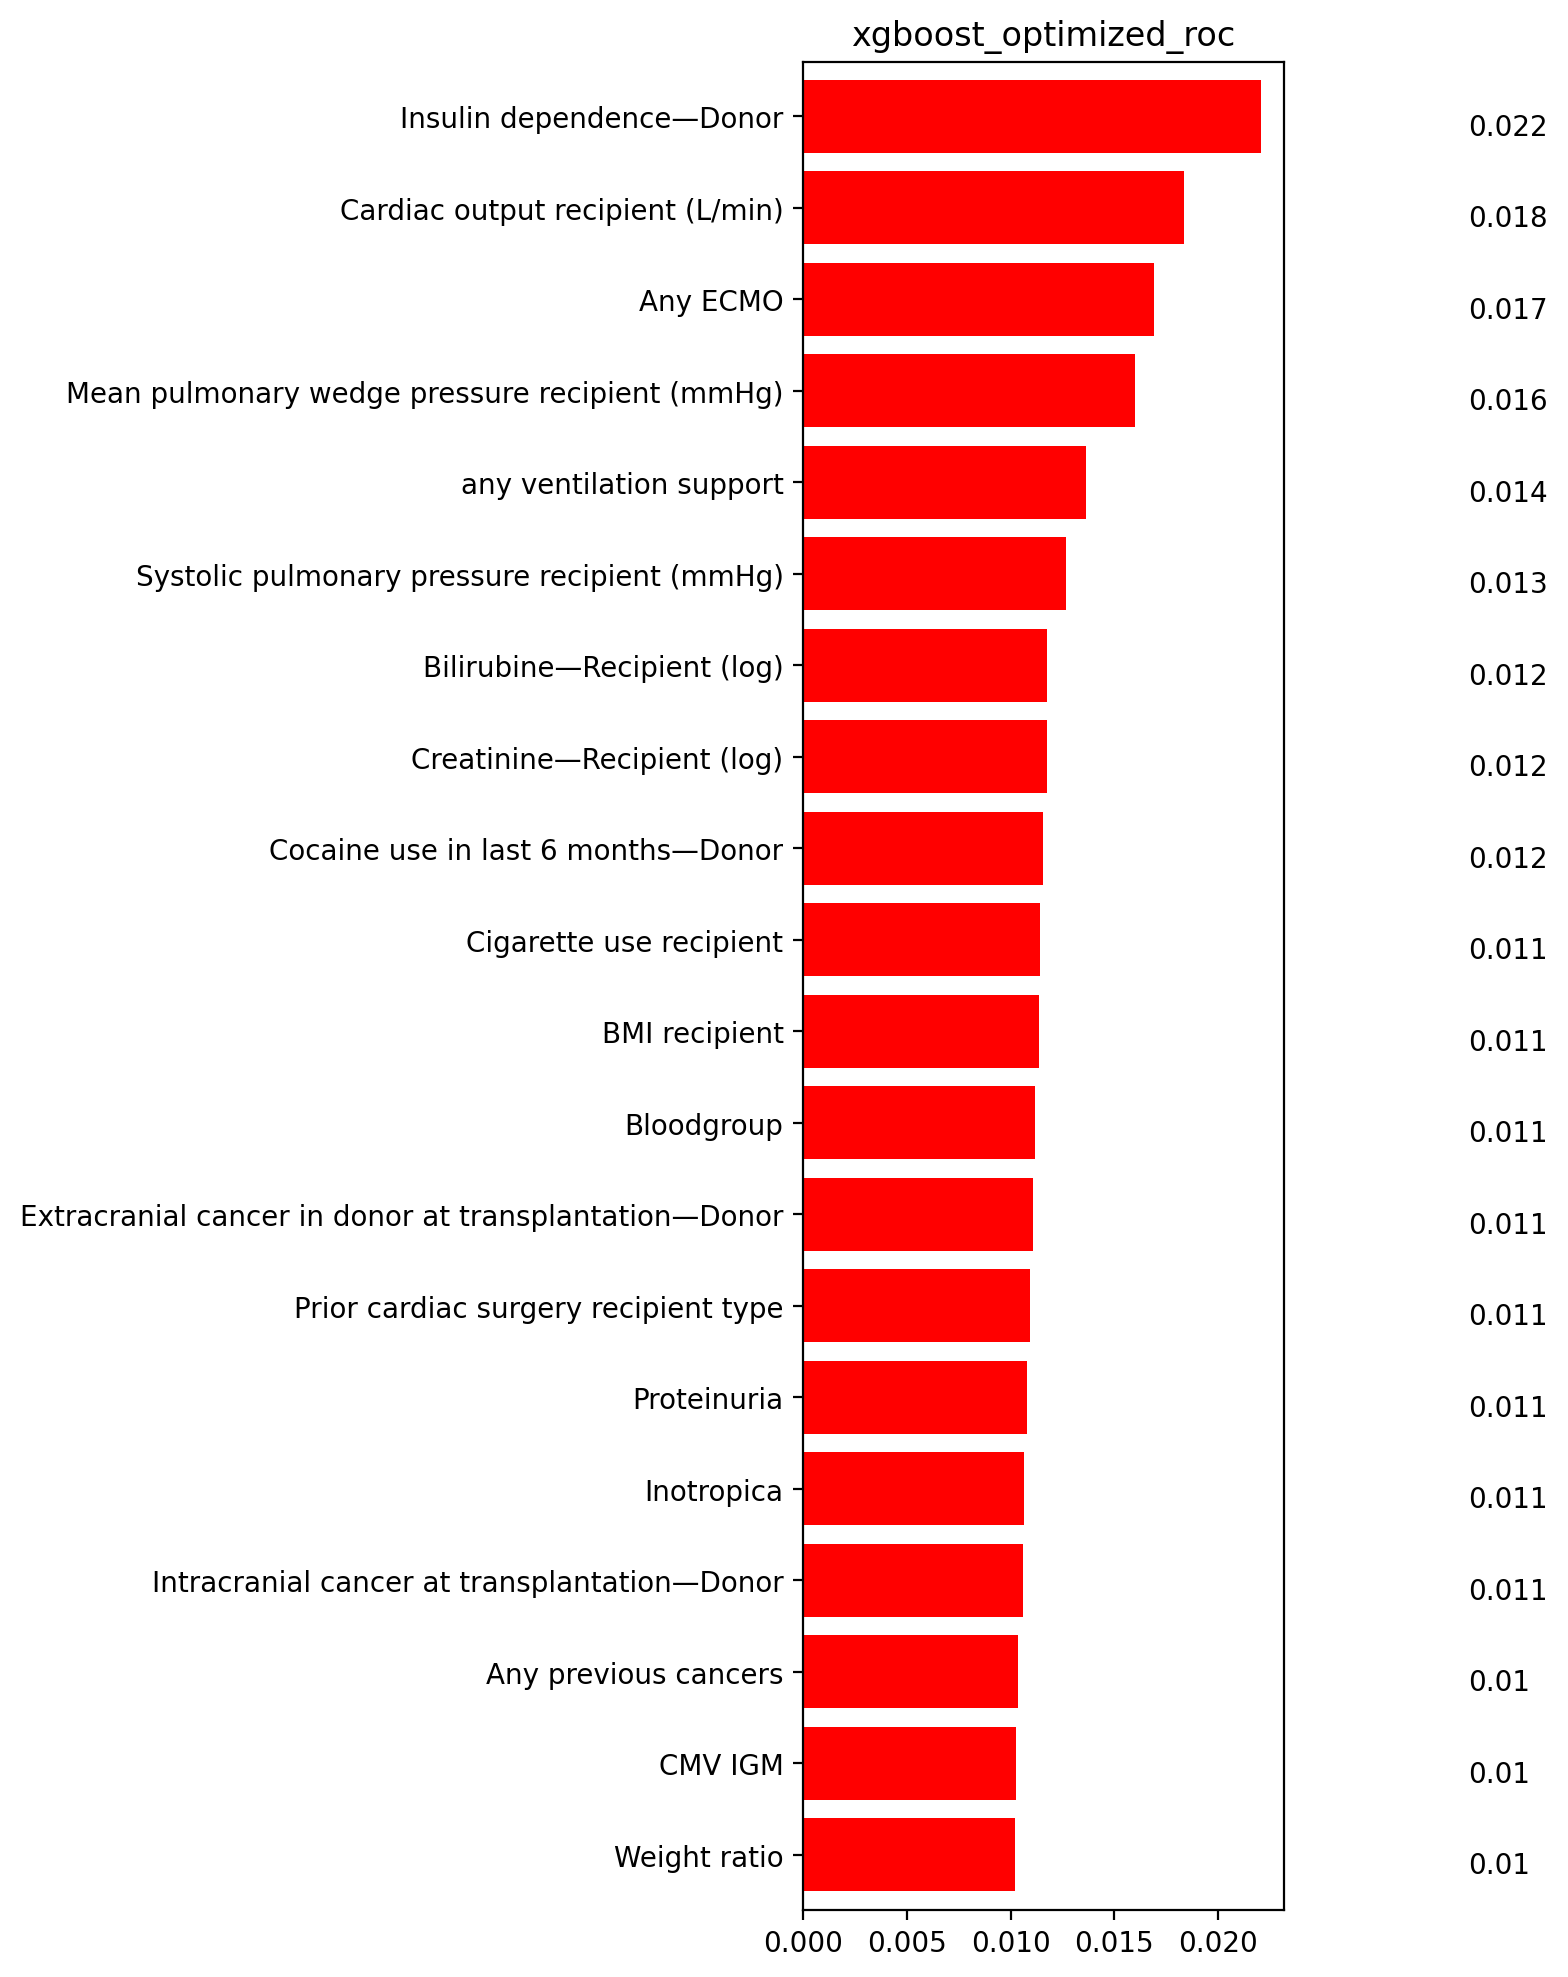

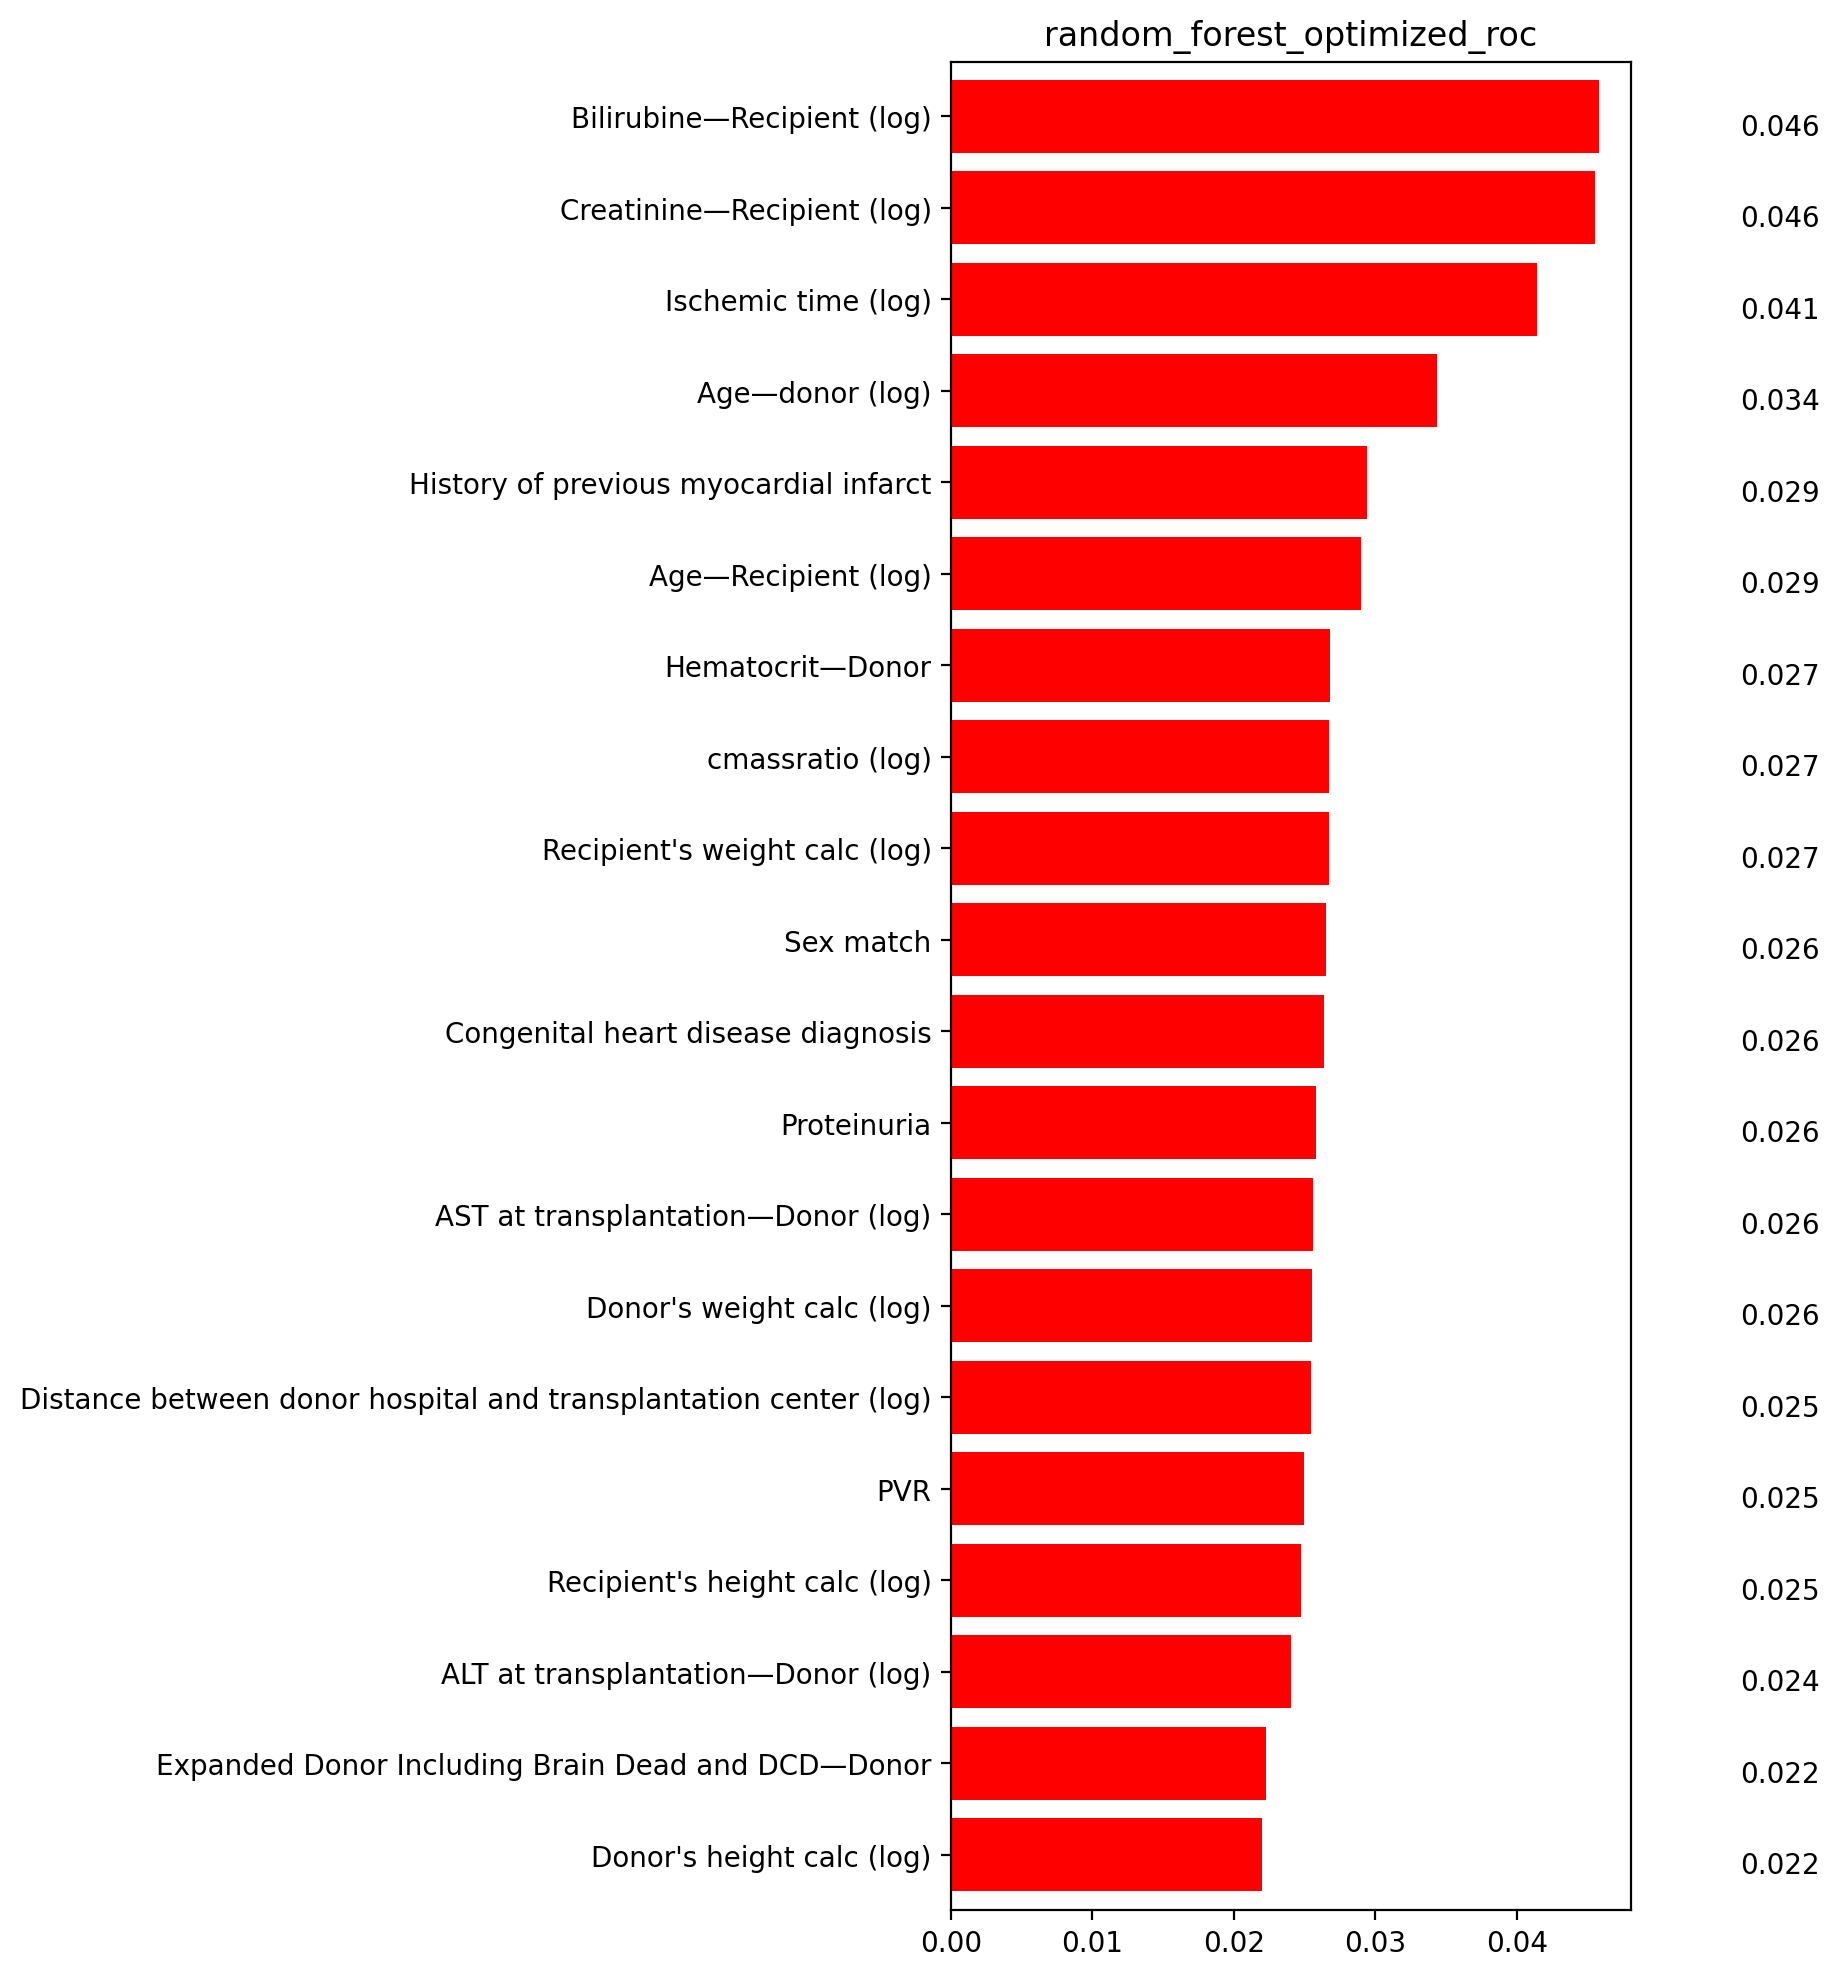

In [19]:
present_feature_importance(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+"_90_all", filter_callback=optimized_filter)



# Chosen hyperparameters

In [20]:
def present_chosen_hyperparameters(file_name: str, filter_callback: Callable = None, pretty: bool = True) -> None:

    results = shelve.open(file_name, flag='r')

    for name, item in results.items():
        if filter_callback is None or filter_callback(name) is True:
            b(name)
            try:
                hyperparameters = item['chosen']['configuration']['classifier']
            except KeyError:
                display_html('<p>No configuration</p>')
            else:
                if pretty:
                    display_dict_as_table_horizontal(hyperparameters)
                else:
                    print(hyperparameters)

            print()

## Shuffled CV

In [21]:
present_chosen_hyperparameters(HEART_TRANSPLANT_CV_SHUFFLED_IDENTIFIER, filter_callback=optimized_filter, pretty=True)

## Expanding window

### 365 days

#### All age groups

In [22]:
present_chosen_hyperparameters(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_all', filter_callback=optimized_filter, pretty=True)

#### < 18 years old

In [23]:
present_chosen_hyperparameters(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_l_18', filter_callback=optimized_filter, pretty=True)

#### >= 18 years old

In [24]:
present_chosen_hyperparameters(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_365_me_18', filter_callback=optimized_filter, pretty=True)

### 90 days

In [25]:
present_chosen_hyperparameters(HEART_TRANSPLANT_EXPANDING_IDENTIFIER+'_90_all', filter_callback=optimized_filter, pretty=True)